Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data breast
url_test = "https://raw.githubusercontent.com/jamessaldo/final-task/master/breastCancer_test.data"
url_train =  "https://raw.githubusercontent.com/jamessaldo/final-task/master/breastCancer_train.data"
data_train = pd.read_csv(url_test, header=None)
data_test = pd.read_csv(url_train, header=None)
data_breast = data_train.append(data_test, ignore_index = True)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada Data Breast Cancer:',data_breast.isnull().sum().sum())

Total Missing Value pada Data Breast Cancer: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data breast
data_new_breast = data_breast.drop([24481],axis=1)
scaler = MinMaxScaler()
data_new_breast = scaler.fit_transform(data_new_breast)
data_new_breast = DataFrame(data_new_breast)
data_new_breast['label'] = list(data_breast[24481])
dic = {'non-relapse':0, 'relapse':1}
data_new_breast.replace(dic,inplace=True)

# 2. Define Reusable Function

## Fitness Function

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
def fitness(dataset, orde):
  start = timeit.default_timer()
  X = pd.DataFrame(dataset.iloc[:, 0:len(dataset.columns)-1].values)
  Y = pd.DataFrame(dataset.iloc[:, len(dataset.columns)-1].values)

  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # # Melakukan proses klasifikasi LR
  X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)
  # Inisialisasi FLNN
  Model = Sequential()
  # Menambah input layer dan hidden layer pertama
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
  # Menambah output layer
  Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  # Menjalankan ANN
  Model.compile(optimizer = Adam(learning_rate=0.6), loss = 'binary_crossentropy', metrics = ['accuracy'])
  # Fitting ANN ke training set
  history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

  #Memprediksi hasil test set
  y_pred = Model(X_test)
  y_pred =(y_pred >= 0.5)

  F1 = f1_score(y_test, y_pred, average='macro')

  print("F1 Score : ", F1)

  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return F1

## FLNN Classifier

In [6]:
def FLNN_Classifier(dataset, cancer_name, orde):
  start = timeit.default_timer()
  X = dataset.drop(['label'], axis=1)
  Y = dataset['label']
  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y.reset_index().label
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # Melakukan proses K-Fold
  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
  kf.get_n_splits(df_)

  # Melakukan proses klasifikasi FLNN
  Hasil_Akurasi = []
  Hasil_F1 = []
  for train_index, test_index in kf.split(X,Y):
    print("Train :" , train_index, "Test :", test_index)
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], label[train_index], label[test_index]
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=0.6), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    hasil = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')
    #F1 = f1_score(y_test, y_pred, average)

    print("Akurasi : ", hasil)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))
    Hasil_Akurasi.append(hasil)
    Hasil_F1.append(F1)

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

  Akurasi = np.array(Hasil_Akurasi)
  F1_Score = np.array(Hasil_F1)
  avg_akurasi = Akurasi.mean()
  avg_F1 = F1_Score.mean()

  print("avg accuraccy "+cancer_name+" = ",avg_akurasi)
  print("avg F1_Score "+cancer_name+" = ",avg_F1)

  print("max accuraccy "+cancer_name+" = ",Akurasi.max())
  print("max F1_Score "+cancer_name+" = ",F1_Score.max())

  print("min accuraccy "+cancer_name+" = ",Akurasi.min())
  print("min F1_Score "+cancer_name+" = ",F1_Score.min())
  
  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return avg_akurasi, avg_F1

## Genetic Algorithm

In [7]:
# define parameters
mutationRate = 0.1
crossoverRate = 0.8
populationSize = 10
maxGen = 5

def GenerateGene(lengthOfGen):
  genes = [] # menyimpan index feature
  for j in range(lengthOfGen):
    genes.append(random.randint(0,1))
  return genes

def GeneratePopulation(lengthOfGen):
  population = []
  for i in range(populationSize):
    individu = GenerateGene(lengthOfGen)
    population.append(individu)
  return population

def CrossOver(parent_1, parent_2, rate, lengthOfGen): #Random Point Method
  new_pop = [] 
  for i in range((populationSize - 2) // 2):
    if random.random() < rate:
      CP = random.randint(0,lengthOfGen) #CrossPoint
      child = parent_1[0:CP] + parent_2[CP:len(parent_2)]
      new_pop.append(child)
      child = parent_2[0:CP] + parent_1[CP:len(parent_1)]
      new_pop.append(child)
    else:
      new_pop.append(parent_1)
      new_pop.append(parent_2)
  return new_pop

def Mutation(mutant, rate, lengthOfGen):
  for i in range(len(mutant)):
    # memutasi tiap gen yang memiliki kemungkinan < rate(0.1)
    for j in range(lengthOfGen):
      if random.random() <= rate:
        mutant[i][j] = 1 - mutant[i][j]
  return mutant

def ZeroGene(indv): #pengecekan apakah gen isinya kosong atau tidak
  total = 0
  for i in range(len(indv)):
    if indv[i] == 0:
      total += 1
  if len(indv) == total:
    return True
  else:
    return False

def Classification(indv, dataset, orde): #using Entropy as fitness
  datasetGA = pd.DataFrame()
  idxDatasetGA = 0
  for i in range(len(dataset.columns)-1):
    if indv[i] == 1:
      datasetGA[idxDatasetGA] = dataset[i]
      idxDatasetGA += 1
  datasetGA['label'] = dataset['label']
  Acc_score, F1_score = FLNN_Classifier(datasetGA, "Breast Cancer", orde)
  totalFeatures = idxDatasetGA+1
  return Acc_score, F1_score, totalFeatures

In [8]:
def GeneticAlgorithm(dataset,orde):
  start = timeit.default_timer()
  # Initial Population
  lengthOfGen = len(dataset.columns) - 1 # panjang gene = panjang fitur tanpa label

  # fintess evaluation
  bestF1 = 0
  bestNFeature = len(dataset.columns) - 1
  population = GeneratePopulation(lengthOfGen) # Generate 1st Generation
  generation = 0 #max generation = 2**len(feature)

  while (generation < maxGen and (bestF1*100) < 90):
    print('Generation :',generation)
    fitness = pd.DataFrame()
    acc = []
    f1score = []
    # ent = []
    nFeature = []
    gene = []
    i = 0
    while (i < len(population)):
      if ZeroGene(population[i]) == False:
        print('gene :', population[i])
        accuracy, f1, totalFeatures = Classification(population[i], dataset, orde) # Count Fitness Value
        acc.append(accuracy)
        f1score.append(f1)
        nFeature.append(totalFeatures)
        gene.append(population[i])
        bestF1 = f1
      i += 1

    fitness['gene'] = gene
    fitness['feature'] = nFeature
    fitness['f1_score'] = f1score

    fitness = fitness.sort_values(['f1_score'],ascending=False)

    bestF1 = fitness['f1_score'][fitness.index[0]]
    bestNFeature = fitness['feature'][fitness.index[0]]

    # select parent
    best_gene = fitness['gene'][fitness.index[0]].copy()
    best_gene_2 = fitness['gene'][fitness.index[1]].copy()

    #Crossover methods: Fixed Point, "Random Point", Alternate Point
    population = CrossOver(best_gene.copy(), best_gene_2.copy(), crossoverRate, lengthOfGen)

    # Mutation
    population = Mutation(population, mutationRate, lengthOfGen)

    # Masukkan best child tadi
    population.append(best_gene)
    population.append(best_gene_2)

    # Print Result
    print('===============================================================================================================================================================================================================')
    print('gen terbaik :', best_gene)
    print('F-1 Score terbaik :',bestF1,' || jumlah fitur :',bestNFeature)
    print()

    # New Generation
    generation += 1
  listDrop = []
  for i in range(len(dataset.columns)-1):
    if best_gene[i] == 0:
      listDrop.append(dataset.columns[i])
  dataset_GA = dataset.drop(listDrop, axis = 1)
  stop = timeit.default_timer()
  print('Running Time: ', stop - start)
  return dataset_GA

# 3. Feature Selection with IG

## Breast

In [9]:
data_X = data_new_breast.drop(['label'],axis=1)
data_Y = data_new_breast['label']

X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.3, random_state=0)

sel_k_best = SelectKBest(mutual_info_classif, k=100)
sel_k_best.fit(data_X, data_Y)
data_X_new = sel_k_best.transform(data_X)

Breast_IG = pd.DataFrame(data_X_new)
Breast_IG['label'] = data_Y
useddata_breast = Breast_IG
print(useddata_breast.shape)
Breast_IG

(97, 101)


0         1         2         3         4         5         6  \
0   0.138947  0.006717  0.531469  0.011071  0.008422  0.003883  0.602176   
1   0.168947  0.007284  0.955711  0.010972  0.004524  0.004291  0.879565   
2   0.062105  0.005363  0.742424  0.011041  0.008155  0.002270  0.712510   
3   0.046316  0.007254  0.360140  0.009787  0.007926  0.001971  0.672883   
4   0.137895  0.005831  1.000000  0.012028  0.007996  0.006093  0.729604   
..       ...       ...       ...       ...       ...       ...       ...   
92  0.218947  0.004199  0.865967  0.012858  0.007073  0.005486  0.796426   
93  0.120526  0.005264  0.336830  0.003674  0.005436  0.024303  0.842269   
94  0.174211  0.006458  0.368298  0.013885  0.007291  0.006282  0.770785   
95  0.119474  0.005254  0.607226  0.012325  0.008859  0.005107  0.665890   
96  0.193684  0.009354  0.745921  0.009678  0.009920  0.005924  0.798757   

           7         8         9  ...        91        92        93        94  \
0   0.323552  0.442957  0.397614  ...  0.015824  0.009419  0.005540  0.533149   
1   0.124324  0.442320  0.314115  ...  0.021098  0.008874  0.007072  0.469613   
2   0.858687  0.398343  0.296223  ...  0.018618  0.009300  0.005053  0.350829   
3   0.416988  0.414914  0.431412  ...  0.019637  0.007981  0.006157  0.461326   
4   0.236293  0.640535  0.576541  ...  0.020167  0.007793  0.005113  0.279006   
..       ...       ...       ...  ...       ...       ...       ...       ...   
92  0.581467  0.652008  0.449304  ...  0.018539  0.009290  0.004963  0.267956   
93  0.633205  0.471638  0.520875  ...  0.022422  0.010738  0.006694  0.444751   
94  0.793050  0.355641  0.691849  ...  0.020314  0.007793  0.003372  0.596685   
95  0.602317  0.653920  0.310139  ...  0.019627  0.009478  0.006794  0.486188   
96  0.099614  0.773741  0.642147  ...  0.021196  0.008963  0.006416  0.439227   

          95        96        97        98        99  label  
0   0.458824  0.003322  0.443590  0.006083  0.021342      1  
1   0.456471  0.003292  0.484615  0.005834  0.013116      1  
2   0.190588  0.001726  0.524359  0.005396  0.012967      1  
3   0.451765  0.002823  0.805128  0.004072  0.013244      1  
4   0.160000  0.002384  0.276923  0.005466  0.016918      1  
..       ...       ...       ...       ...       ...    ...  
92  0.331765  0.002205  0.410256  0.006551  0.011239      0  
93  0.242353  0.002534  0.366667  0.005217  0.014656      0  
94  0.529412  0.002664  0.697436  0.005327  0.011476      0  
95  0.254118  0.002813  0.561538  0.005775  0.011200      0  
96  0.338824  0.002394  0.612821  0.003405  0.011970      0  

[97 rows x 101 columns]

# 4. Classification

## Breast + IG

Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      0.90      0.62        10

    accuracy                           0.45        20
   macro avg       0.24      0.45      0.31        20
weighted avg       0.24      0.45      0.31        20



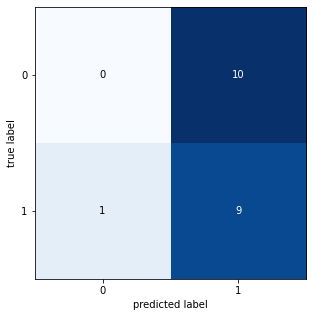

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



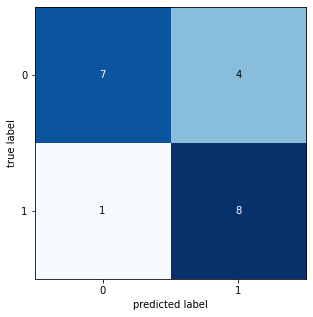

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


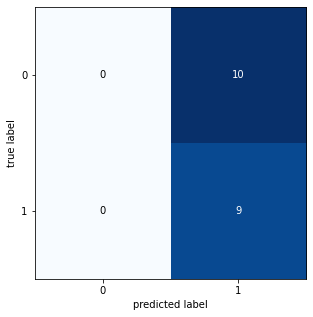

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



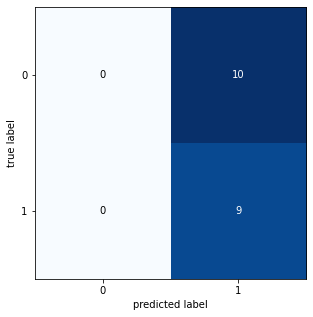

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



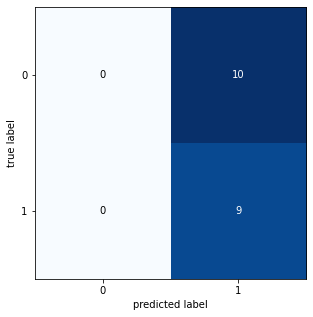

avg accuraccy Breast cancer =  0.5242105263157895
avg F1_Score Breast cancer =  0.40480079509117617
max accuraccy Breast cancer =  0.75
max F1_Score Breast cancer =  0.7493734335839599
min accuraccy Breast cancer =  0.45
min F1_Score Breast cancer =  0.3103448275862069
Running Time:  29.390767444005178


(0.5242105263157895, 0.40480079509117617)

In [10]:
FLNN_Classifier(Breast_IG,"Breast cancer",2)

Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


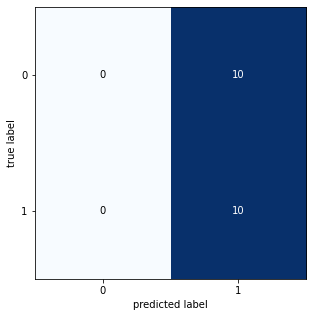

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



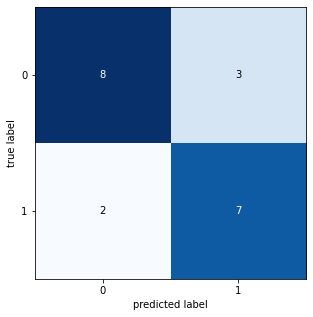

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



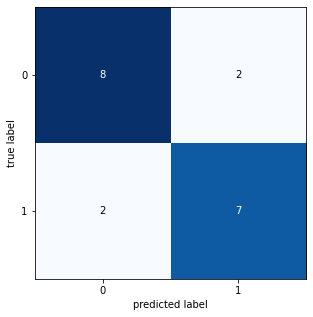

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



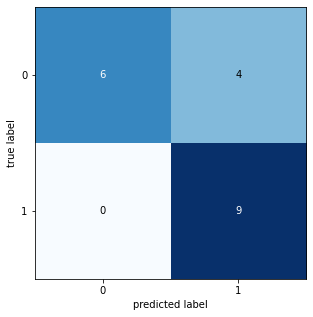

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



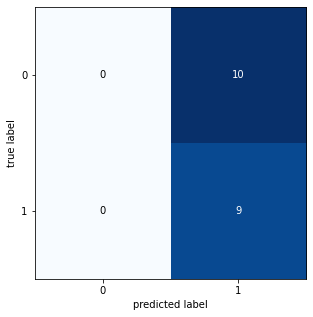

avg accuraccy Breast cancer =  0.6605263157894739
avg F1_Score Breast cancer =  0.5954230272651325
max accuraccy Breast cancer =  0.7894736842105263
max F1_Score Breast cancer =  0.788888888888889
min accuraccy Breast cancer =  0.47368421052631576
min F1_Score Breast cancer =  0.32142857142857145
Running Time:  29.0036126949999


(0.6605263157894739, 0.5954230272651325)

In [11]:
FLNN_Classifier(Breast_IG,"Breast cancer",3)

Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      0.90      0.62        10

    accuracy                           0.45        20
   macro avg       0.24      0.45      0.31        20
weighted avg       0.24      0.45      0.31        20



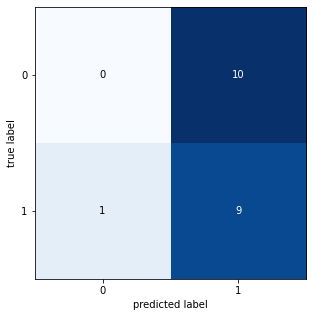

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



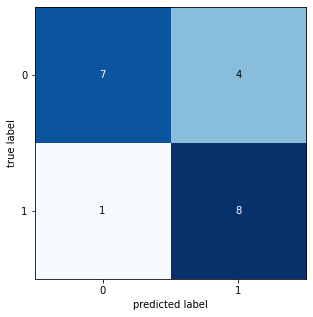

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


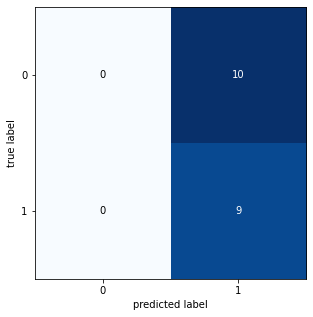

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



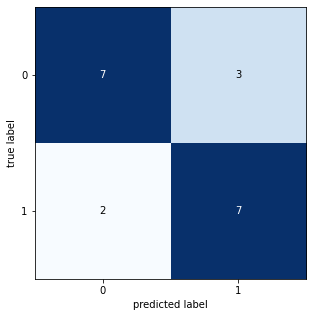

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



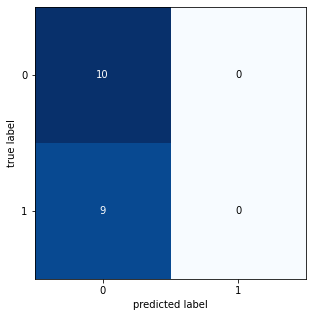

avg accuraccy Breast cancer =  0.5873684210526315
avg F1_Score Breast cancer =  0.4925633048137586
max accuraccy Breast cancer =  0.75
max F1_Score Breast cancer =  0.7493734335839599
min accuraccy Breast cancer =  0.45
min F1_Score Breast cancer =  0.3103448275862069
Running Time:  29.544988179004577


(0.5873684210526315, 0.4925633048137586)

In [12]:
FLNN_Classifier(Breast_IG,"Breast cancer",4)

## Breast + IG + GA

Generation : 0
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00

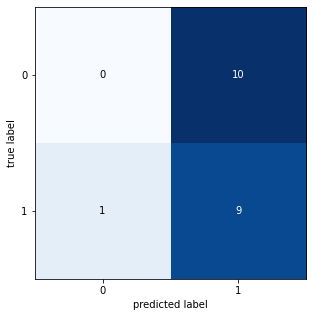

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


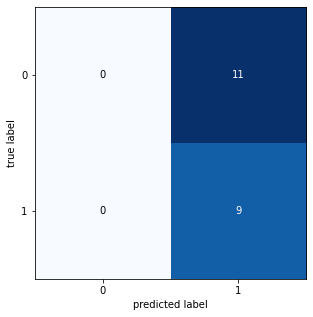

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



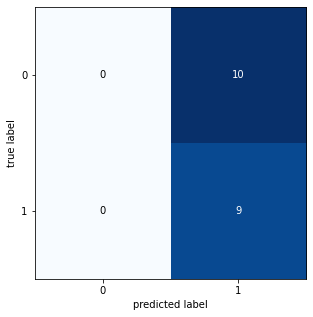

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



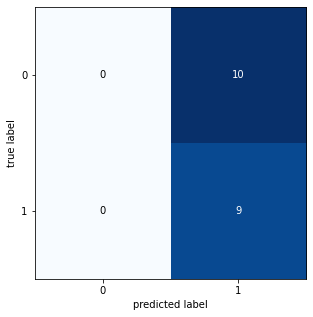

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



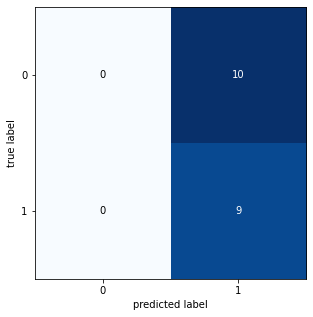

avg accuraccy Breast Cancer =  0.46421052631578946
avg F1_Score Breast Cancer =  0.3169950738916256
max accuraccy Breast Cancer =  0.47368421052631576
max F1_Score Breast Cancer =  0.32142857142857145
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.920767616000376
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


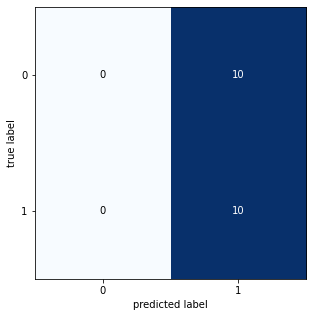

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



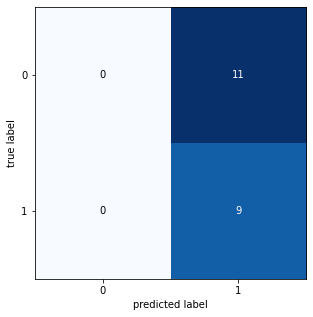

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



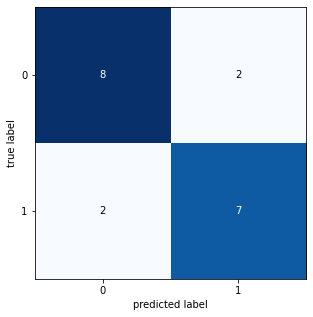

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692307
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.56      1.00      0.72         9

    accuracy                           0.63        19
   macro avg       0.78      0.65      0.59        19
weighted avg       0.79      0.63      0.58        19



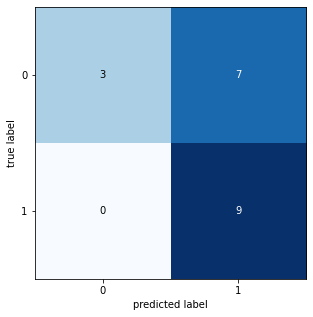

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7738095238095237
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      0.56      0.71         9

    accuracy                           0.79        19
   macro avg       0.86      0.78      0.77        19
weighted avg       0.85      0.79      0.78        19



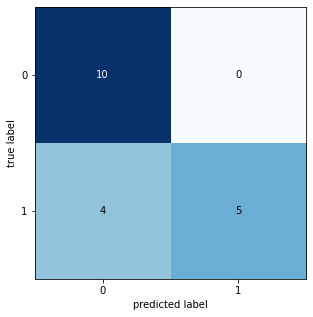

avg accuraccy Breast Cancer =  0.6321052631578947
avg F1_Score Breast Cancer =  0.5594291608774367
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.69261551499949
gene : [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

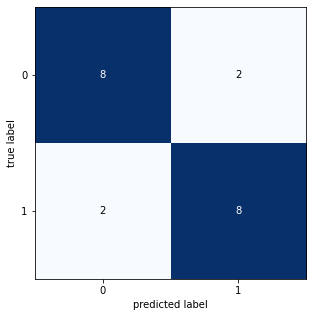

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



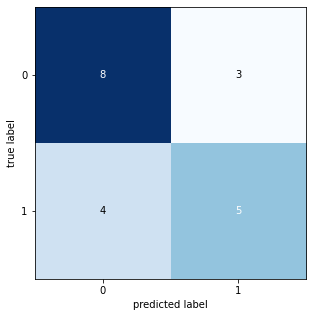

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


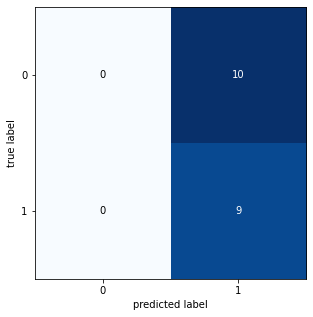

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



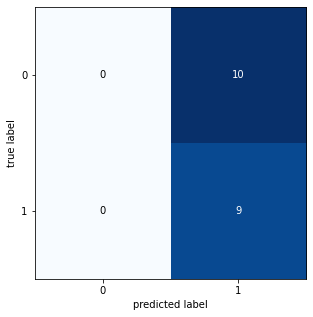

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



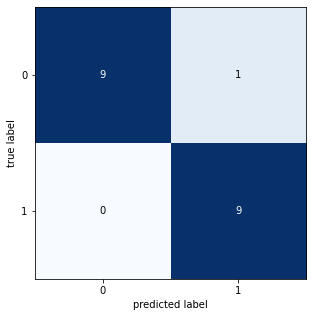

avg accuraccy Breast Cancer =  0.6689473684210526
avg F1_Score Breast Cancer =  0.6064338595850239
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.0080873889965
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


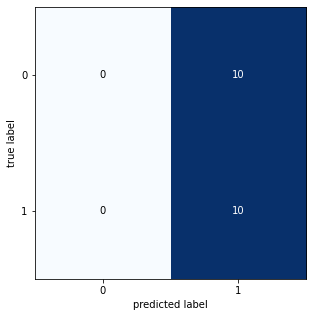

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



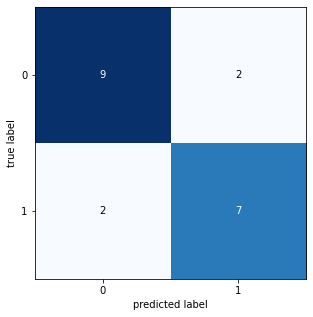

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



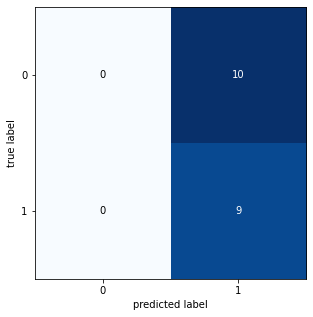

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



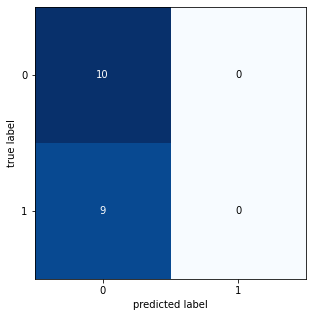

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



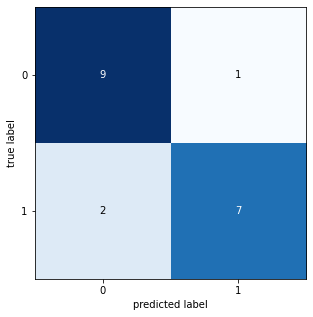

avg accuraccy Breast Cancer =  0.6284210526315789
avg F1_Score Breast Cancer =  0.5275810846804762
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.89582420900115
gene : [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

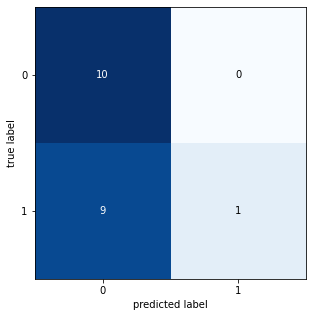

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



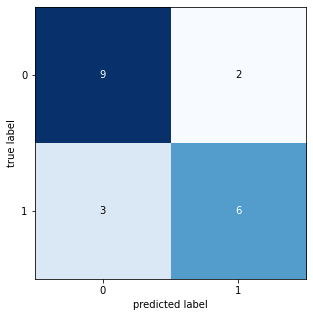

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


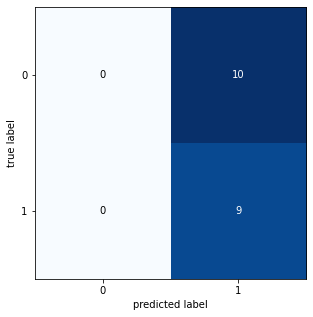

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



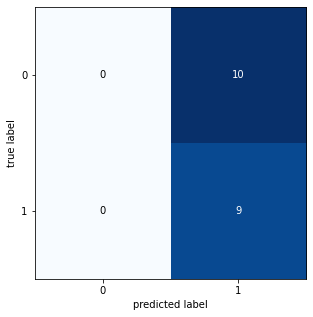

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



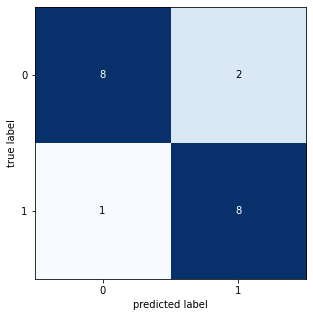

avg accuraccy Breast Cancer =  0.6178947368421053
avg F1_Score Breast Cancer =  0.5329889214855401
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.8231293439967
gene : [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


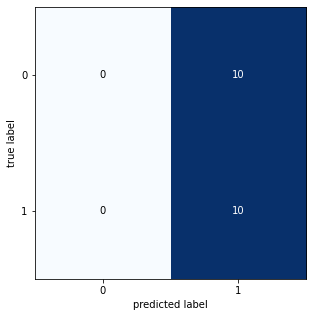

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



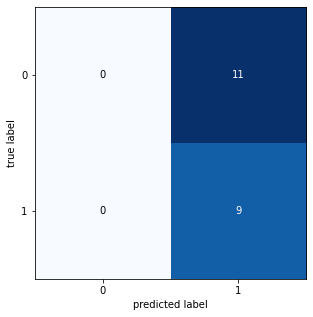

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



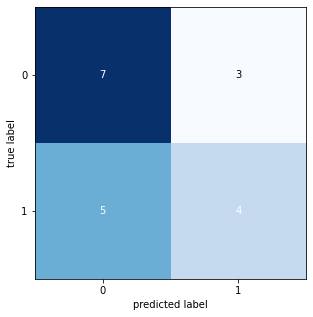

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



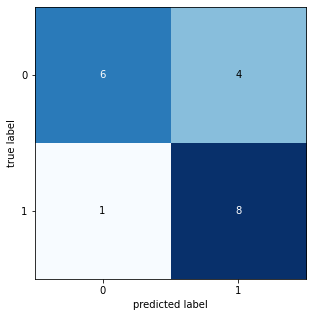

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



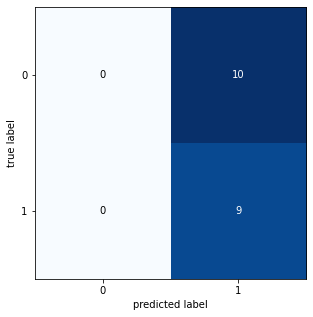

avg accuraccy Breast Cancer =  0.5478947368421052
avg F1_Score Breast Cancer =  0.45343642159057984
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.64666974800639
gene : [1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

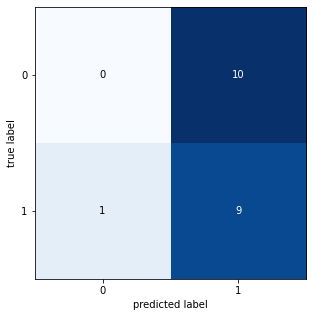

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



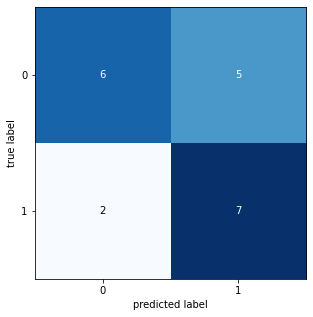

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


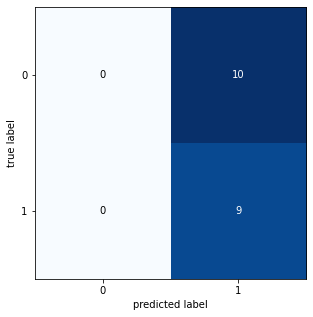

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



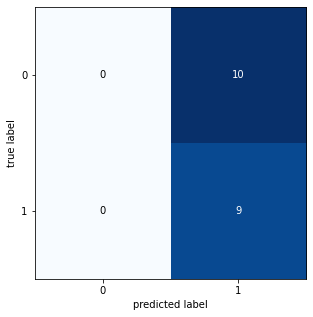

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



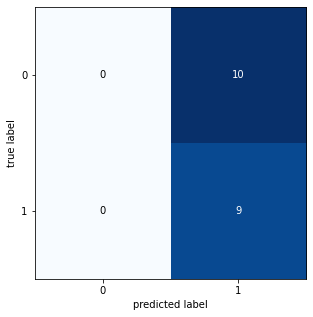

avg accuraccy Breast Cancer =  0.5042105263157894
avg F1_Score Breast Cancer =  0.38475066977789296
max accuraccy Breast Cancer =  0.65
max F1_Score Breast Cancer =  0.6491228070175439
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.83638113600318
gene : [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

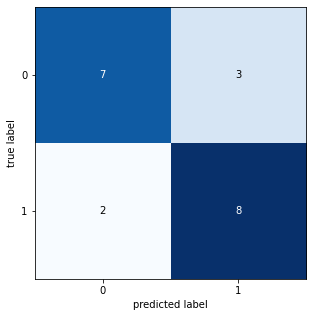

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


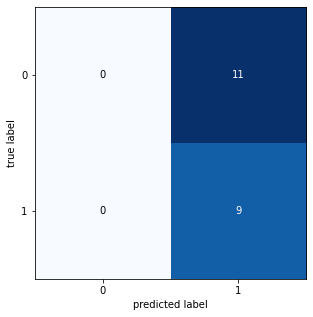

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



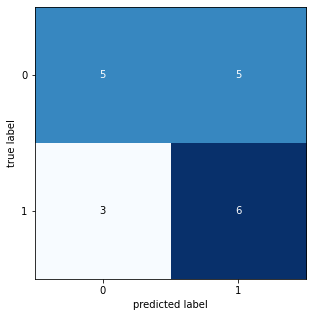

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



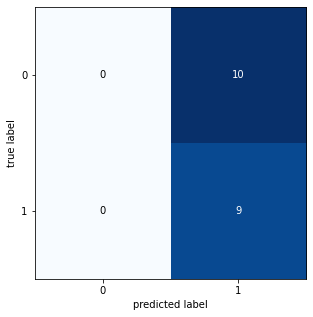

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5043478260869565
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.50      0.78      0.61         9

    accuracy                           0.53        19
   macro avg       0.55      0.54      0.50        19
weighted avg       0.55      0.53      0.50        19



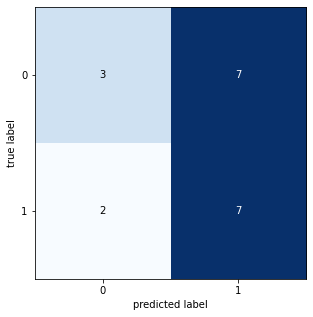

avg accuraccy Breast Cancer =  0.5557894736842105
avg F1_Score Breast Cancer =  0.49265448729269445
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.75118442299572
gene : [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


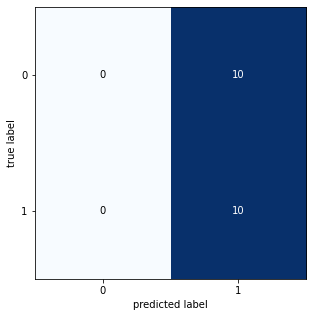

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



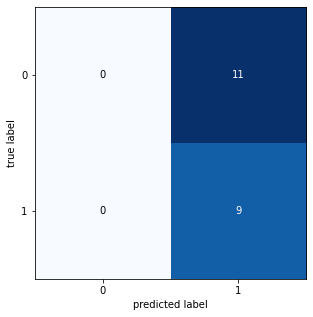

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



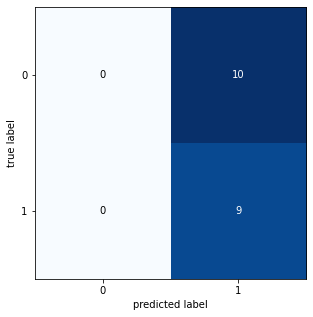

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



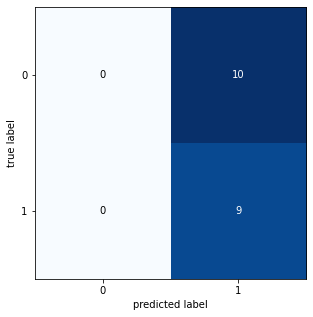

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



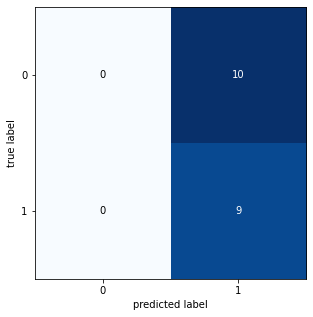

avg accuraccy Breast Cancer =  0.4742105263157894
avg F1_Score Breast Cancer =  0.3215927750410509
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.3333333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.65568786399672
gene : [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

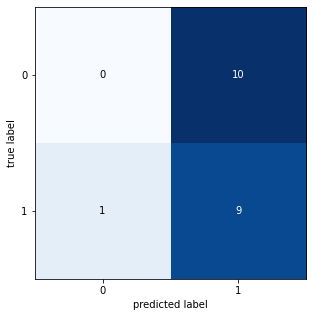

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


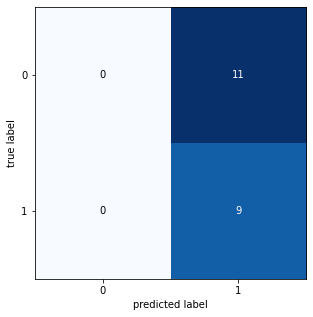

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.67      0.44      0.53         9

    accuracy                           0.63        19
   macro avg       0.64      0.62      0.61        19
weighted avg       0.64      0.63      0.62        19



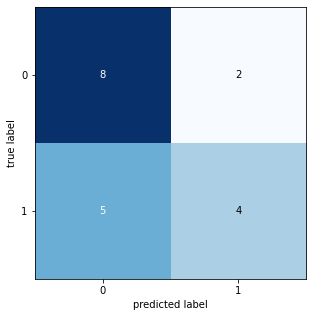

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



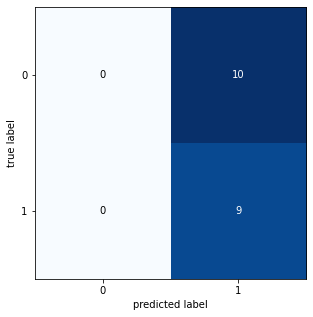

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



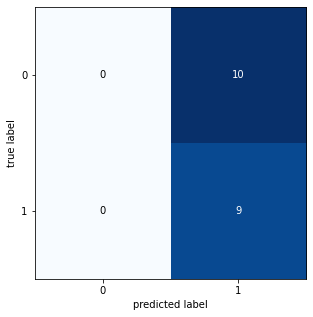

avg accuraccy Breast Cancer =  0.4957894736842106
avg F1_Score Breast Cancer =  0.375607910330549
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.6144927536231883
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.82653716800269
gen terbaik : [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
F-1 Score terbaik : 0.6064338595850239  || jumlah fitur : 59

Generation : 1
gene : [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


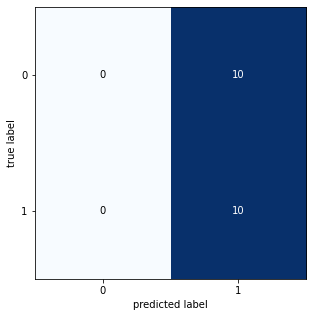

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



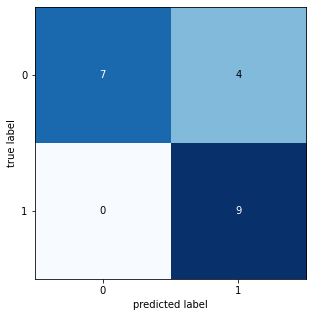

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



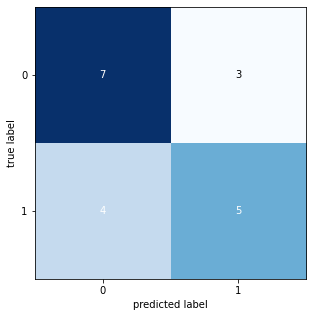

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



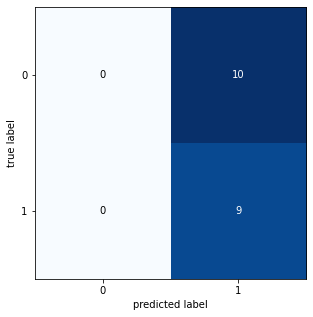

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



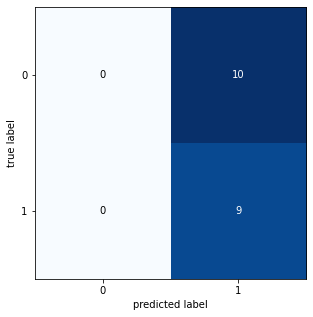

avg accuraccy Breast Cancer =  0.5757894736842106
avg F1_Score Breast Cancer =  0.4803242509124862
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.927384013994015
gene : [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

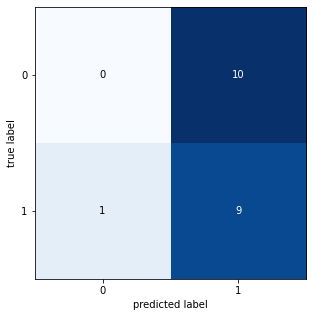

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



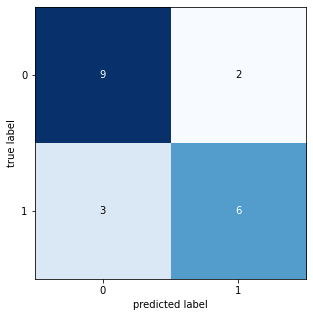

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



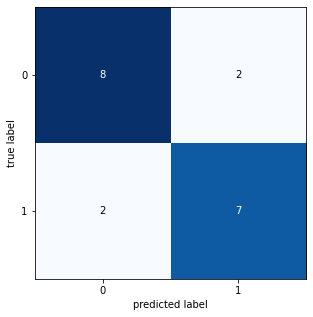

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


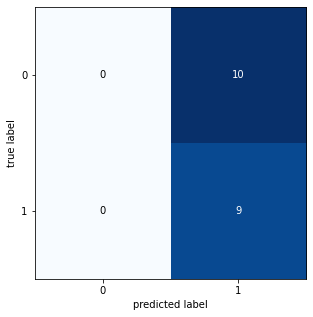

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



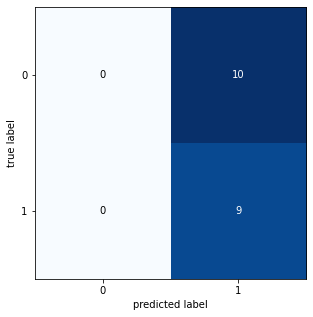

avg accuraccy Breast Cancer =  0.5873684210526317
avg F1_Score Breast Cancer =  0.4972672767257828
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.71703917999548
gene : [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

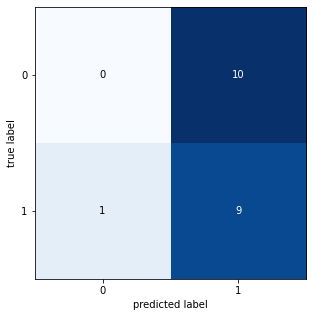

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


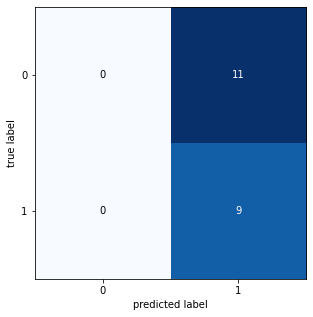

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



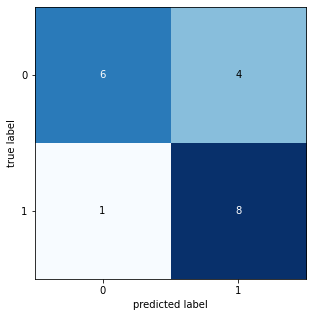

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



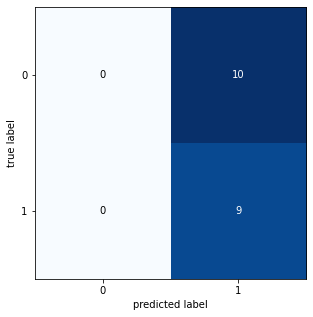

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



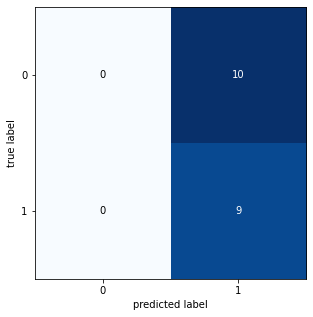

avg accuraccy Breast Cancer =  0.516842105263158
avg F1_Score Breast Cancer =  0.39948807109050516
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  37.117099340001005
gene : [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

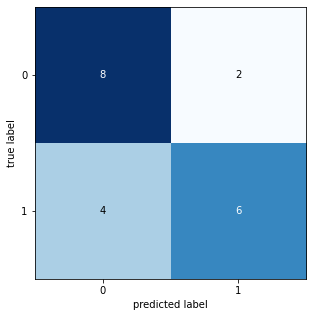

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


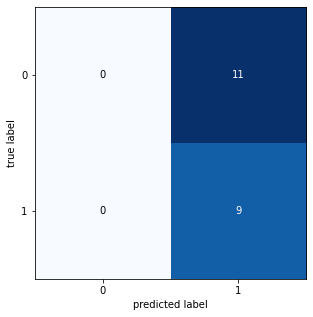

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



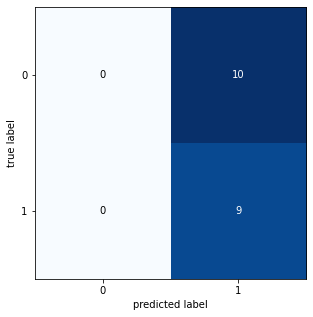

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



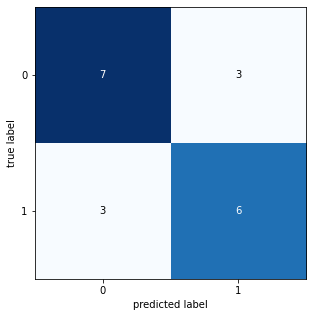

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



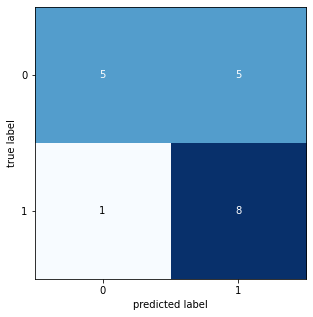

avg accuraccy Breast Cancer =  0.598421052631579
avg F1_Score Breast Cancer =  0.5376425585908344
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.6969696969696968
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.809731413995905
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


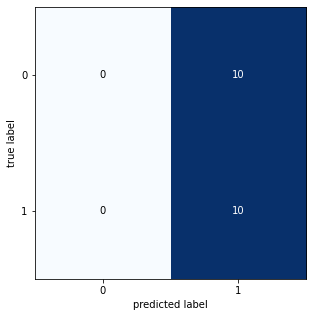

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



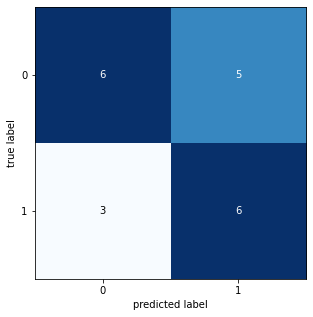

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



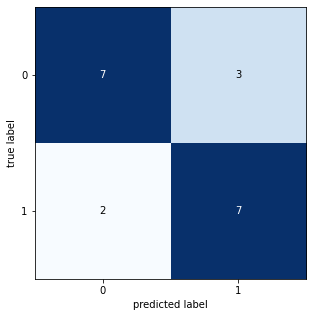

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



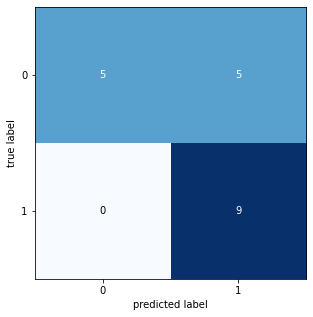

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



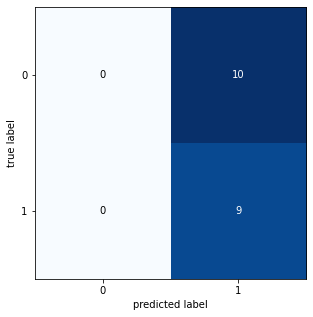

avg accuraccy Breast Cancer =  0.6094736842105264
avg F1_Score Breast Cancer =  0.5432483382368967
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  37.801596125995275
gene : [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1

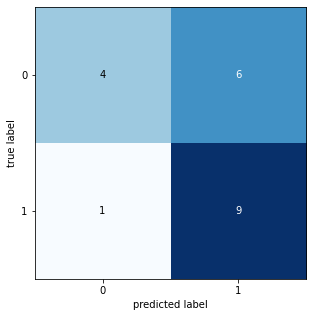

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



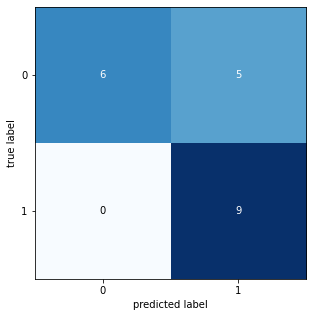

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


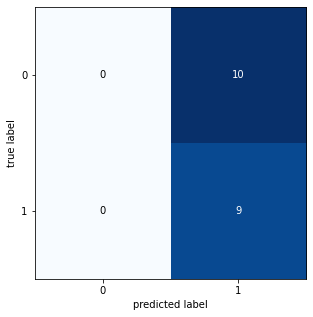

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



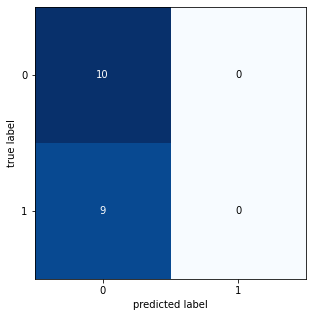

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



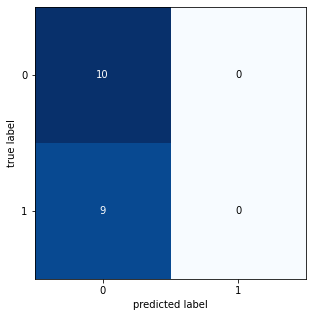

avg accuraccy Breast Cancer =  0.5852631578947368
avg F1_Score Breast Cancer =  0.4763991869611413
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966752
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.45130183800211
gene : [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

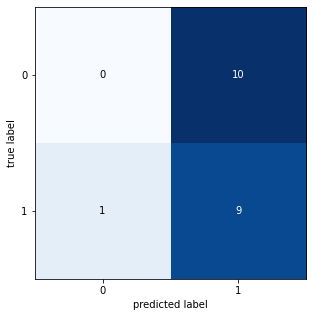

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


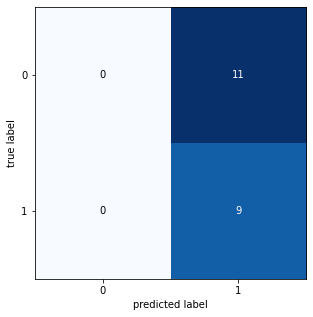

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



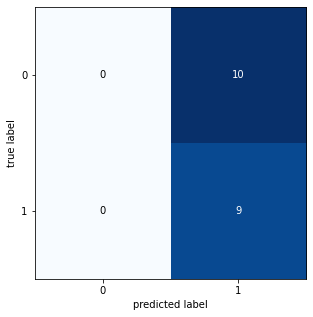

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



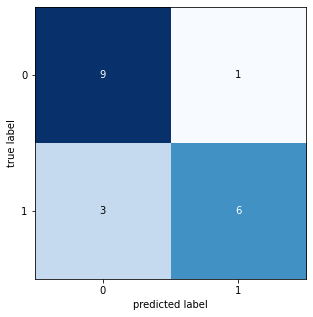

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



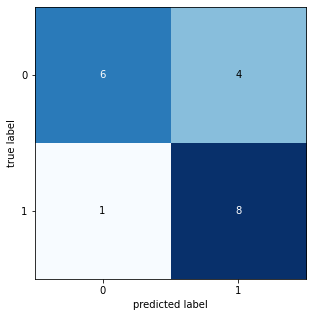

avg accuraccy Breast Cancer =  0.58
avg F1_Score Breast Cancer =  0.49202053862297274
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7840909090909092
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.75993300200207
gene : [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

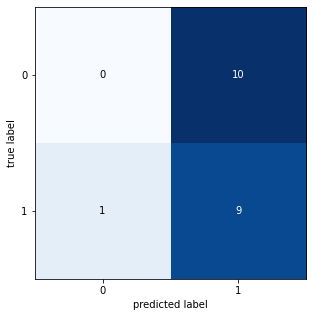

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



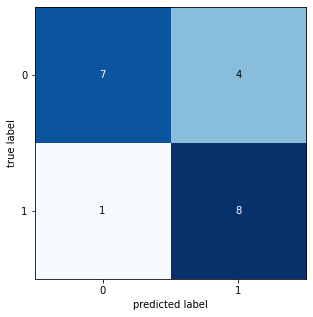

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



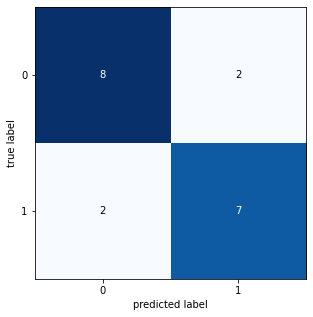

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


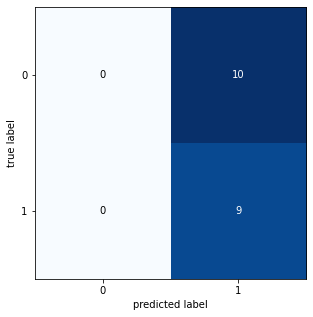

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692308
              precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.75      0.33      0.46         9

    accuracy                           0.63        19
   macro avg       0.68      0.62      0.59        19
weighted avg       0.67      0.63      0.60        19



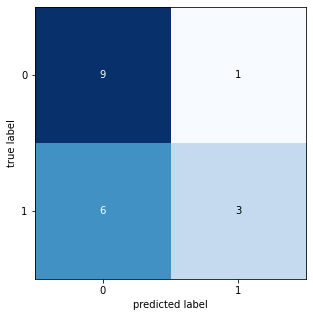

avg accuraccy Breast Cancer =  0.6189473684210526
avg F1_Score Breast Cancer =  0.5521609904513716
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.853341269998054
gene : [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

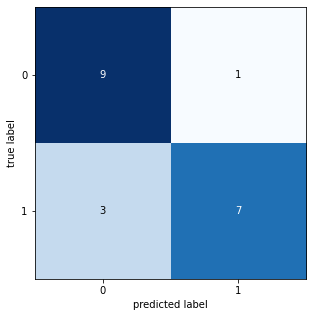

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.40476190476190477
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.47      1.00      0.64         9

    accuracy                           0.50        20
   macro avg       0.74      0.55      0.40        20
weighted avg       0.76      0.50      0.38        20



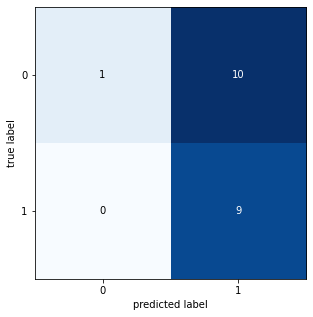

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



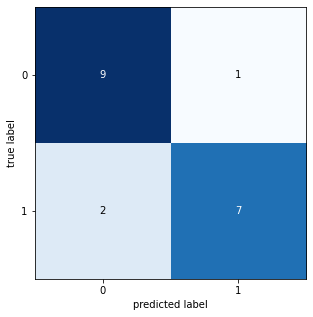

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


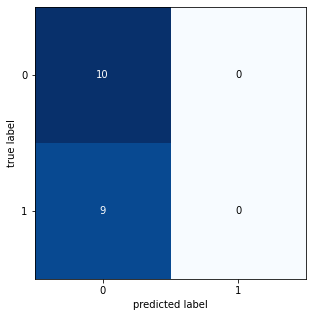

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



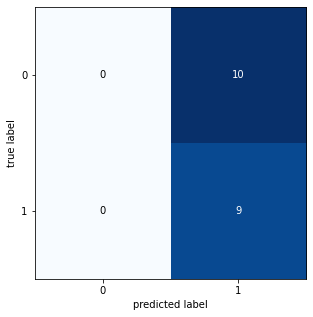

avg accuraccy Breast Cancer =  0.6284210526315789
avg F1_Score Breast Cancer =  0.5418667989661905
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.80415718999575
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

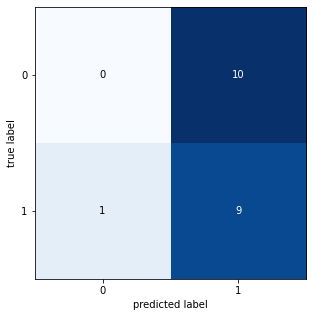

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5833333333333335
              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.53      0.89      0.67         9

    accuracy                           0.60        20
   macro avg       0.67      0.63      0.58        20
weighted avg       0.68      0.60      0.58        20



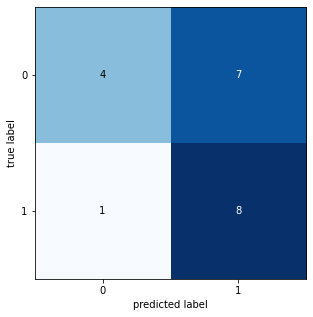

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



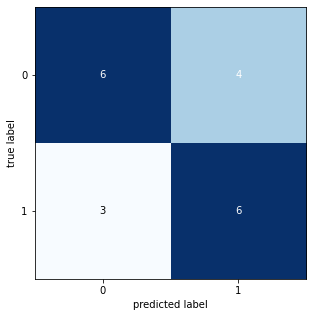

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


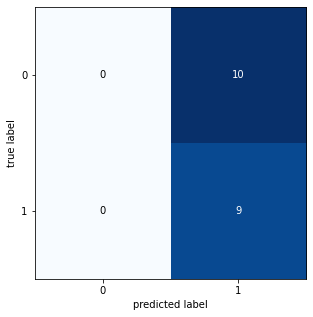

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



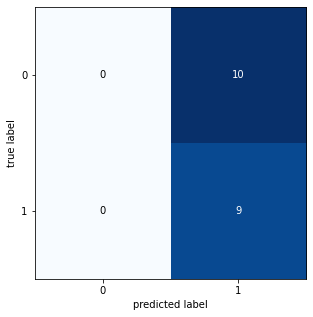

avg accuraccy Breast Cancer =  0.5257894736842106
avg F1_Score Breast Cancer =  0.43362285022902086
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.631578947368421
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.326293369005725
gen terbaik : [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
F-1 Score terbaik : 0.5521609904513716  || jumlah fitur : 60

Generation : 2
gene : [1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,

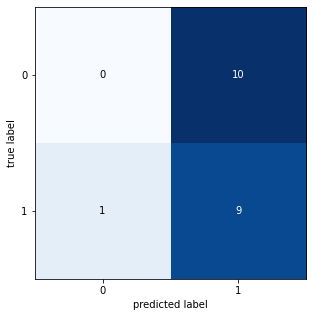

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


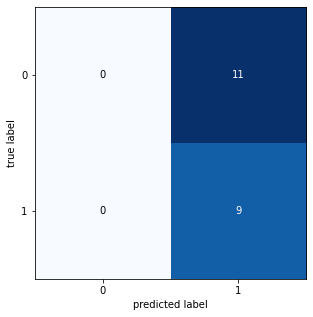

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



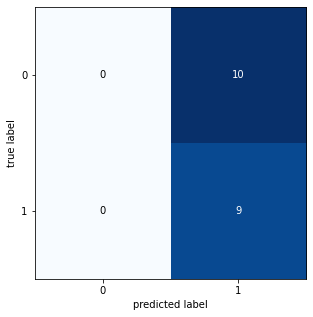

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



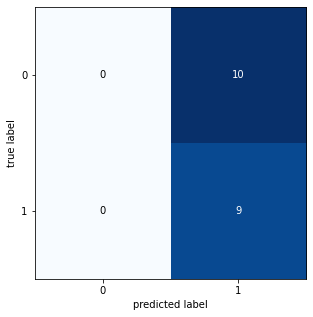

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



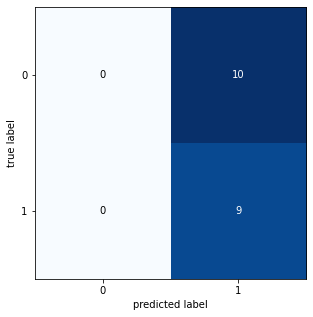

avg accuraccy Breast Cancer =  0.46421052631578946
avg F1_Score Breast Cancer =  0.3169950738916256
max accuraccy Breast Cancer =  0.47368421052631576
max F1_Score Breast Cancer =  0.32142857142857145
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  42.126762746003806
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


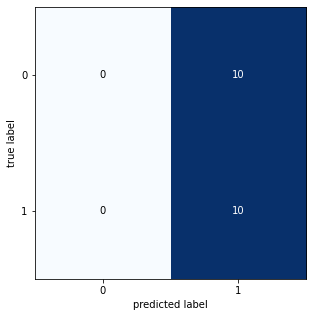

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



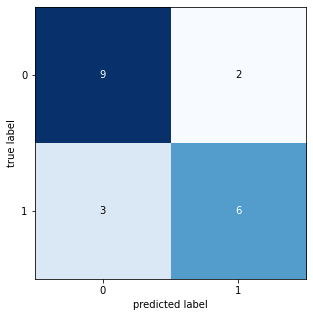

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



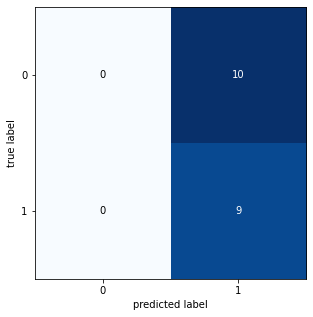

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8920454545454546
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.78      0.88         9

    accuracy                           0.89        19
   macro avg       0.92      0.89      0.89        19
weighted avg       0.91      0.89      0.89        19



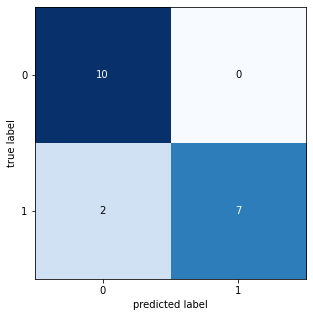

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



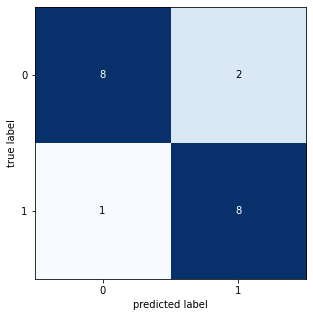

avg accuraccy Breast Cancer =  0.6921052631578947
avg F1_Score Breast Cancer =  0.6266316293523858
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8920454545454546
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.51992177500506
gene : [1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


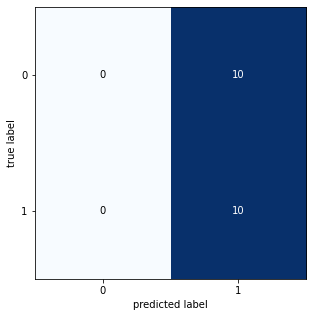

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



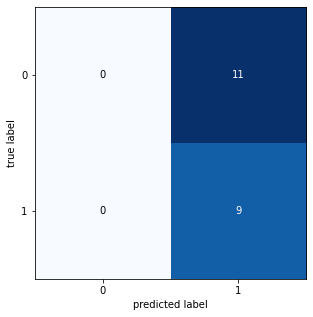

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



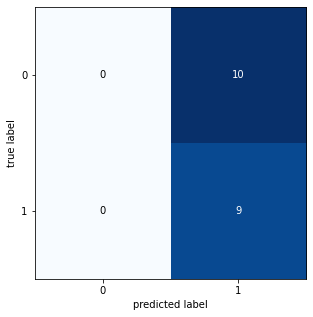

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.4242424242424242
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.50      1.00      0.67         9

    accuracy                           0.53        19
   macro avg       0.75      0.55      0.42        19
weighted avg       0.76      0.53      0.41        19



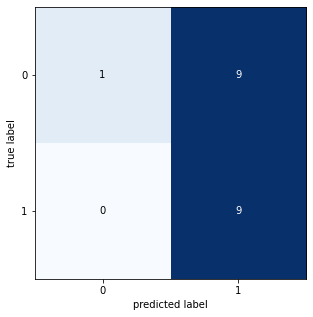

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



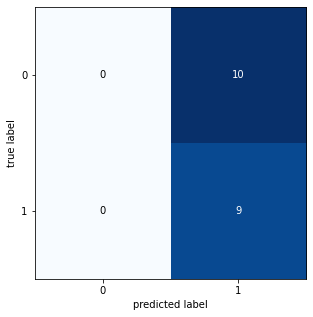

avg accuraccy Breast Cancer =  0.48473684210526313
avg F1_Score Breast Cancer =  0.34215554560382144
max accuraccy Breast Cancer =  0.5263157894736842
max F1_Score Breast Cancer =  0.4242424242424242
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.41272408100485
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


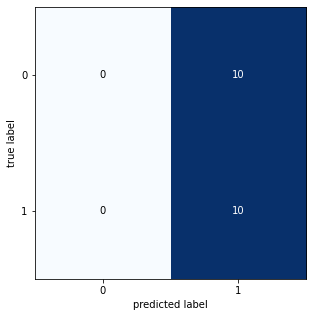

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



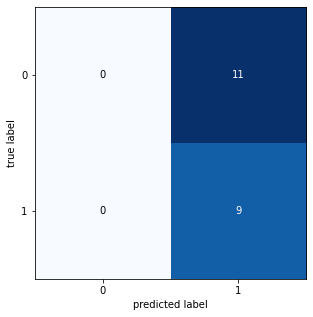

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



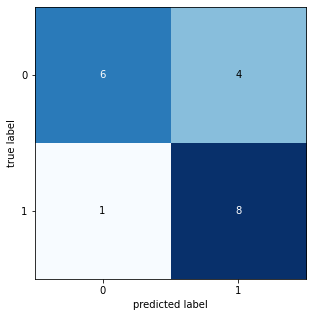

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



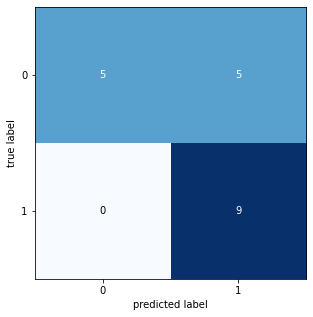

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



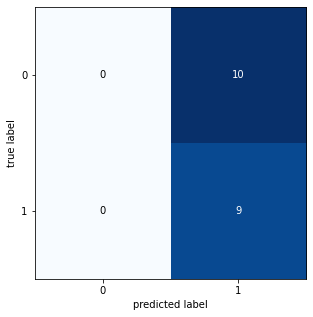

avg accuraccy Breast Cancer =  0.5794736842105264
avg F1_Score Breast Cancer =  0.48472759418610034
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.66492825200112
gene : [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

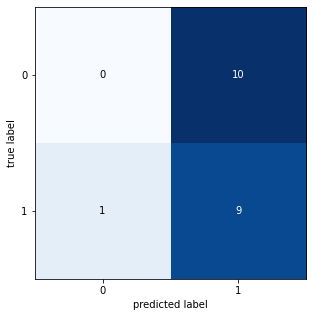

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


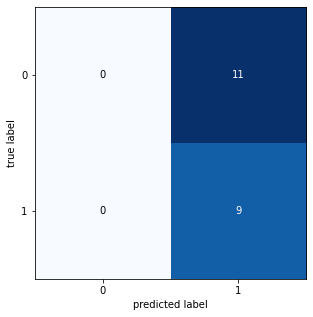

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



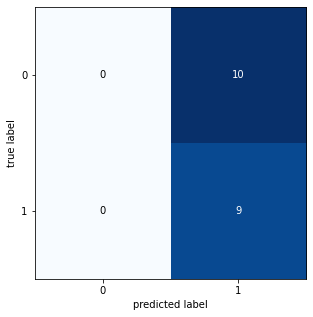

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



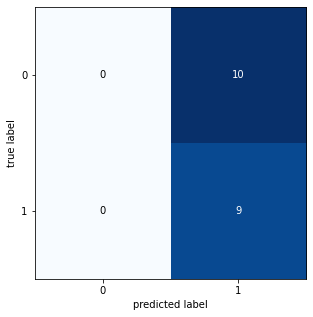

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



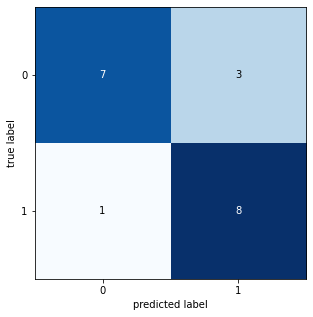

avg accuraccy Breast Cancer =  0.5273684210526316
avg F1_Score Breast Cancer =  0.41048713738368914
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.33177123700443
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

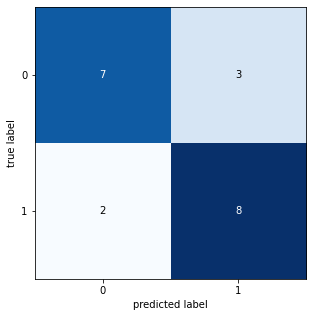

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



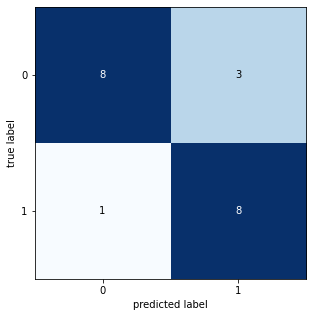

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



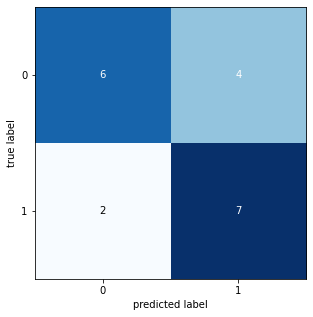

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


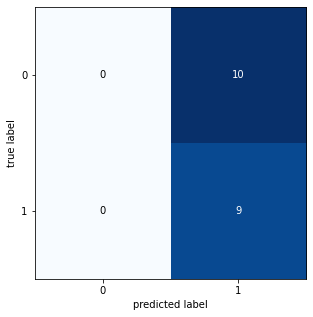

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



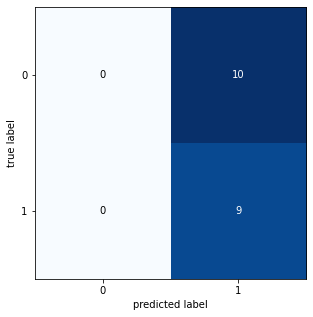

avg accuraccy Breast Cancer =  0.6363157894736843
avg F1_Score Breast Cancer =  0.5751127819548874
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.7999999999999999
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.037590086998534
gene : [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


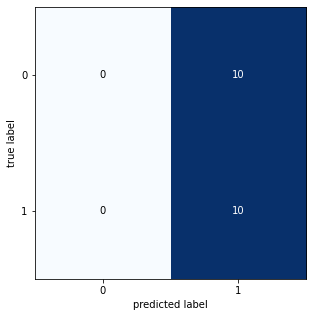

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



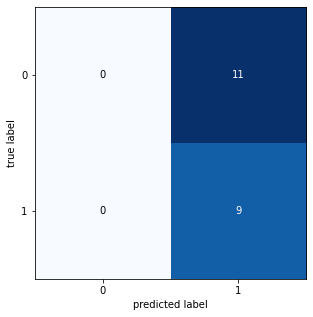

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



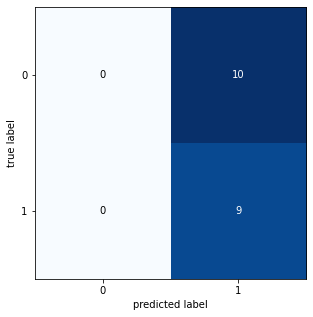

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



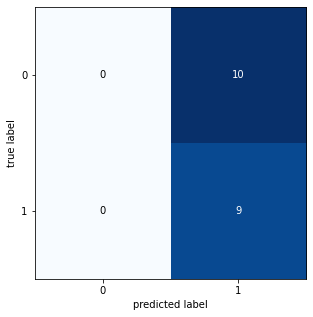

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



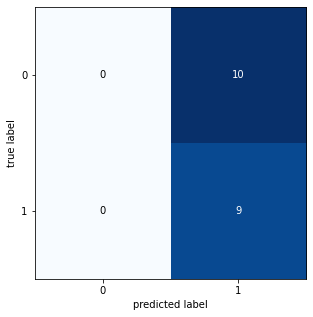

avg accuraccy Breast Cancer =  0.4742105263157894
avg F1_Score Breast Cancer =  0.3215927750410509
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.3333333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  37.58011237399478
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

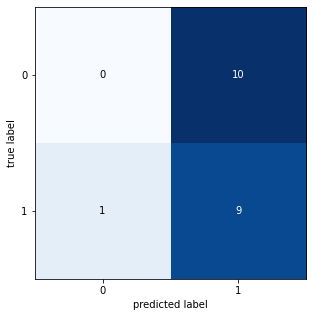

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



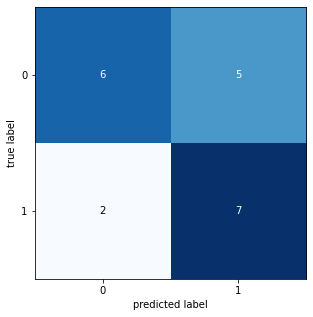

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



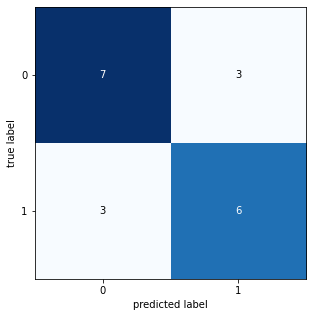

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


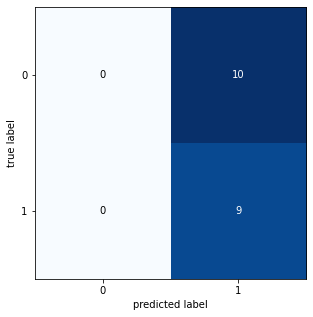

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



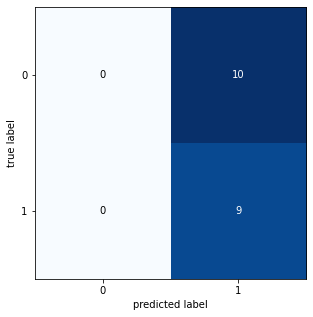

avg accuraccy Breast Cancer =  0.5463157894736843
avg F1_Score Breast Cancer =  0.4571316221588454
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.5067096970015
gene : [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


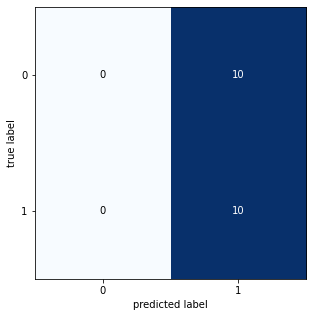

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



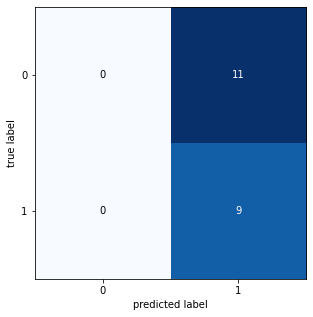

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



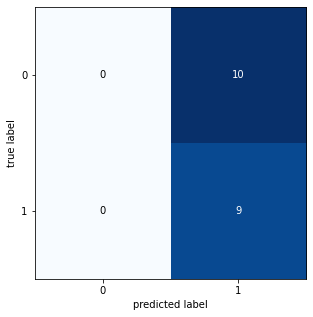

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



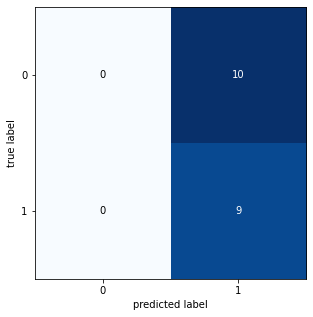

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



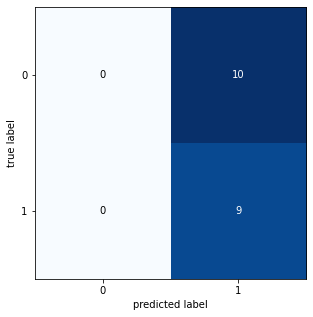

avg accuraccy Breast Cancer =  0.4742105263157894
avg F1_Score Breast Cancer =  0.3215927750410509
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.3333333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.94844181799999
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

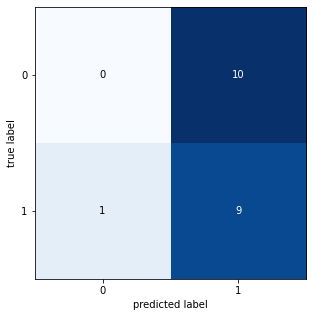

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


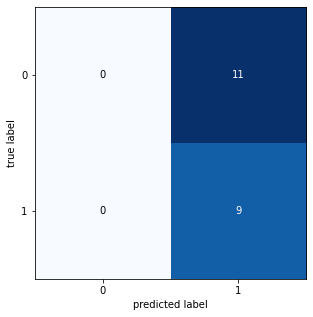

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



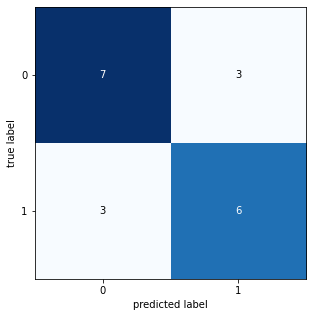

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



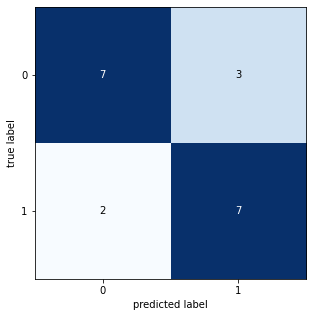

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



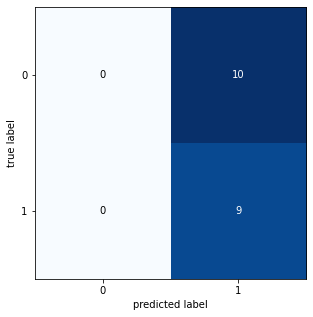

avg accuraccy Breast Cancer =  0.5589473684210526
avg F1_Score Breast Cancer =  0.47245873303949526
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.145918716996675
gen terbaik : [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
F-1 Score terbaik : 0.6266316293523858  || jumlah fitur : 56

Generation : 3
gene : [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


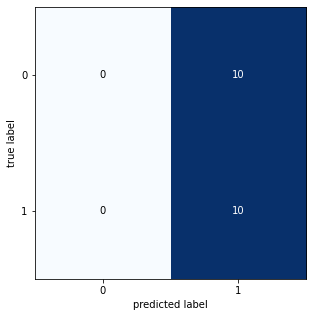

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



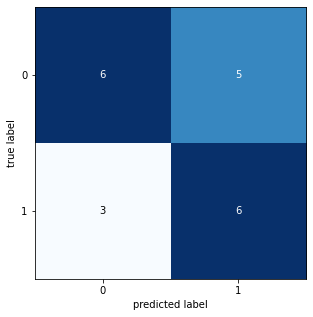

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



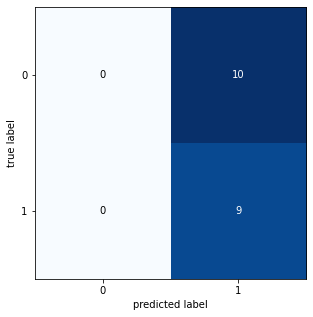

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



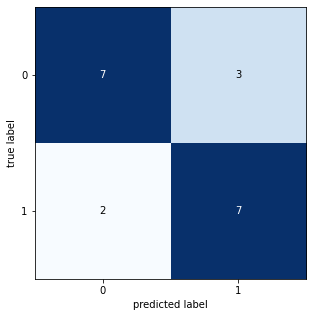

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



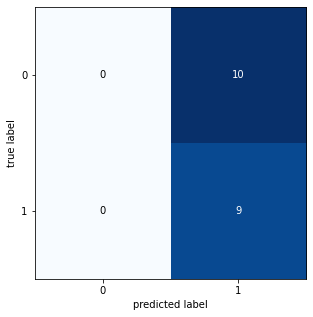

avg accuraccy Breast Cancer =  0.5568421052631579
avg F1_Score Breast Cancer =  0.4626065162907268
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.33705010799895
gene : [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

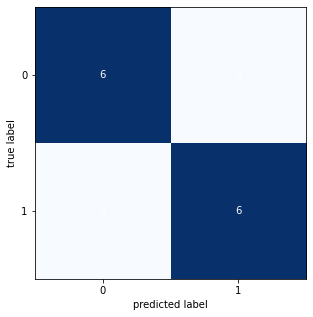

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


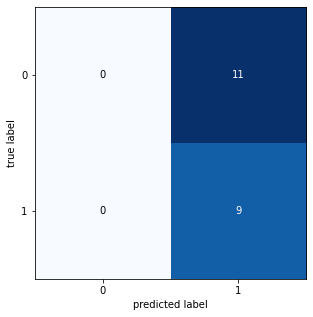

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



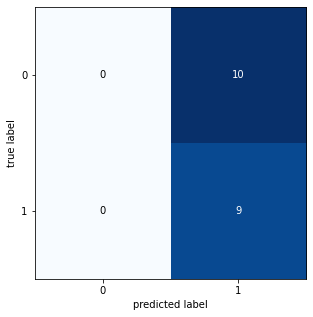

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



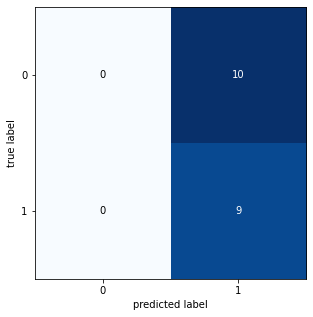

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



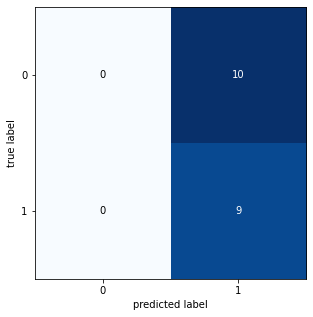

avg accuraccy Breast Cancer =  0.49421052631578943
avg F1_Score Breast Cancer =  0.3749261083743842
max accuraccy Breast Cancer =  0.6
max F1_Score Breast Cancer =  0.6
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.525496472997474
gene : [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1

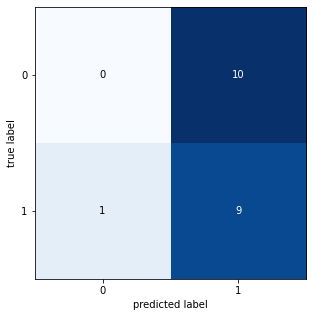

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6703296703296703
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.80      0.44      0.57         9

    accuracy                           0.70        20
   macro avg       0.73      0.68      0.67        20
weighted avg       0.73      0.70      0.68        20



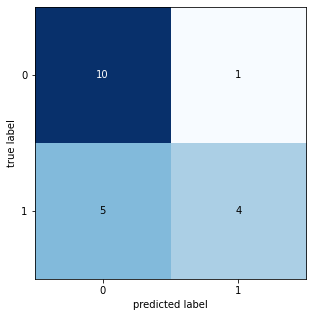

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



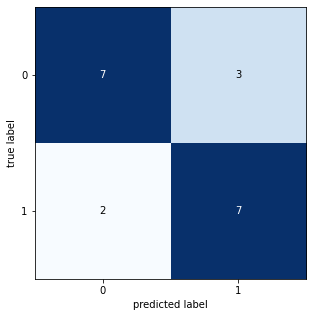

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



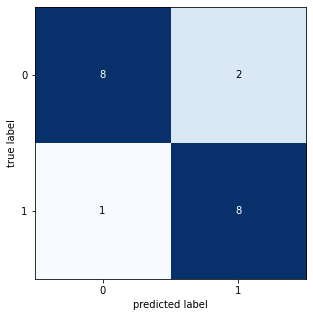

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9467787114845938
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.89      0.94         9

    accuracy                           0.95        19
   macro avg       0.95      0.94      0.95        19
weighted avg       0.95      0.95      0.95        19



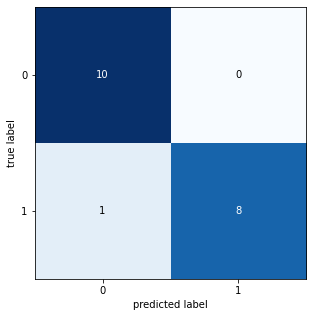

avg accuraccy Breast Cancer =  0.7352631578947368
avg F1_Score Breast Cancer =  0.7012801155643047
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9467787114845938
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.02620050299447
gene : [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

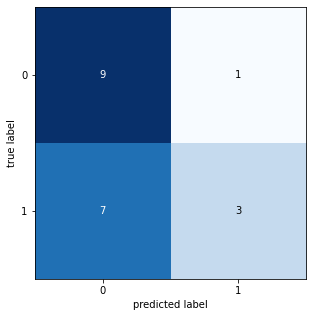

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



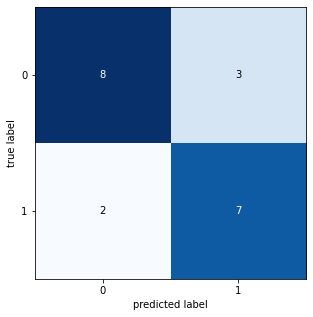

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



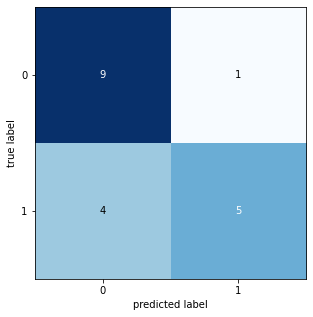

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


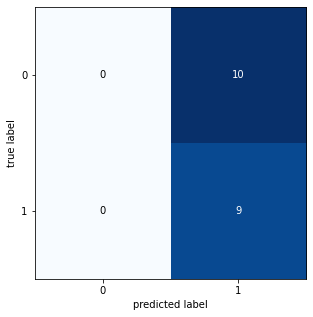

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



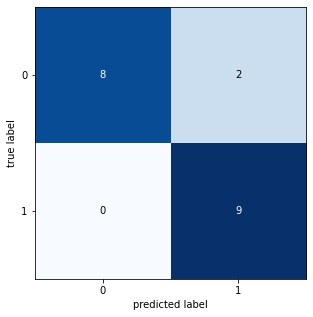

avg accuraccy Breast Cancer =  0.6910526315789475
avg F1_Score Breast Cancer =  0.6500647382111914
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.62289951900311
gene : [0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

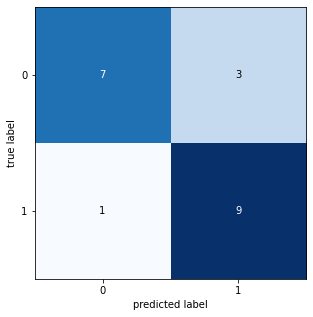

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



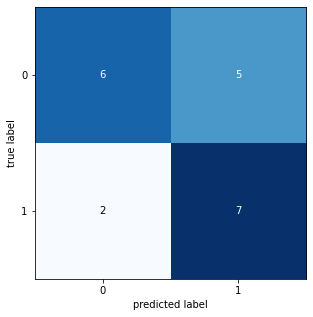

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



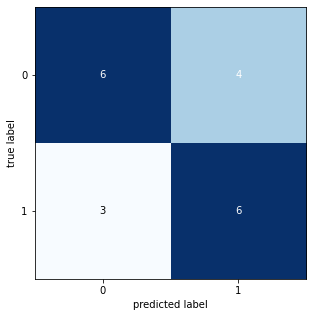

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



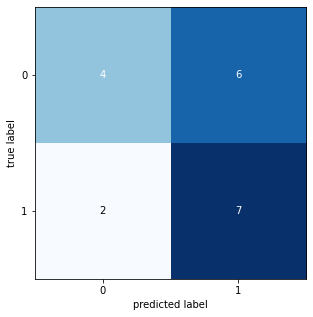

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


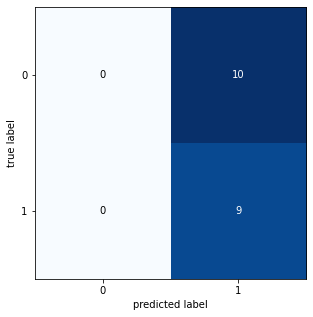

avg accuraccy Breast Cancer =  0.626842105263158
avg F1_Score Breast Cancer =  0.5936583883952304
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.80789719200402
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

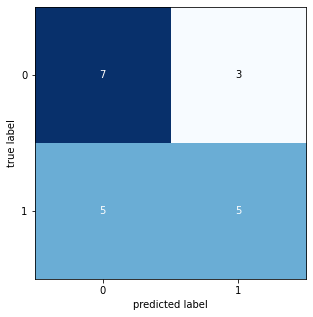

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



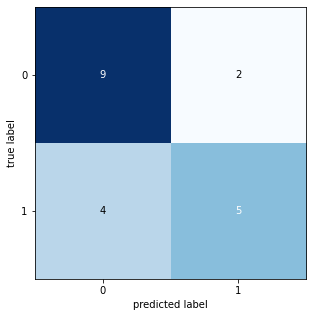

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



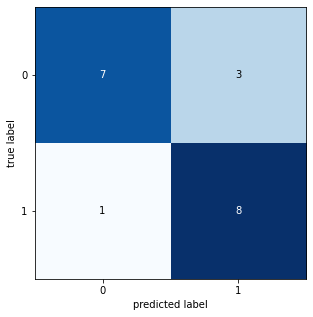

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



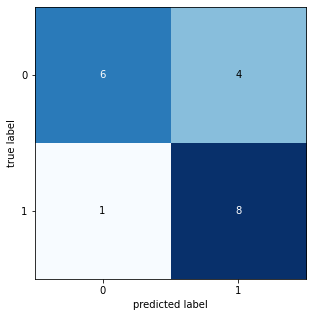

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


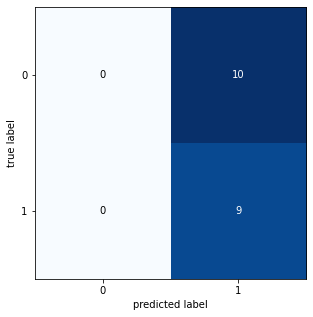

avg accuraccy Breast Cancer =  0.66
avg F1_Score Breast Cancer =  0.6255341227400051
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.7818085320032
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

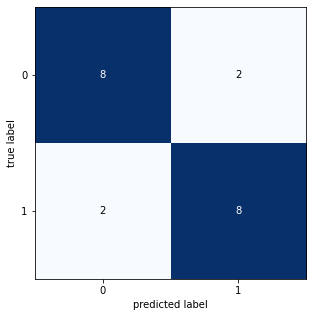

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


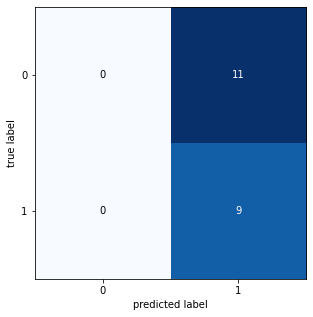

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



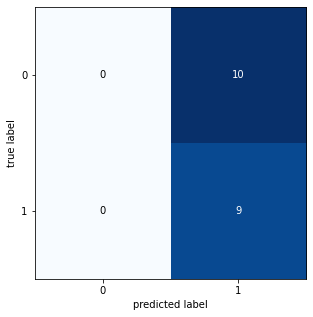

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



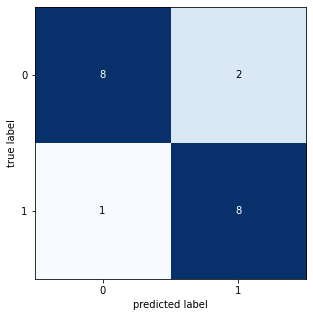

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



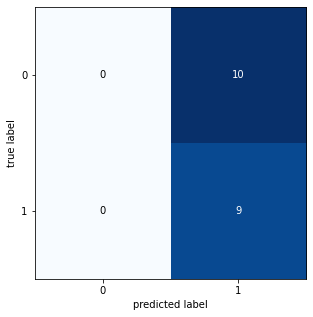

avg accuraccy Breast Cancer =  0.6078947368421053
avg F1_Score Breast Cancer =  0.519061446720249
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.015918240002065
gene : [0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

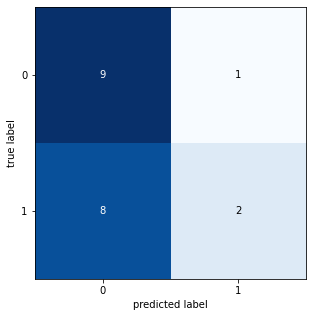

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


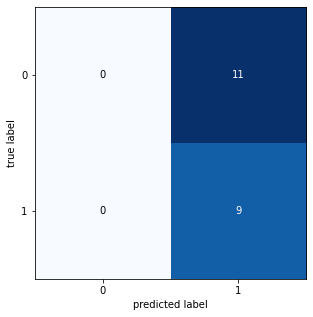

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



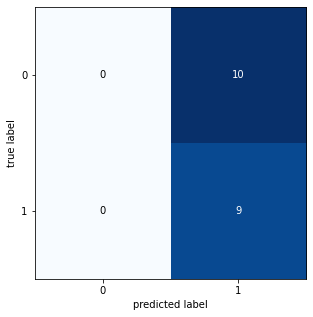

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



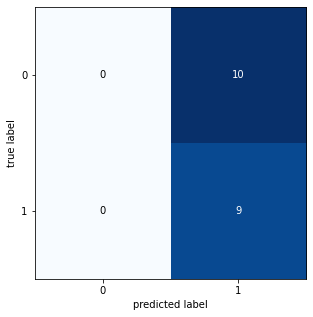

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



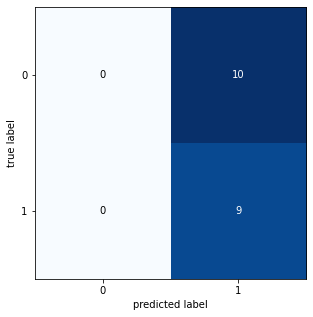

avg accuraccy Breast Cancer =  0.4842105263157895
avg F1_Score Breast Cancer =  0.35236200581028165
max accuraccy Breast Cancer =  0.55
max F1_Score Breast Cancer =  0.4871794871794872
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.31372667400137
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


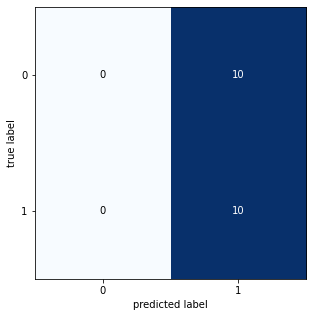

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



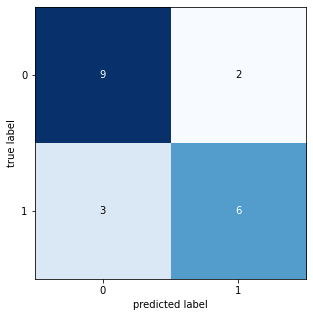

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



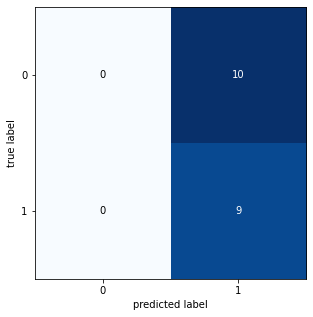

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



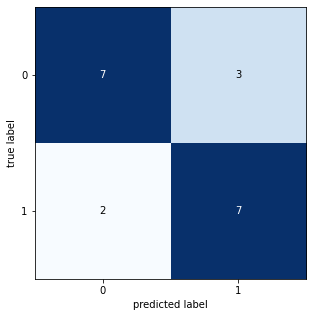

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5128205128205129
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        10
           1       0.53      1.00      0.69         9

    accuracy                           0.58        19
   macro avg       0.76      0.60      0.51        19
weighted avg       0.78      0.58      0.50        19



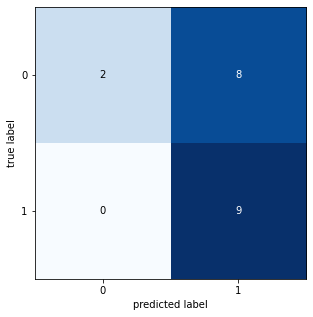

avg accuraccy Breast Cancer =  0.6078947368421053
avg F1_Score Breast Cancer =  0.5297340094284501
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966752
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.73107135100145
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

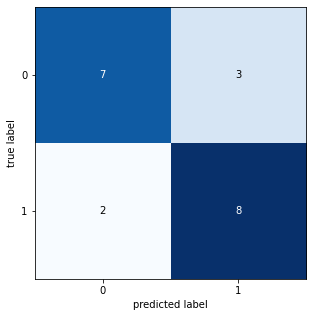

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


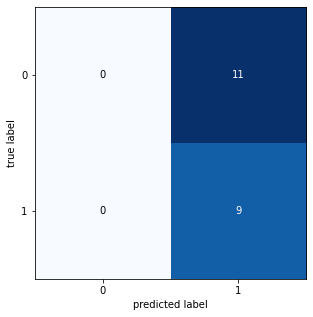

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



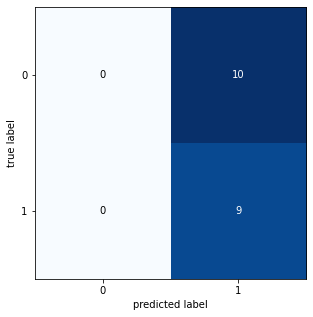

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



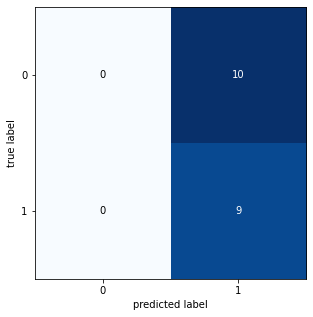

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



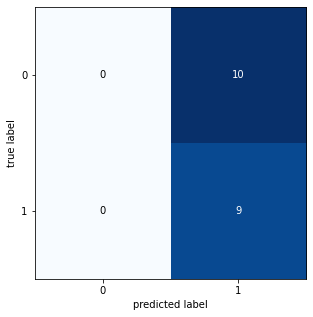

avg accuraccy Breast Cancer =  0.5242105263157895
avg F1_Score Breast Cancer =  0.40480079509117617
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.60310772700177
gen terbaik : [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
F-1 Score terbaik : 0.7012801155643047  || jumlah fitur : 63

Generation : 4
gene : [0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


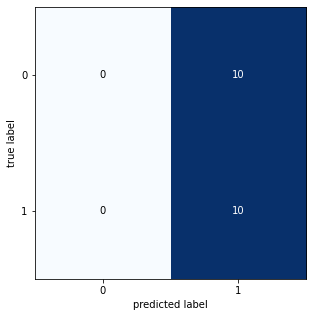

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



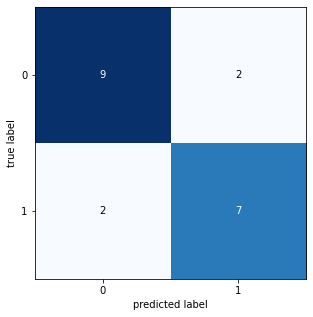

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.4242424242424242
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.50      1.00      0.67         9

    accuracy                           0.53        19
   macro avg       0.75      0.55      0.42        19
weighted avg       0.76      0.53      0.41        19



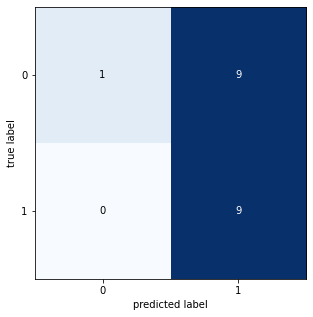

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



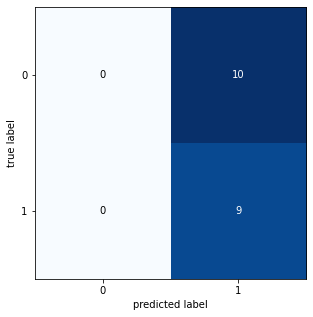

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



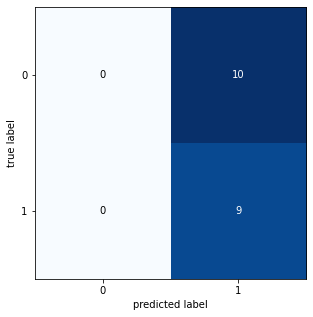

avg accuraccy Breast Cancer =  0.5547368421052632
avg F1_Score Breast Cancer =  0.4396825396825396
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.11707717500394
gene : [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


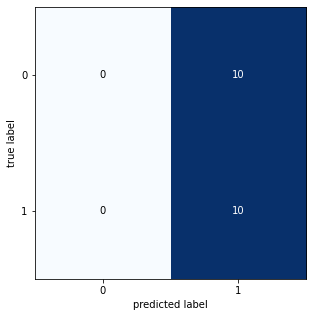

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



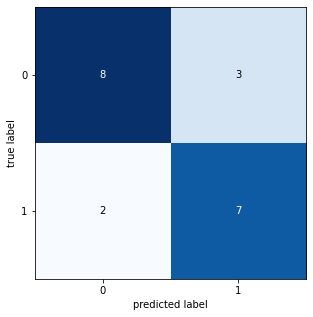

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



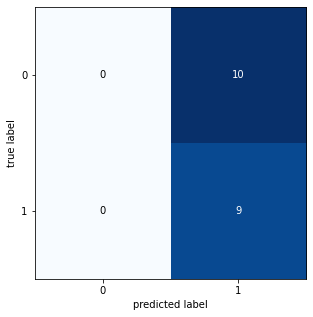

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



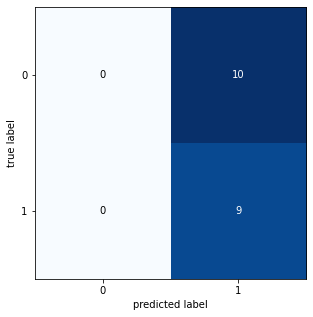

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



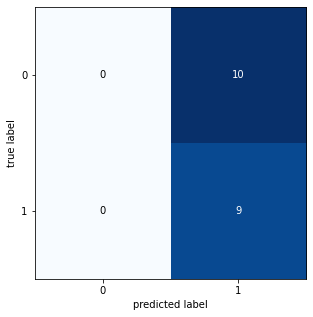

avg accuraccy Breast Cancer =  0.5342105263157895
avg F1_Score Breast Cancer =  0.40939849624060154
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.5515459629969
gene : [0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

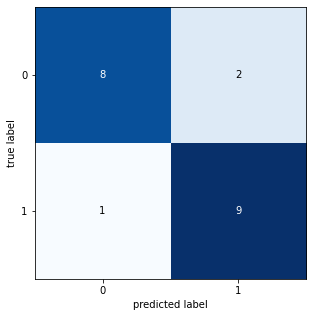

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



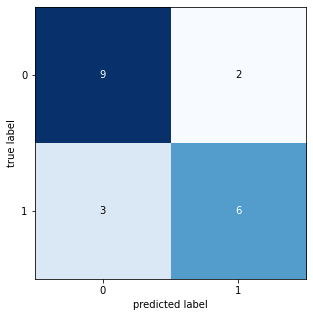

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


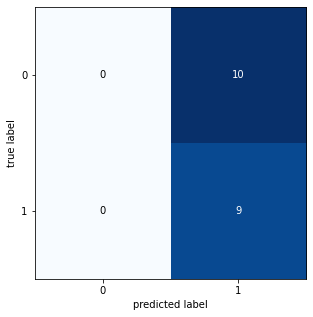

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



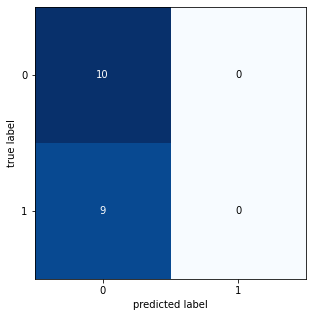

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



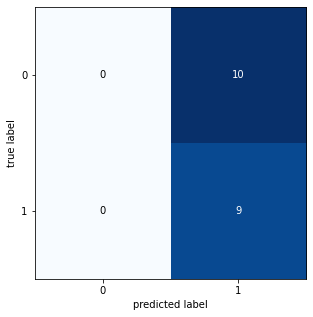

avg accuraccy Breast Cancer =  0.6147368421052632
avg F1_Score Breast Cancer =  0.5163108627022182
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.80940334699699
gene : [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


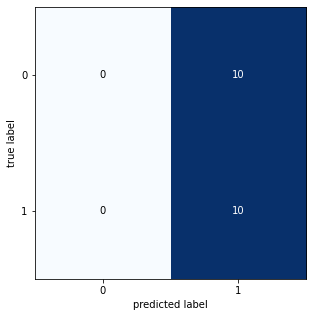

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



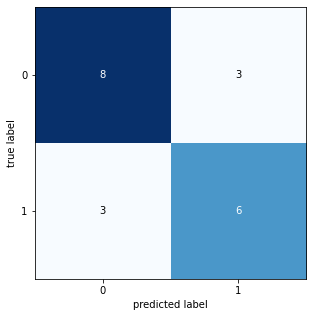

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



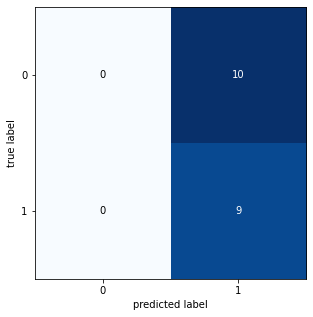

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



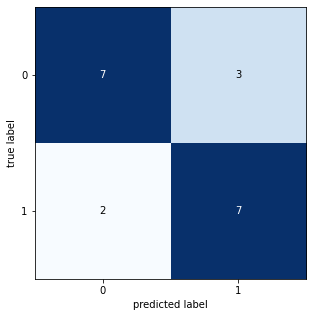

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



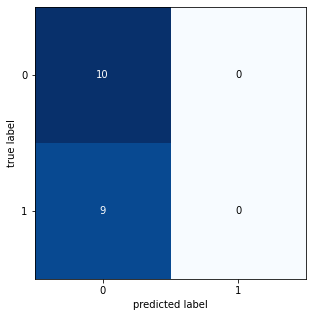

avg accuraccy Breast Cancer =  0.5873684210526315
avg F1_Score Breast Cancer =  0.48668025864033115
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.85748175199842
gene : [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1

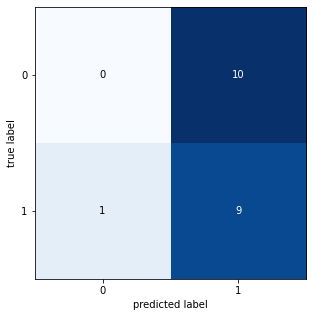

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


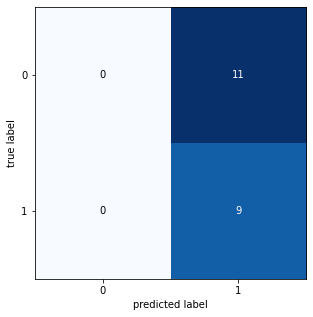

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



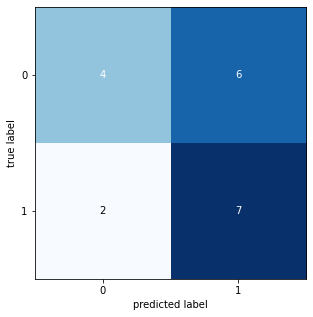

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



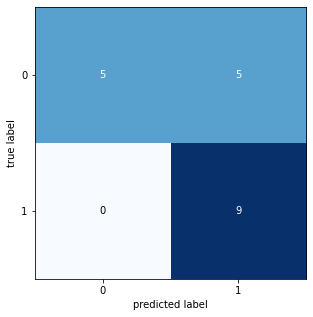

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



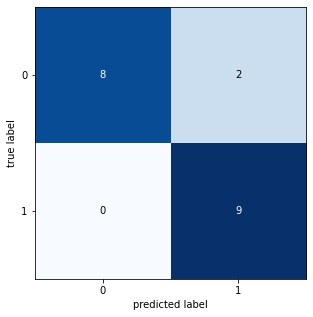

avg accuraccy Breast Cancer =  0.6221052631578947
avg F1_Score Breast Cancer =  0.5615907197916193
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.8341766980011
gene : [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

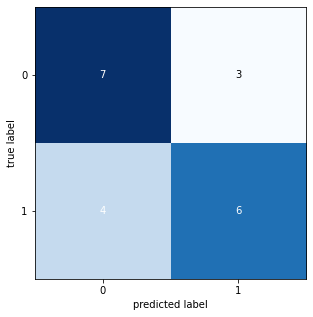

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


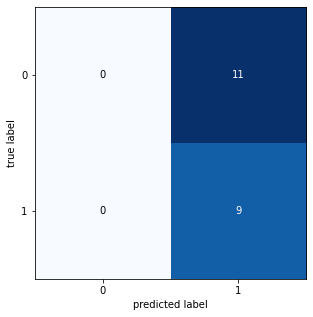

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



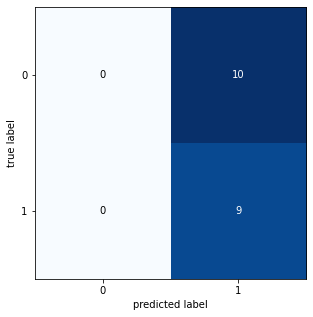

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



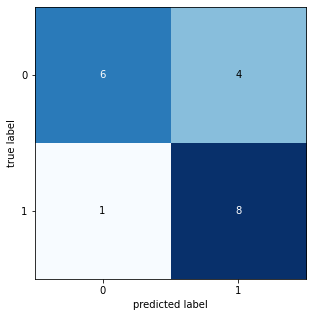

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



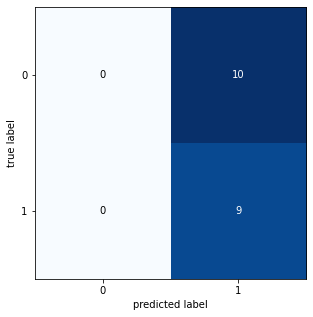

avg accuraccy Breast Cancer =  0.5568421052631579
avg F1_Score Breast Cancer =  0.4672436669767726
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.26321222799743
gene : [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

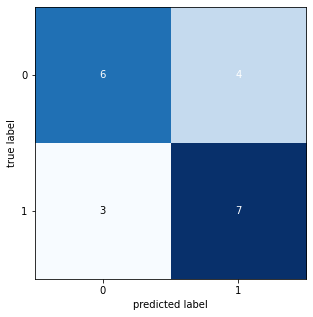

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


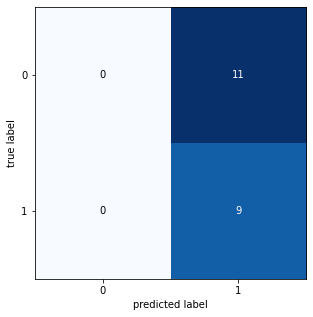

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



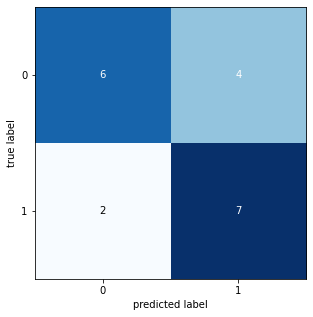

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



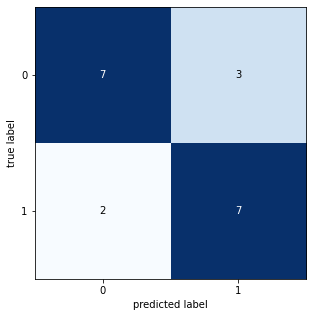

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



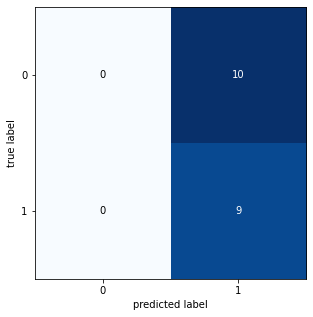

avg accuraccy Breast Cancer =  0.5989473684210527
avg F1_Score Breast Cancer =  0.5402143289257627
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.04101567699399
gene : [1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

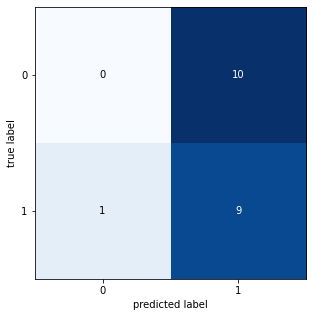

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



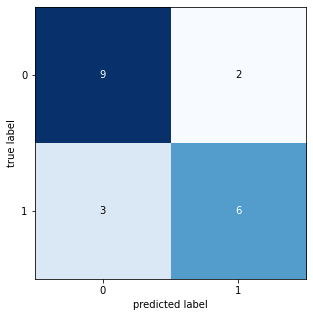

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


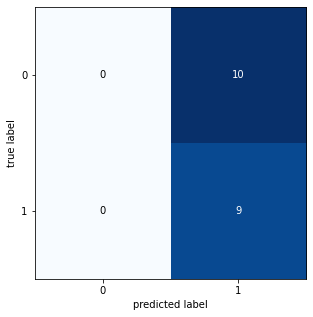

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692307
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.56      1.00      0.72         9

    accuracy                           0.63        19
   macro avg       0.78      0.65      0.59        19
weighted avg       0.79      0.63      0.58        19



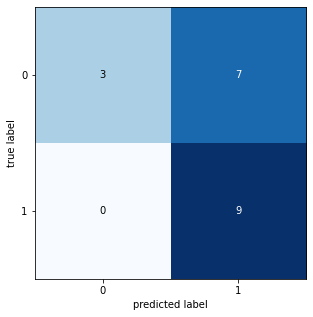

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



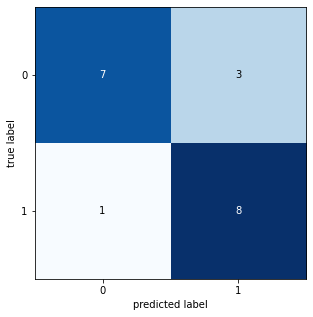

avg accuraccy Breast Cancer =  0.6189473684210526
avg F1_Score Breast Cancer =  0.5511354085939146
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.74102721999952
gene : [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


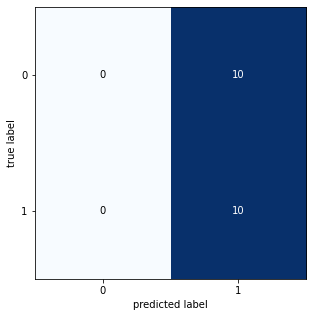

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



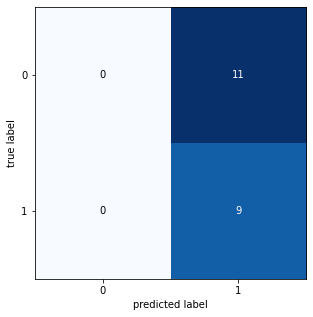

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



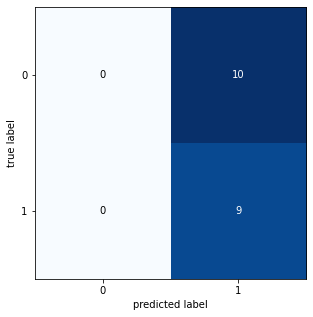

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



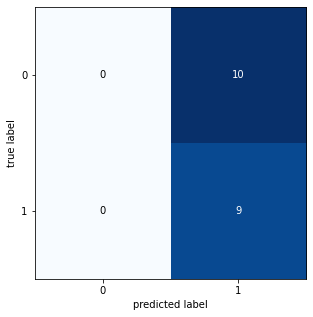

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



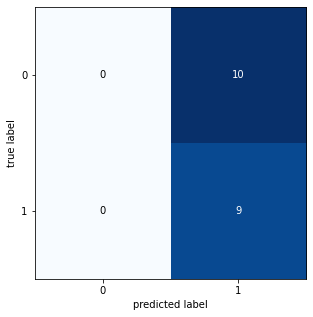

avg accuraccy Breast Cancer =  0.4742105263157894
avg F1_Score Breast Cancer =  0.3215927750410509
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.3333333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.66142152999964
gene : [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

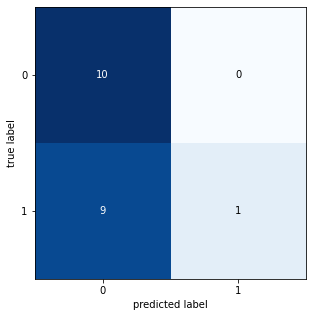

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



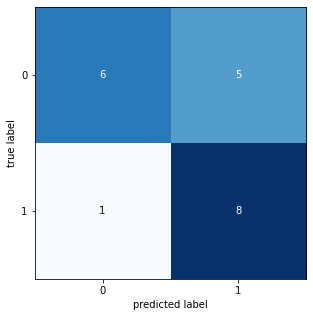

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


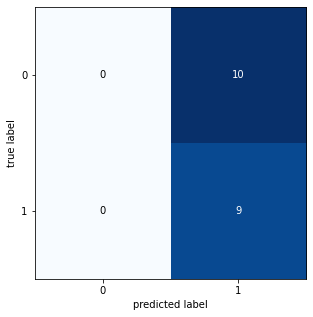

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



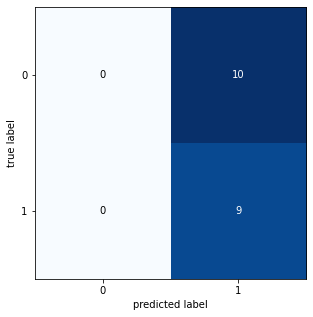

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



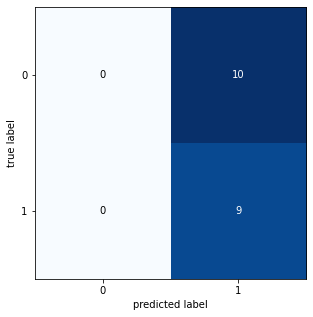

avg accuraccy Breast Cancer =  0.5342105263157895
avg F1_Score Breast Cancer =  0.41939841767427977
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.696969696969697
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.494016598997405
gen terbaik : [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]
F-1 Score terbaik : 0.5615907197916193  || jumlah fitur : 54

Running Time:  1980.2763150469982


In [13]:
Breast_IG_GA = GeneticAlgorithm(Breast_IG, 2)

Generation : 0
gene : [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


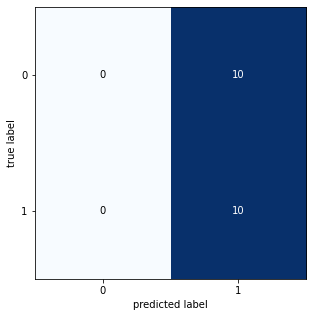

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



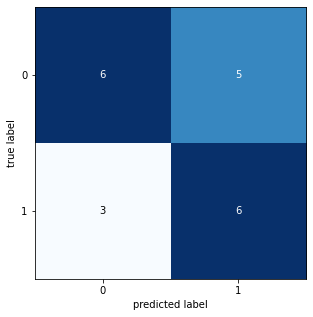

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



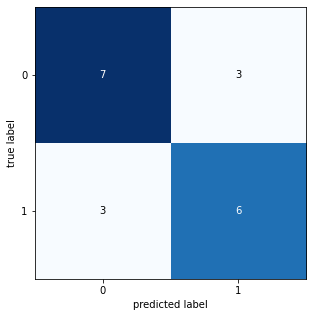

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



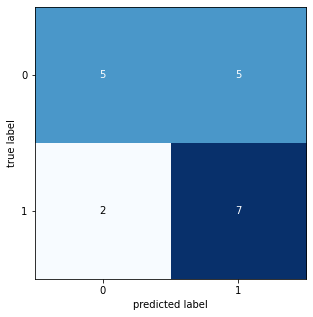

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



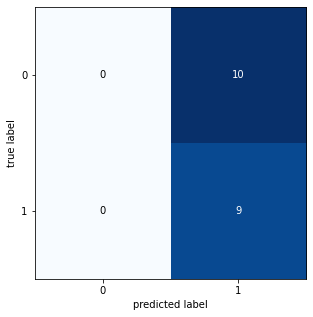

avg accuraccy Breast Cancer =  0.5778947368421052
avg F1_Score Breast Cancer =  0.513109243697479
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.99219441199966
gene : [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

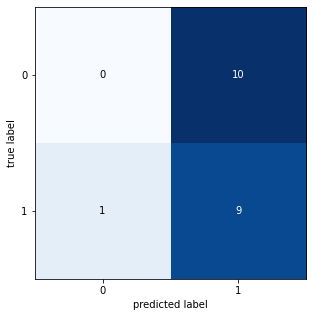

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



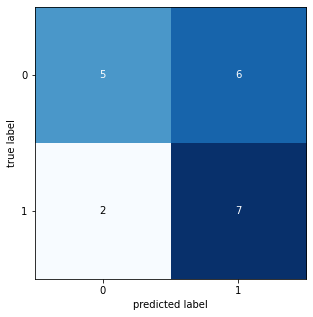

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5263157894736842
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.50      0.56      0.53         9

    accuracy                           0.53        19
   macro avg       0.53      0.53      0.53        19
weighted avg       0.53      0.53      0.53        19



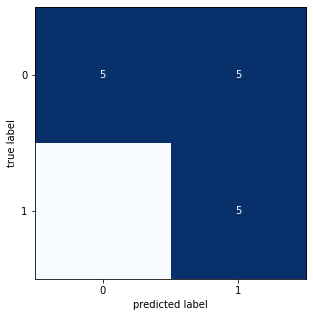

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692307
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.56      1.00      0.72         9

    accuracy                           0.63        19
   macro avg       0.78      0.65      0.59        19
weighted avg       0.79      0.63      0.58        19



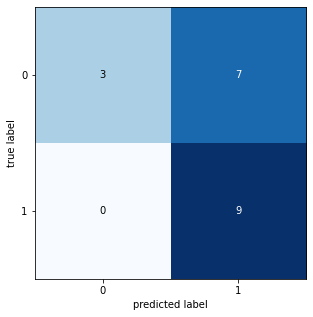

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


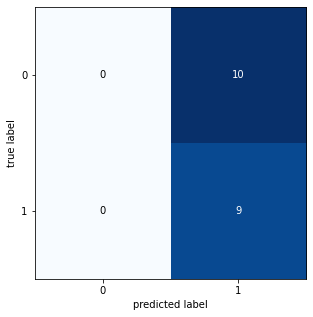

avg accuraccy Breast Cancer =  0.5363157894736842
avg F1_Score Breast Cancer =  0.46896360304345786
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.595959595959596
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.26749684699462
gene : [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

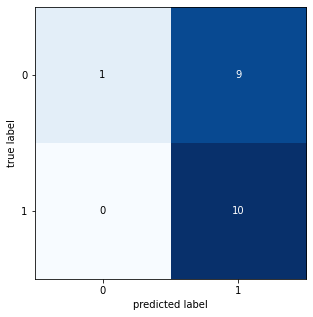

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


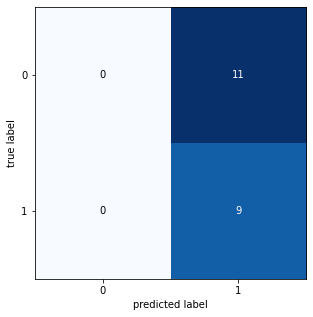

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



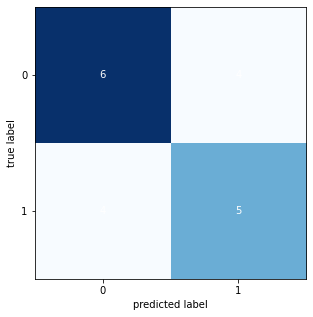

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



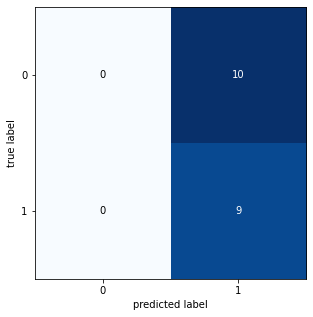

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



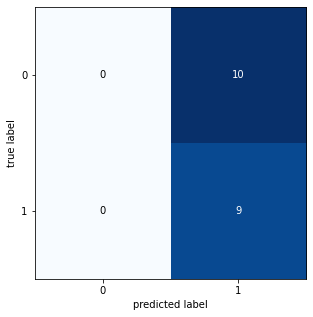

avg accuraccy Breast Cancer =  0.5052631578947369
avg F1_Score Breast Cancer =  0.393343285067423
max accuraccy Breast Cancer =  0.5789473684210527
max F1_Score Breast Cancer =  0.5777777777777777
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  42.199879649997456
gene : [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


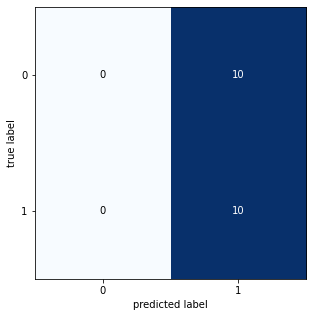

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



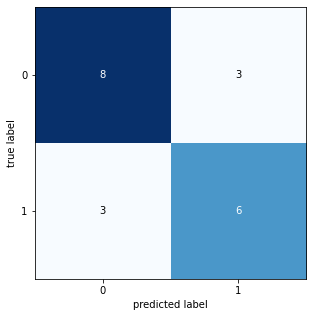

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



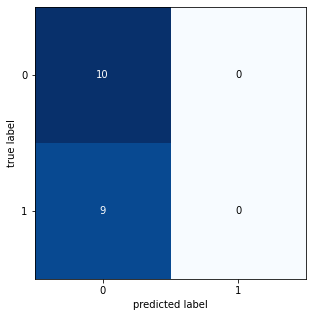

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



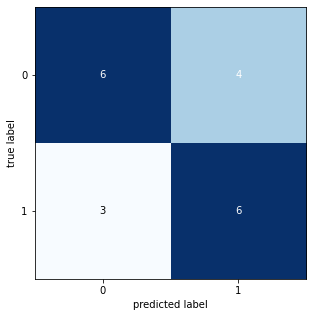

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



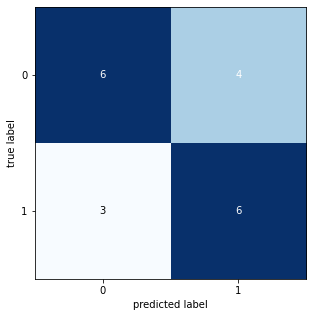

avg accuraccy Breast Cancer =  0.5978947368421054
avg F1_Score Breast Cancer =  0.5276577022493537
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.696969696969697
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.3333333333333333
Running Time:  41.30439638099779
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

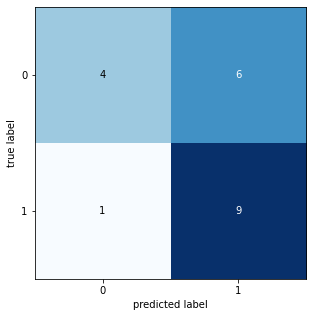

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


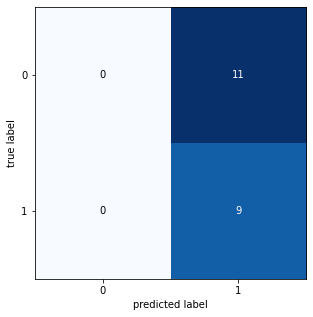

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



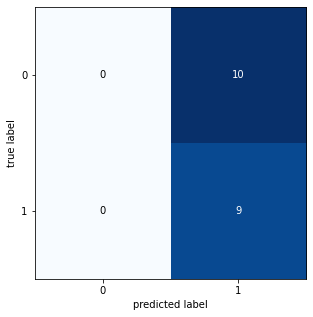

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



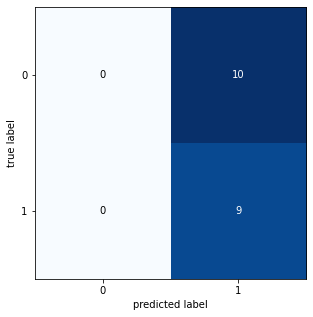

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



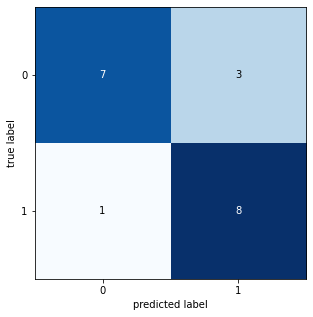

avg accuraccy Breast Cancer =  0.5673684210526316
avg F1_Score Breast Cancer =  0.47375150519978104
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.51547929200024
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

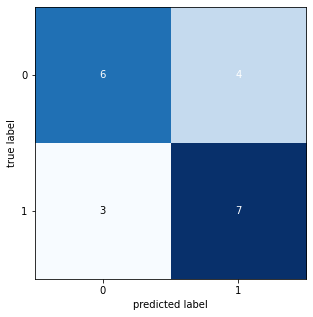

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


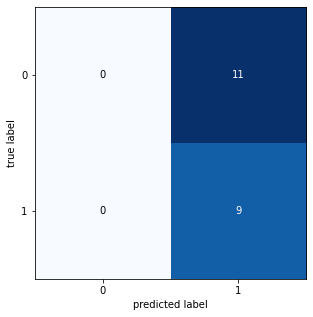

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



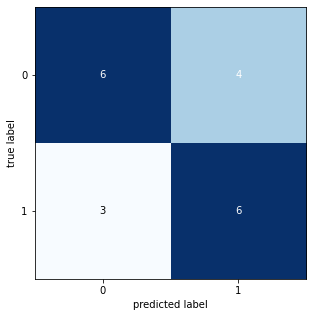

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



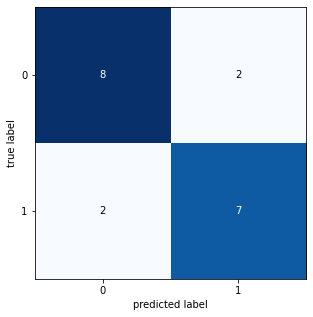

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



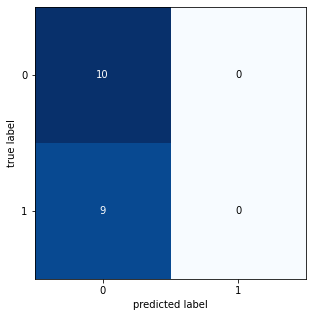

avg accuraccy Breast Cancer =  0.6094736842105263
avg F1_Score Breast Cancer =  0.5449526114135915
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  37.976739835001354
gene : [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


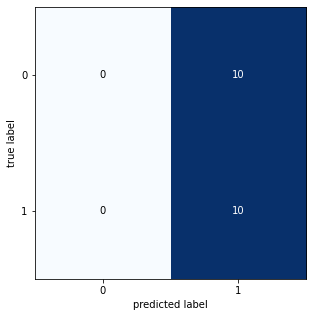

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



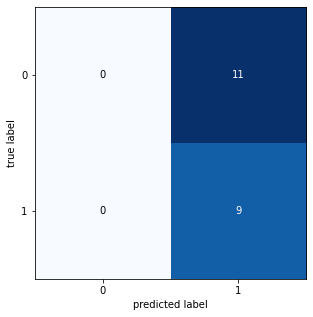

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



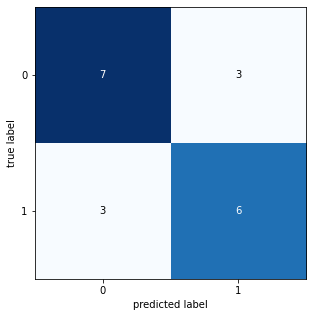

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



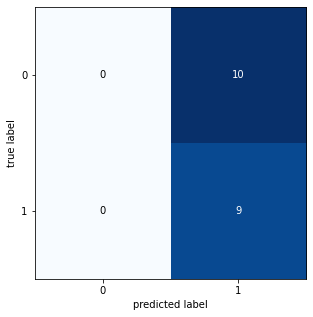

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



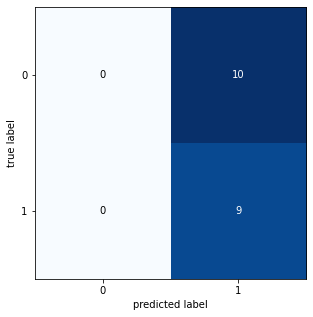

avg accuraccy Breast Cancer =  0.5163157894736843
avg F1_Score Breast Cancer =  0.39397372742200326
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.596699588000774
gene : [1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

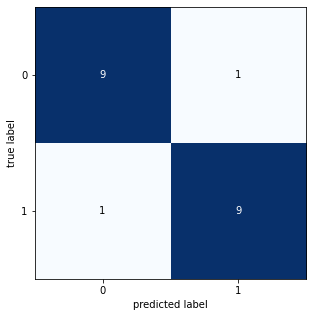

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



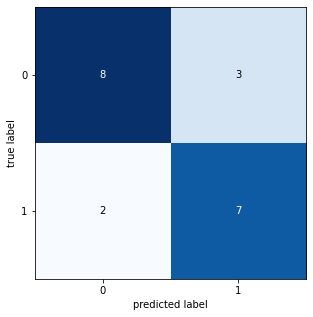

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


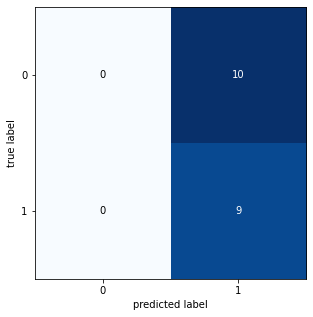

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



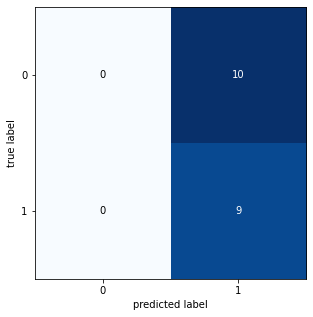

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



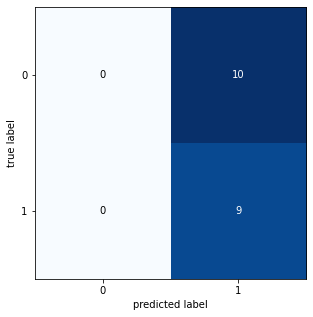

avg accuraccy Breast Cancer =  0.6142105263157895
avg F1_Score Breast Cancer =  0.5227318295739349
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.9
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.472000314999605
gene : [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


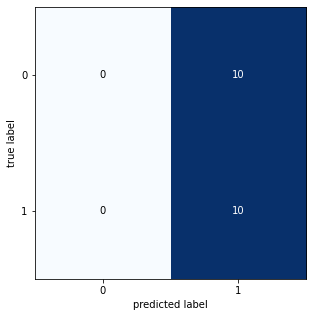

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



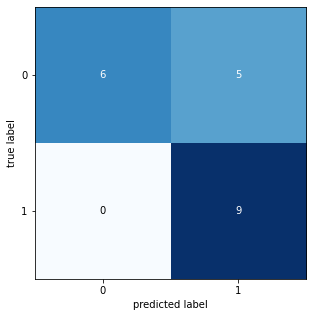

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613445
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.50      0.44      0.47         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



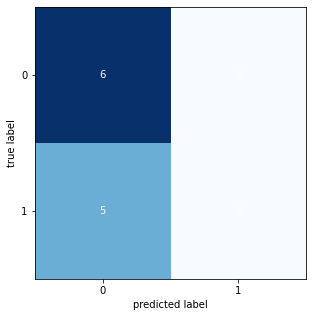

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



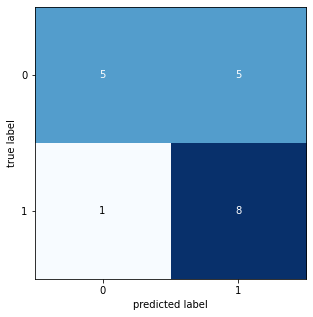

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5476190476190477
              precision    recall  f1-score   support

           0       0.75      0.30      0.43        10
           1       0.53      0.89      0.67         9

    accuracy                           0.58        19
   macro avg       0.64      0.59      0.55        19
weighted avg       0.65      0.58      0.54        19



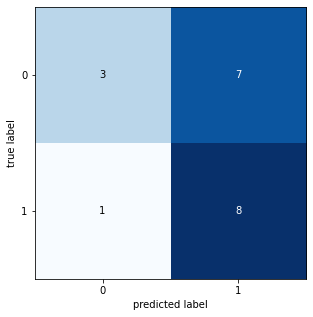

avg accuraccy Breast Cancer =  0.6078947368421053
avg F1_Score Breast Cancer =  0.5644685344493527
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966752
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.3333333333333333
Running Time:  40.65648437300115
gene : [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


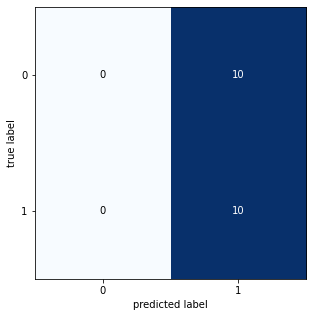

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



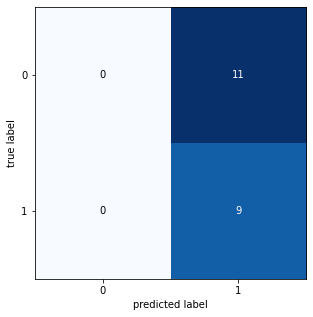

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



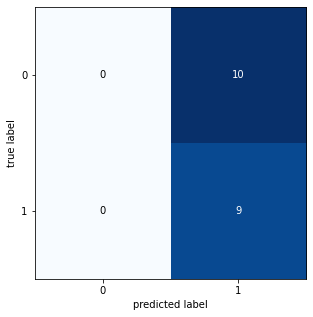

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



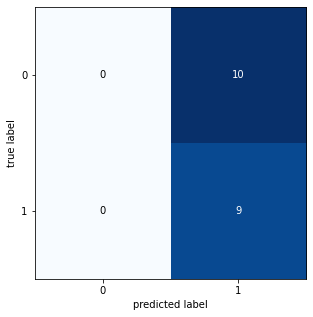

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



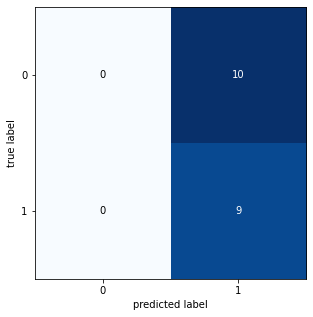

avg accuraccy Breast Cancer =  0.4742105263157894
avg F1_Score Breast Cancer =  0.3215927750410509
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.3333333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.82185910100088
gen terbaik : [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.5644685344493527  || jumlah fitur : 50

Generation : 1
gene : [1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


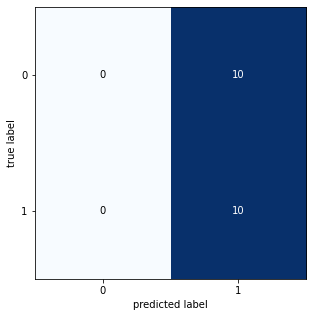

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



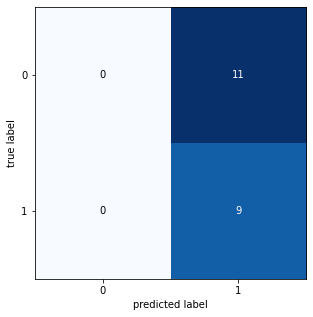

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



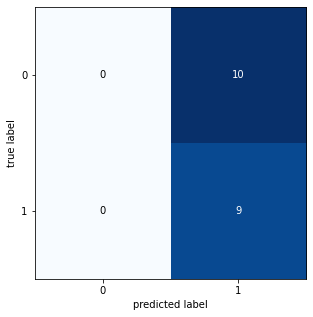

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



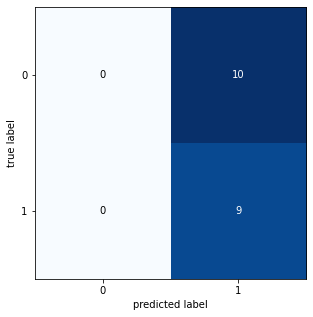

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



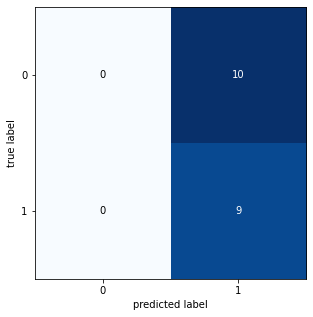

avg accuraccy Breast Cancer =  0.4742105263157894
avg F1_Score Breast Cancer =  0.3215927750410509
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.3333333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.05640134999703
gene : [0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


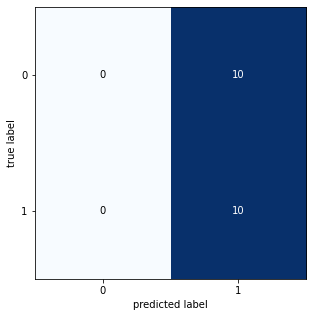

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



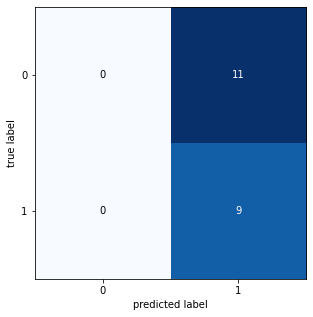

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.42424242424242425
              precision    recall  f1-score   support

           0       0.53      0.90      0.67        10
           1       0.50      0.11      0.18         9

    accuracy                           0.53        19
   macro avg       0.51      0.51      0.42        19
weighted avg       0.52      0.53      0.44        19



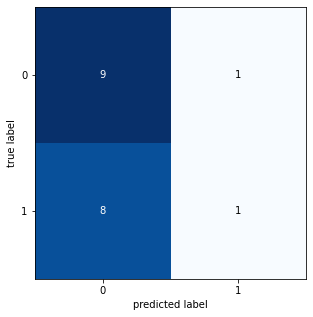

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692307
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.56      1.00      0.72         9

    accuracy                           0.63        19
   macro avg       0.78      0.65      0.59        19
weighted avg       0.79      0.63      0.58        19



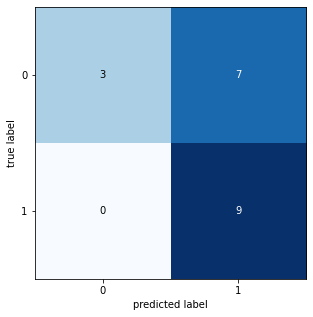

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



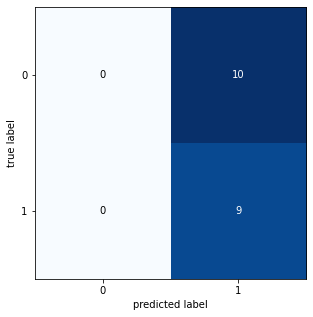

avg accuraccy Breast Cancer =  0.5163157894736843
avg F1_Score Breast Cancer =  0.39602367747195333
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.5907692307692307
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.916012839996256
gene : [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


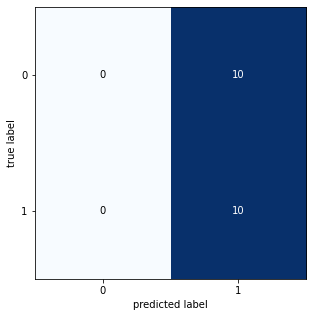

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.60      1.00      0.75         9

    accuracy                           0.70        20
   macro avg       0.80      0.73      0.69        20
weighted avg       0.82      0.70      0.68        20



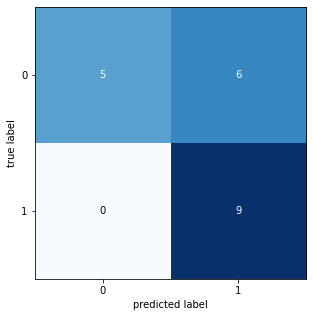

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5476190476190476
              precision    recall  f1-score   support

           0       0.57      0.80      0.67        10
           1       0.60      0.33      0.43         9

    accuracy                           0.58        19
   macro avg       0.59      0.57      0.55        19
weighted avg       0.58      0.58      0.55        19



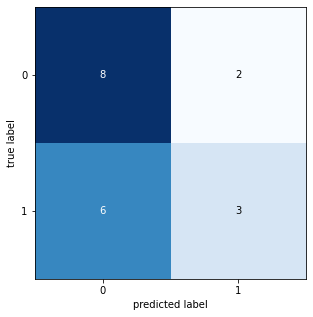

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.42105263157894735
F1_Score :  0.2962962962962963
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.44      0.89      0.59         9

    accuracy                           0.42        19
   macro avg       0.22      0.44      0.30        19
weighted avg       0.21      0.42      0.28        19



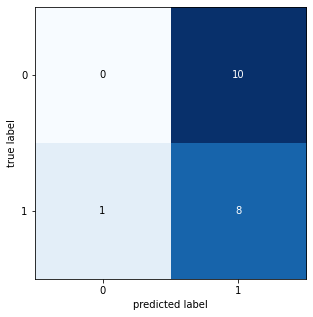

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



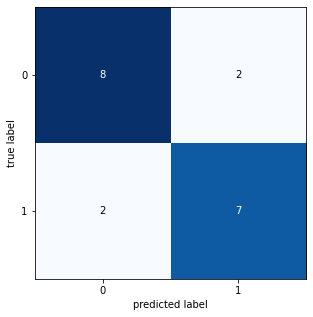

avg accuraccy Breast Cancer =  0.5978947368421054
avg F1_Score Breast Cancer =  0.5307275132275132
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.42105263157894735
min F1_Score Breast Cancer =  0.2962962962962963
Running Time:  40.01126885700069
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

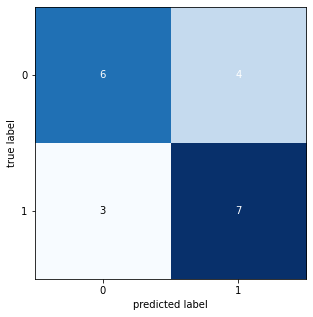

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



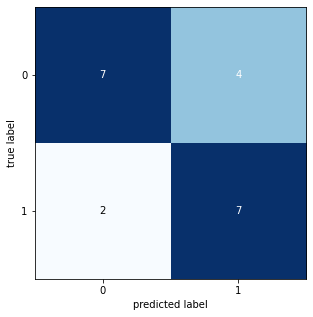

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


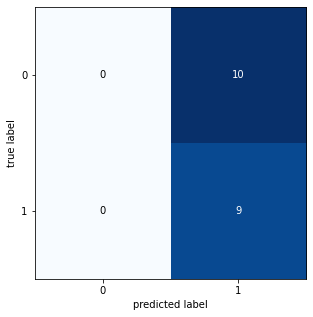

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



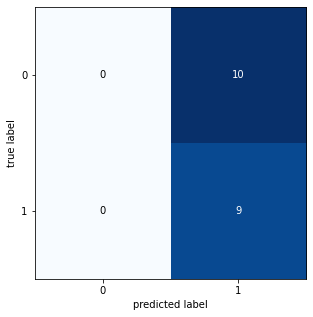

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



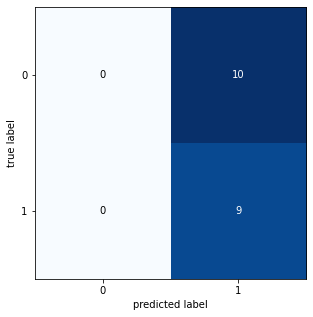

avg accuraccy Breast Cancer =  0.5542105263157895
avg F1_Score Breast Cancer =  0.46268170426065164
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.7000000000000001
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  42.568878416997904
gene : [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


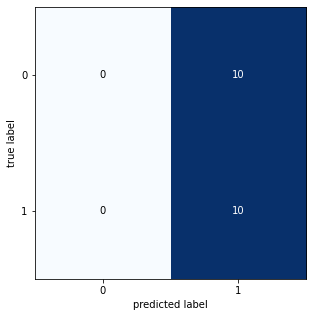

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



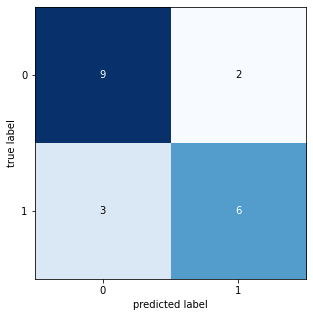

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



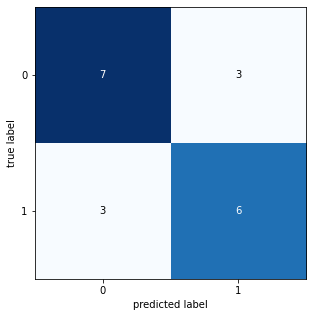

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



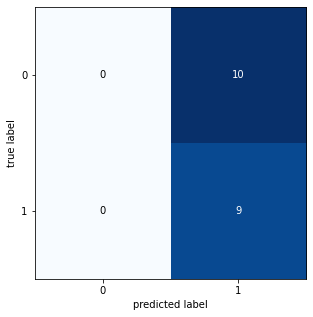

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



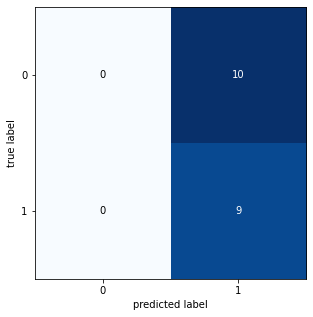

avg accuraccy Breast Cancer =  0.5763157894736842
avg F1_Score Breast Cancer =  0.48075386676409704
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966752
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.67922109099891
gene : [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

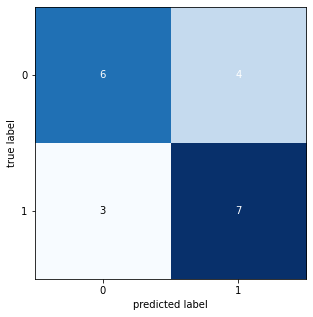

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



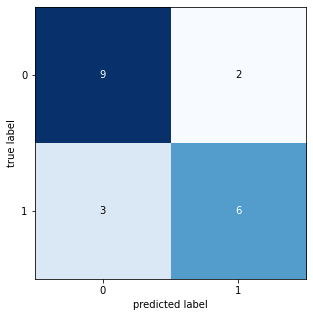

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


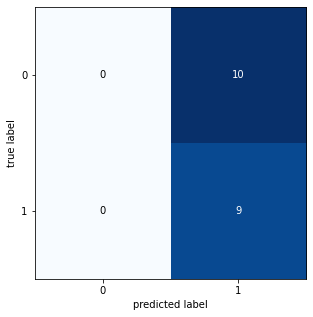

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692307
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.56      1.00      0.72         9

    accuracy                           0.63        19
   macro avg       0.78      0.65      0.59        19
weighted avg       0.79      0.63      0.58        19



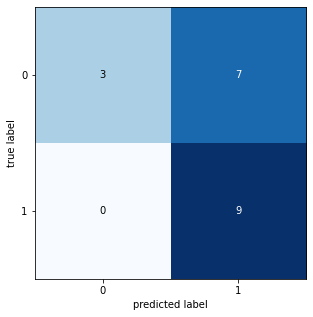

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



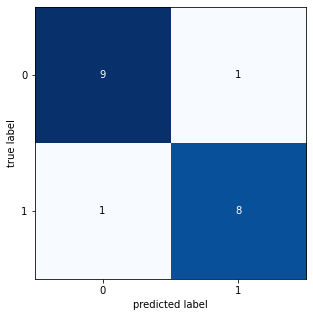

avg accuraccy Breast Cancer =  0.6799999999999999
avg F1_Score Breast Cancer =  0.6400021155912932
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.79782368000451
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


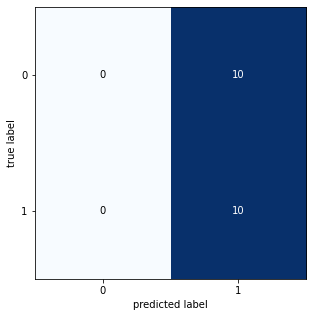

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5238095238095238
              precision    recall  f1-score   support

           0       0.59      0.91      0.71        11
           1       0.67      0.22      0.33         9

    accuracy                           0.60        20
   macro avg       0.63      0.57      0.52        20
weighted avg       0.62      0.60      0.54        20



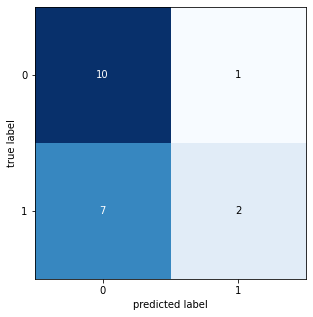

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



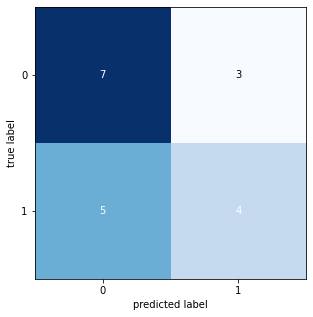

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



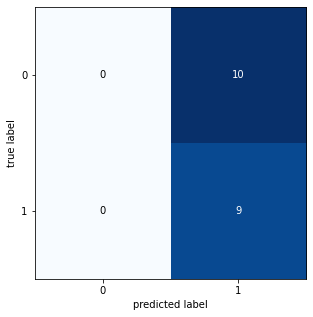

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



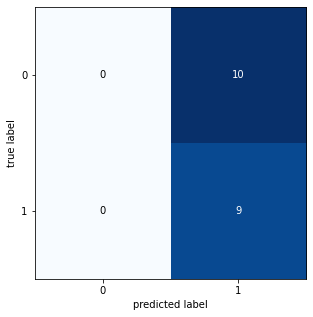

avg accuraccy Breast Cancer =  0.5252631578947369
avg F1_Score Breast Cancer =  0.4136363636363637
max accuraccy Breast Cancer =  0.6
max F1_Score Breast Cancer =  0.5681818181818182
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.50000092899427
gene : [0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


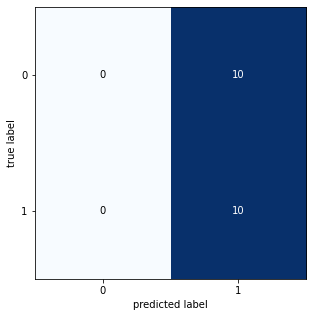

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



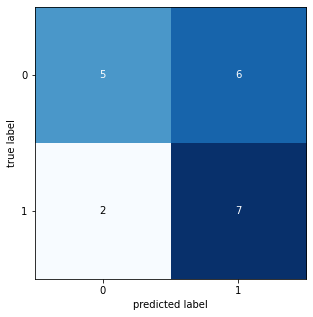

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



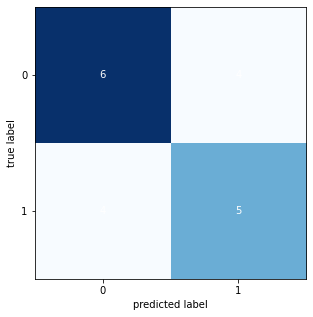

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



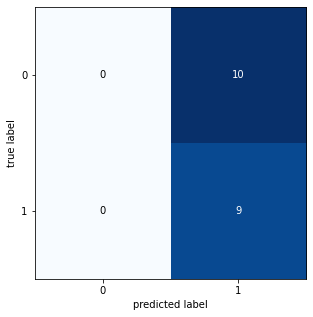

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



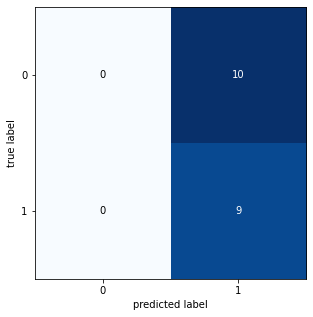

avg accuraccy Breast Cancer =  0.5252631578947369
avg F1_Score Breast Cancer =  0.42998556998556997
max accuraccy Breast Cancer =  0.6
max F1_Score Breast Cancer =  0.595959595959596
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.795504235997214
gene : [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

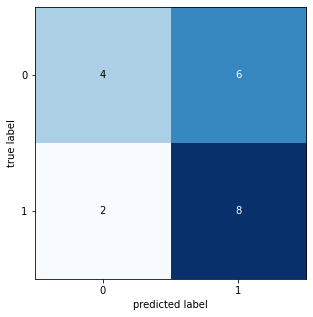

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.715099715099715
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       1.00      0.44      0.62         9

    accuracy                           0.75        20
   macro avg       0.84      0.72      0.72        20
weighted avg       0.83      0.75      0.73        20



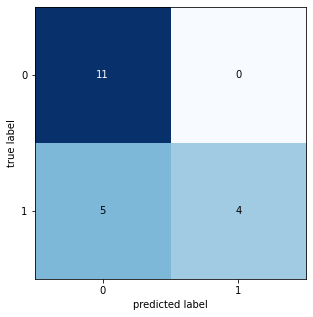

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


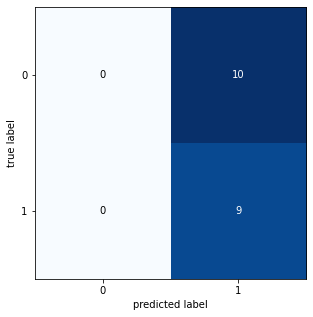

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692307
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.56      1.00      0.72         9

    accuracy                           0.63        19
   macro avg       0.78      0.65      0.59        19
weighted avg       0.79      0.63      0.58        19



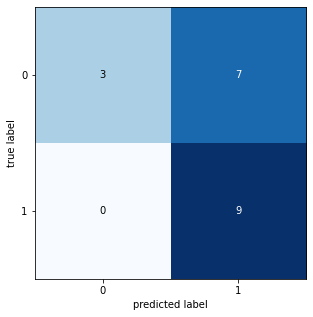

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



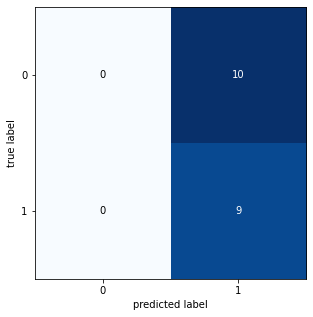

avg accuraccy Breast Cancer =  0.5857894736842105
avg F1_Score Breast Cancer =  0.5064118844118843
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.715099715099715
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.463078122003935
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

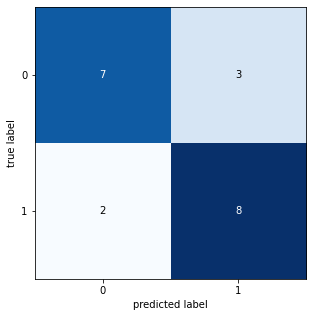

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


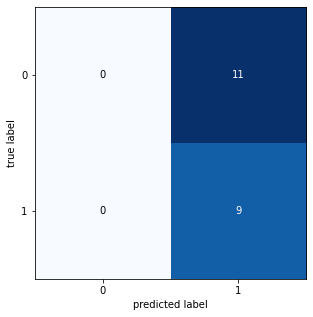

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



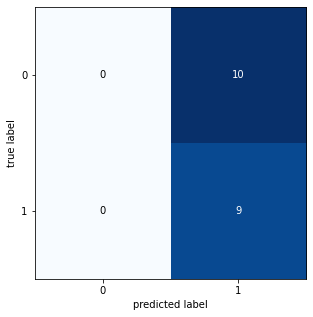

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



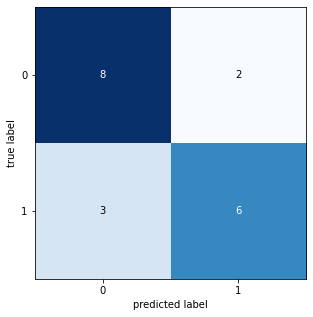

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



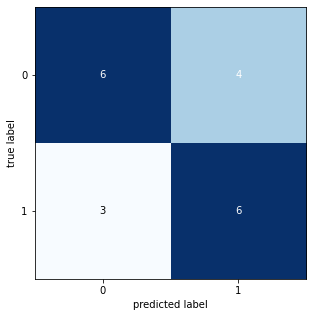

avg accuraccy Breast Cancer =  0.608421052631579
avg F1_Score Breast Cancer =  0.5493238674780256
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.196713204000844
gen terbaik : [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.6400021155912932  || jumlah fitur : 45

Generation : 2
gene : [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1

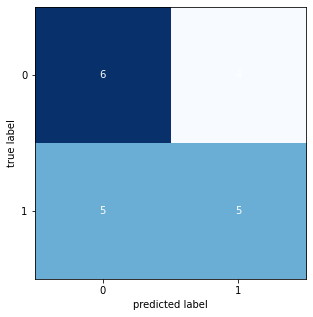

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


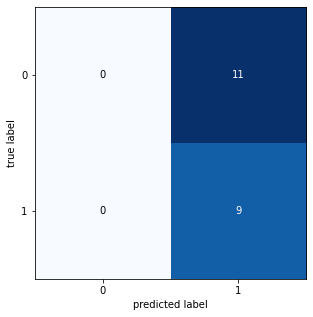

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



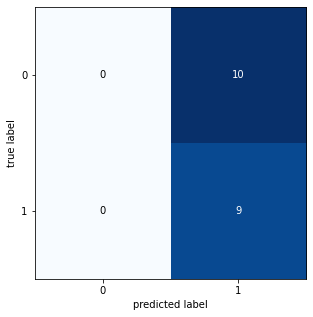

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



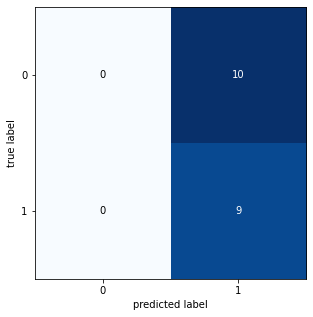

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



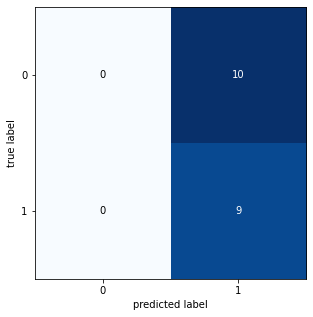

avg accuraccy Breast Cancer =  0.4842105263157895
avg F1_Score Breast Cancer =  0.36470054446460975
max accuraccy Breast Cancer =  0.55
max F1_Score Breast Cancer =  0.5488721804511277
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.298023804003606
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

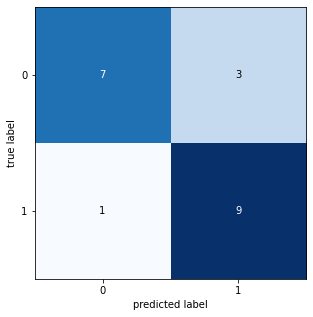

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.60      1.00      0.75         9

    accuracy                           0.70        20
   macro avg       0.80      0.73      0.69        20
weighted avg       0.82      0.70      0.68        20



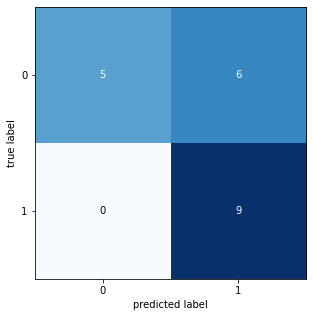

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.42424242424242425
              precision    recall  f1-score   support

           0       0.53      0.90      0.67        10
           1       0.50      0.11      0.18         9

    accuracy                           0.53        19
   macro avg       0.51      0.51      0.42        19
weighted avg       0.52      0.53      0.44        19



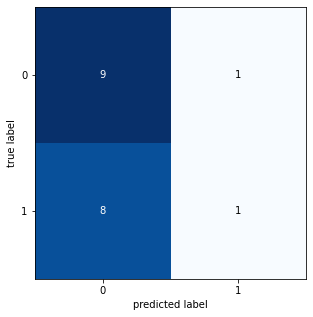

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



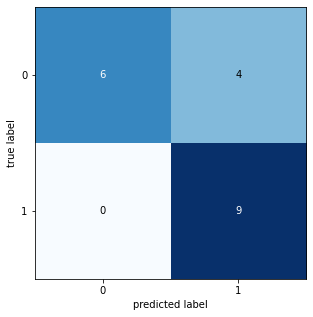

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


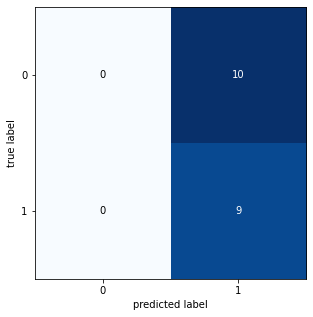

avg accuraccy Breast Cancer =  0.6578947368421053
avg F1_Score Breast Cancer =  0.6030483405483407
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.334769111999776
gene : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

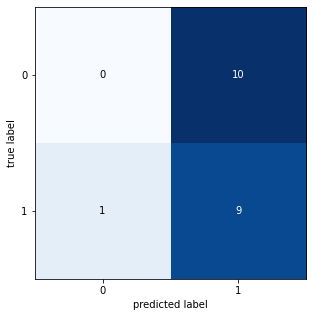

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



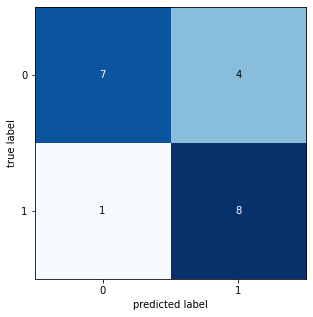

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



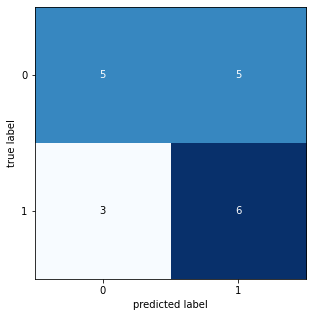

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


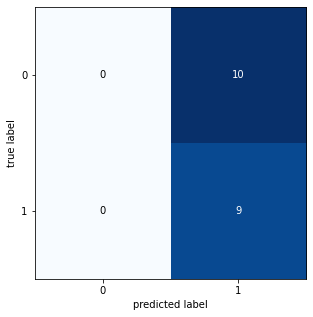

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8920454545454546
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.78      0.88         9

    accuracy                           0.89        19
   macro avg       0.92      0.89      0.89        19
weighted avg       0.91      0.89      0.89        19



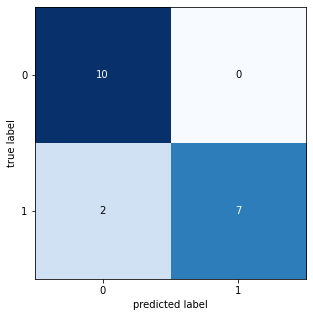

avg accuraccy Breast Cancer =  0.6294736842105263
avg F1_Score Breast Cancer =  0.5701940129843941
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8920454545454546
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.07554464699933
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


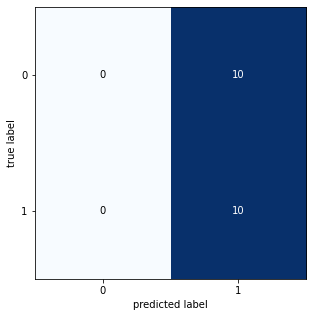

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



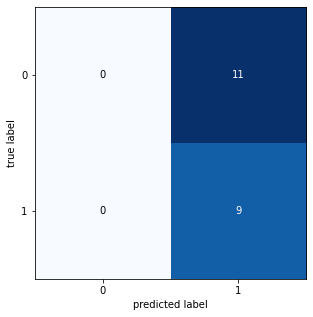

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5263157894736842
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.50      0.56      0.53         9

    accuracy                           0.53        19
   macro avg       0.53      0.53      0.53        19
weighted avg       0.53      0.53      0.53        19



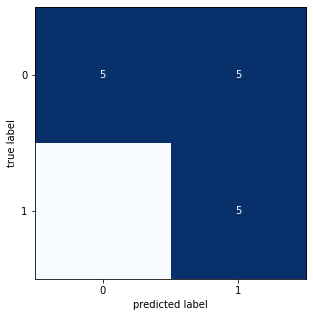

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



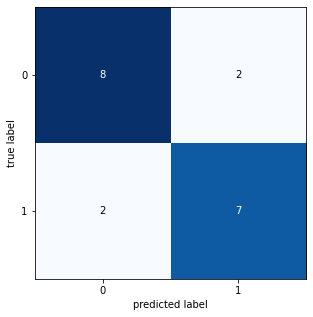

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



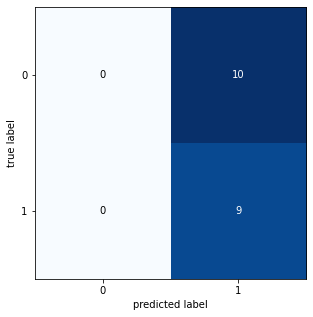

avg accuraccy Breast Cancer =  0.5478947368421053
avg F1_Score Breast Cancer =  0.45606228214213695
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.9323616019974
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

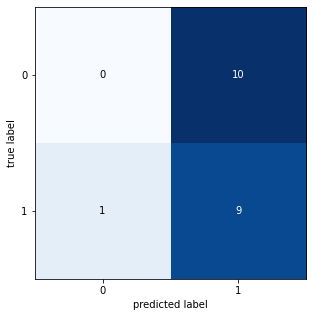

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



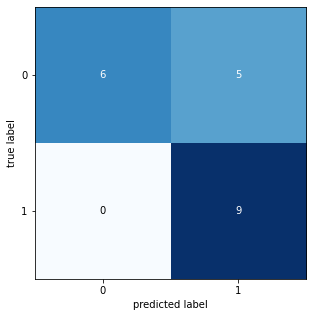

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


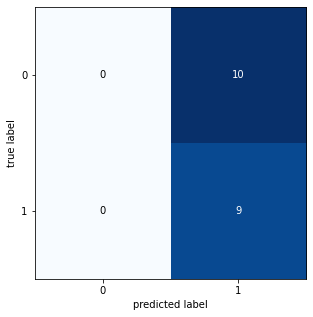

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



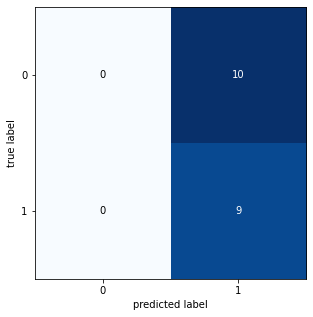

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



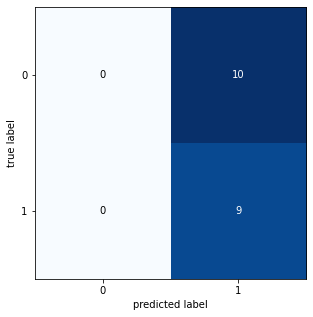

avg accuraccy Breast Cancer =  0.5242105263157895
avg F1_Score Breast Cancer =  0.4037752132337193
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966752
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.40293931400083
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


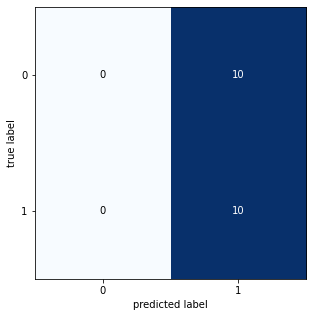

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



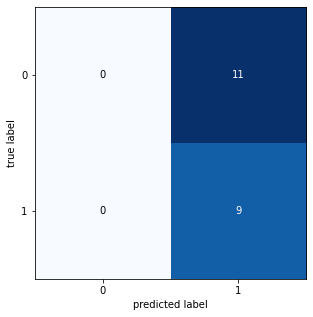

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



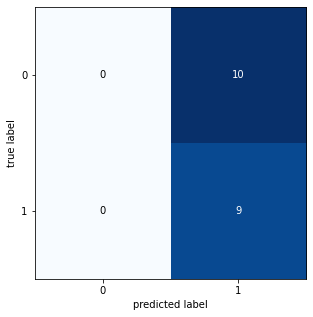

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



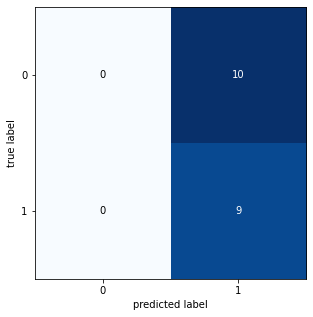

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



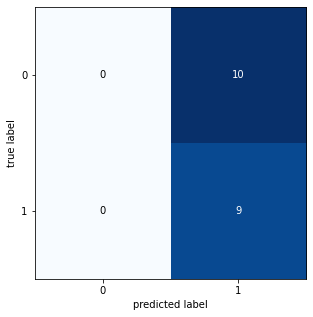

avg accuraccy Breast Cancer =  0.4742105263157894
avg F1_Score Breast Cancer =  0.3215927750410509
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.3333333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.806139899999835
gene : [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


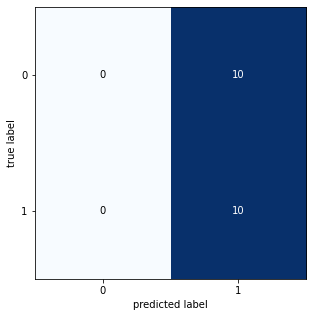

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



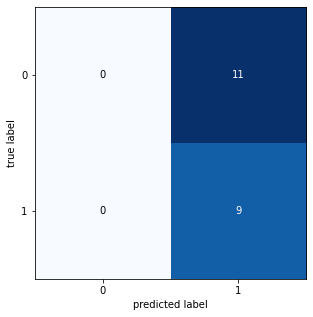

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.45714285714285713
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       1.00      0.11      0.20         9

    accuracy                           0.58        19
   macro avg       0.78      0.56      0.46        19
weighted avg       0.77      0.58      0.47        19



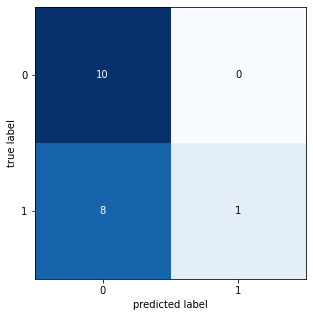

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



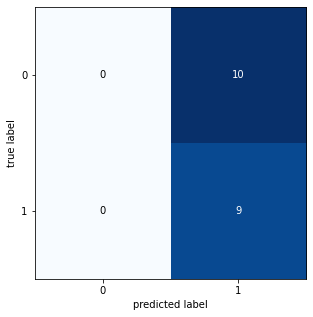

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5521885521885521
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        10
           1       1.00      0.22      0.36         9

    accuracy                           0.63        19
   macro avg       0.79      0.61      0.55        19
weighted avg       0.78      0.63      0.56        19



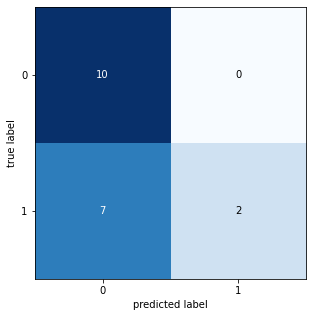

avg accuraccy Breast Cancer =  0.5268421052631579
avg F1_Score Breast Cancer =  0.3948876283359042
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.5521885521885521
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.5798458309946
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

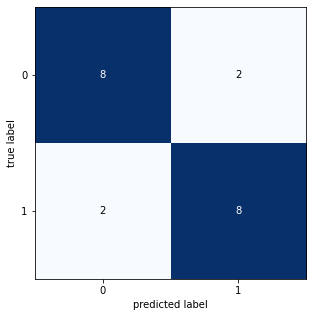

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



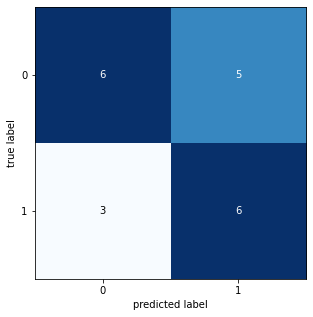

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



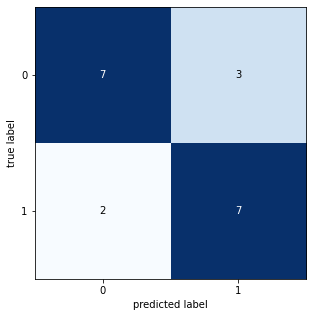

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


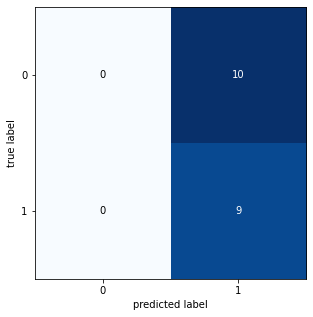

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



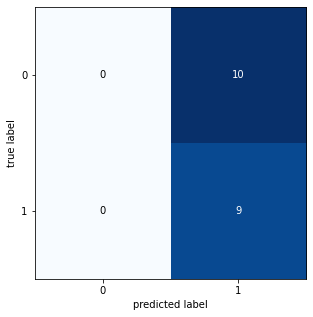

avg accuraccy Breast Cancer =  0.616842105263158
avg F1_Score Breast Cancer =  0.5559398496240602
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.8000000000000002
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  37.410372327001824
gene : [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


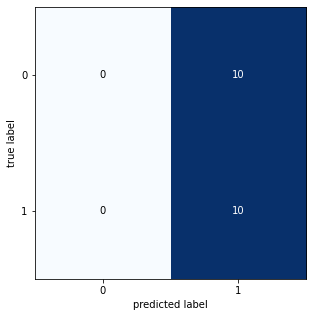

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.60      1.00      0.75         9

    accuracy                           0.70        20
   macro avg       0.80      0.73      0.69        20
weighted avg       0.82      0.70      0.68        20



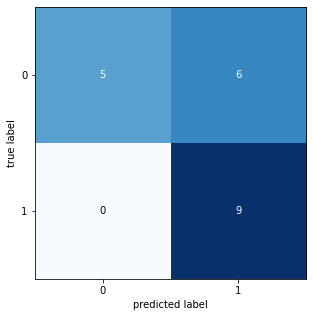

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



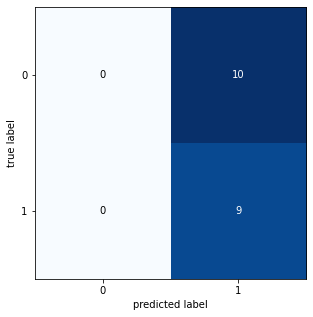

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.60      1.00      0.75         9

    accuracy                           0.68        19
   macro avg       0.80      0.70      0.66        19
weighted avg       0.81      0.68      0.66        19



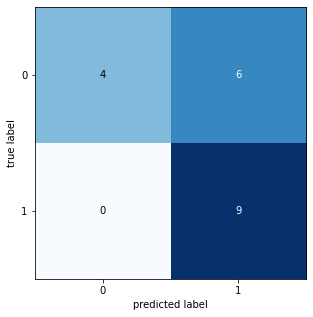

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



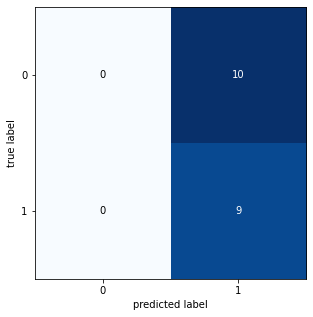

avg accuraccy Breast Cancer =  0.5663157894736842
avg F1_Score Breast Cancer =  0.4648809523809524
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.6875
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.34558710800047
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


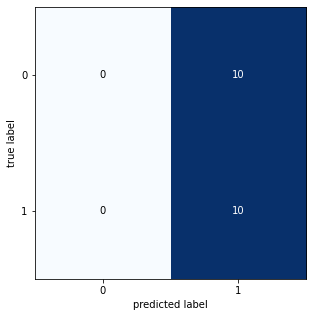

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



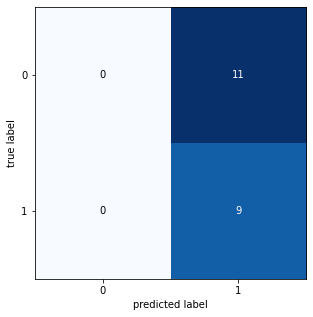

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



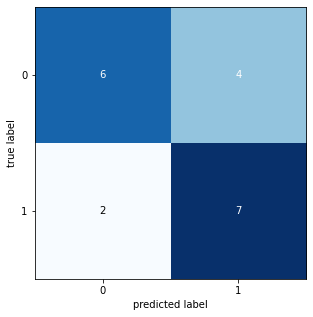

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



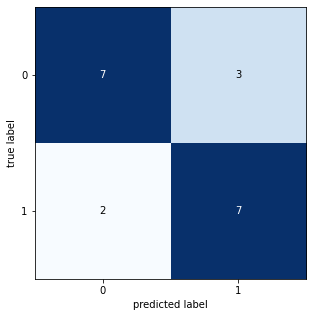

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



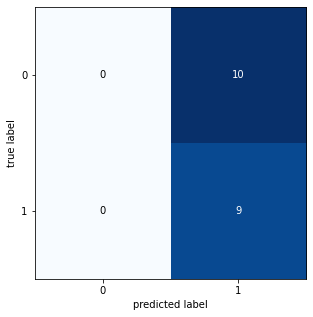

avg accuraccy Breast Cancer =  0.5689473684210526
avg F1_Score Breast Cancer =  0.47705643418892063
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.121449924001354
gen terbaik : [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.6030483405483407  || jumlah fitur : 54

Generation : 3
gene : [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 

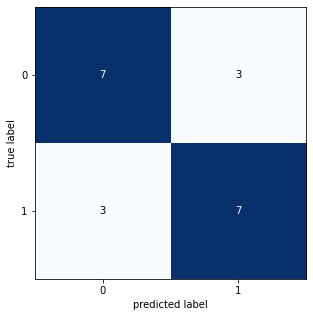

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


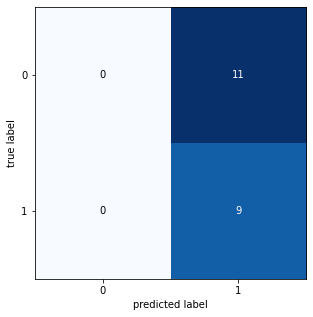

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



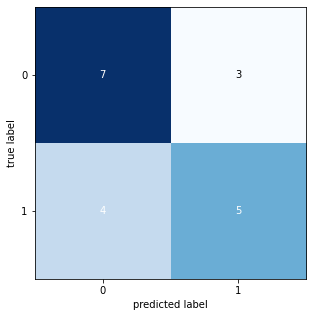

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



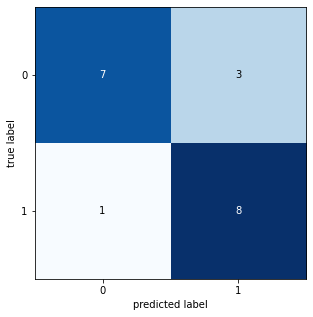

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



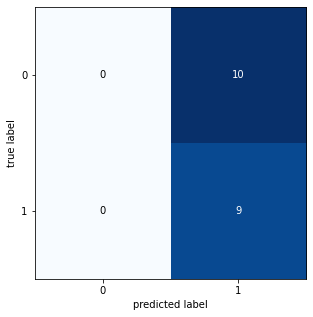

avg accuraccy Breast Cancer =  0.6089473684210527
avg F1_Score Breast Cancer =  0.5496226536591649
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.53646540299815
gene : [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


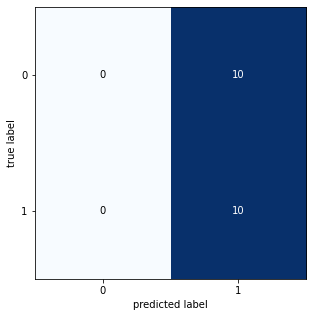

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.3548387096774194
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



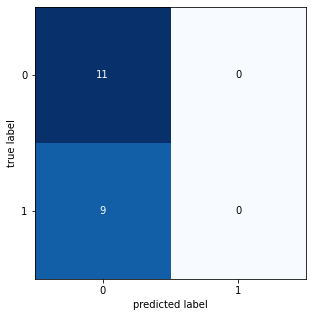

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.4722222222222222
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.44      0.44      0.44         9

    accuracy                           0.47        19
   macro avg       0.47      0.47      0.47        19
weighted avg       0.47      0.47      0.47        19



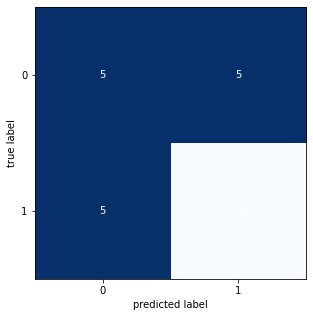

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



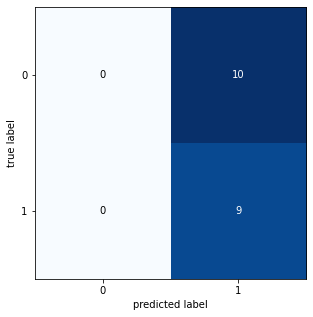

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



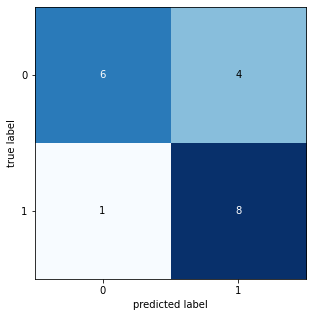

avg accuraccy Breast Cancer =  0.5468421052631578
avg F1_Score Breast Cancer =  0.44314327881690313
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.2080696349949
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

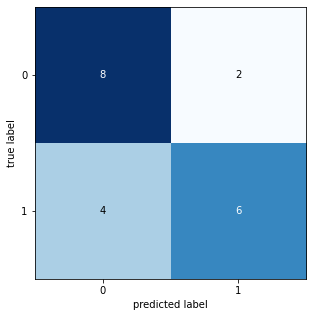

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



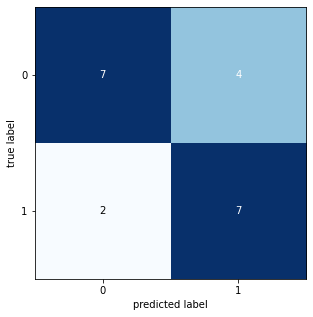

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.4722222222222222
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.44      0.44      0.44         9

    accuracy                           0.47        19
   macro avg       0.47      0.47      0.47        19
weighted avg       0.47      0.47      0.47        19



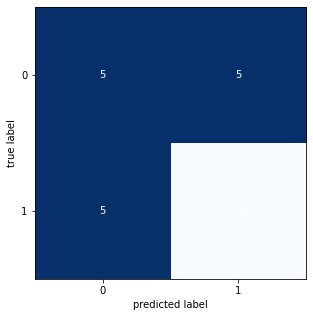

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.60      1.00      0.75         9

    accuracy                           0.68        19
   macro avg       0.80      0.70      0.66        19
weighted avg       0.81      0.68      0.66        19



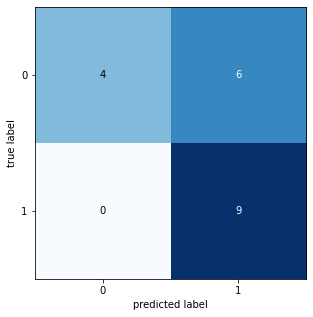

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



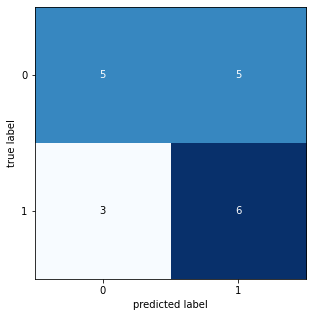

avg accuraccy Breast Cancer =  0.6273684210526316
avg F1_Score Breast Cancer =  0.6215367965367966
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.7000000000000001
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.4722222222222222
Running Time:  39.339771446997474
gene : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


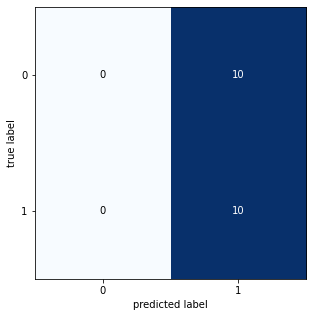

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



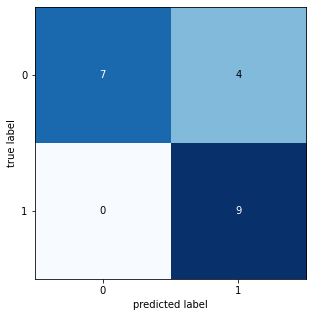

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



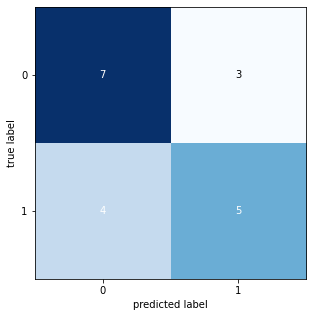

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



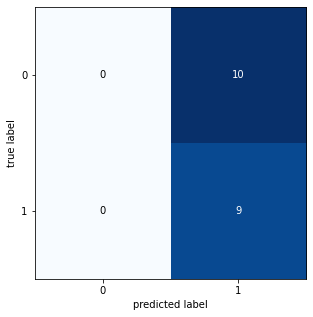

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



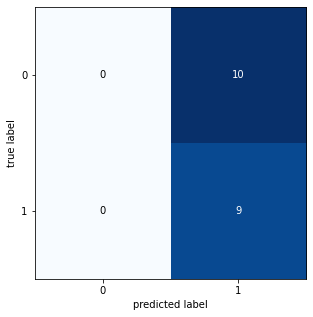

avg accuraccy Breast Cancer =  0.5757894736842106
avg F1_Score Breast Cancer =  0.4803242509124862
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.62823909400322
gene : [0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


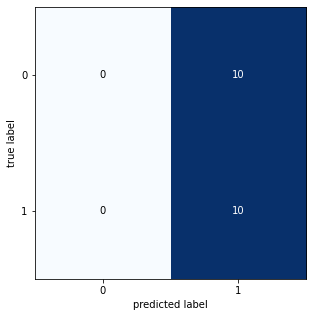

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



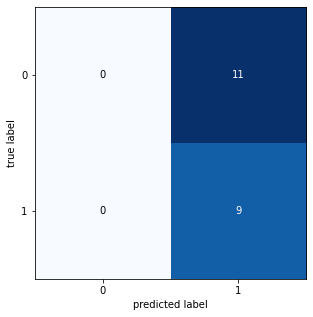

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



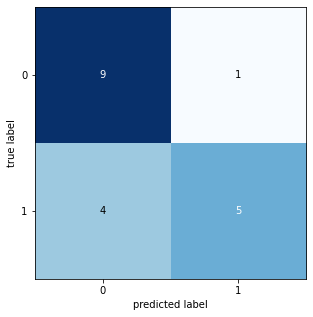

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



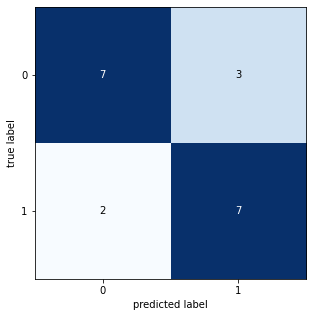

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



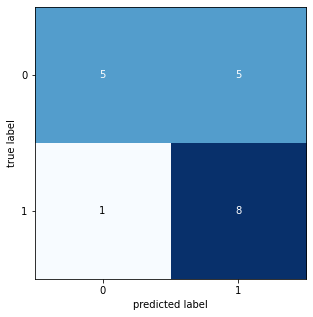

avg accuraccy Breast Cancer =  0.621578947368421
avg F1_Score Breast Cancer =  0.5562588621956964
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.389884220006934
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


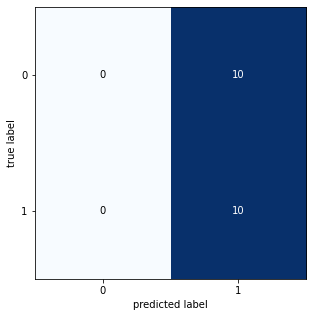

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



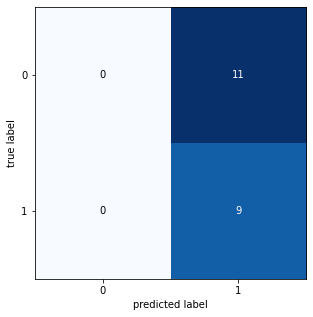

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



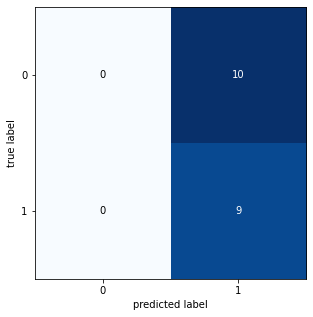

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



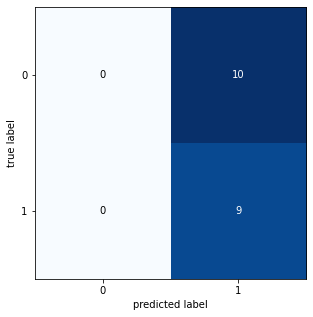

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



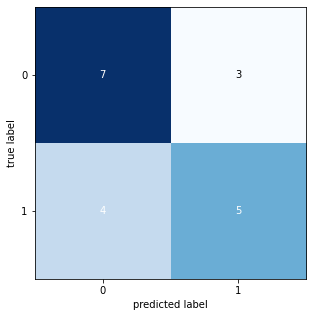

avg accuraccy Breast Cancer =  0.5057894736842105
avg F1_Score Breast Cancer =  0.382797256833768
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.6274509803921569
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.748638061995734
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


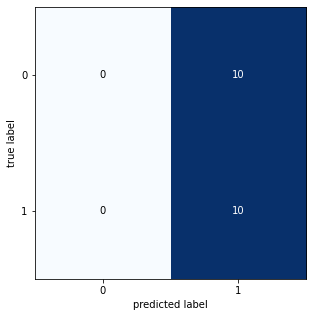

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



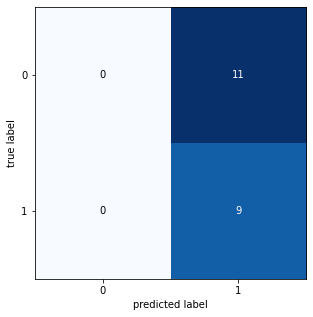

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



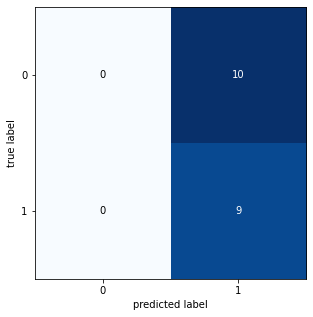

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692307
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.56      1.00      0.72         9

    accuracy                           0.63        19
   macro avg       0.78      0.65      0.59        19
weighted avg       0.79      0.63      0.58        19



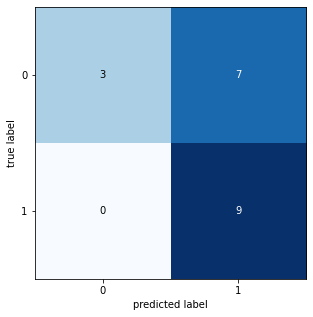

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



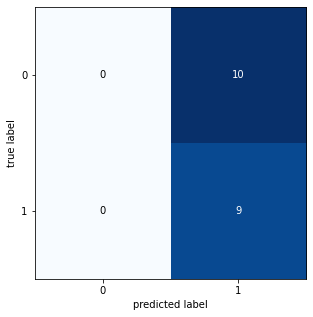

avg accuraccy Breast Cancer =  0.5057894736842105
avg F1_Score Breast Cancer =  0.37546090690918277
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.5907692307692307
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.16977119999501
gene : [1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


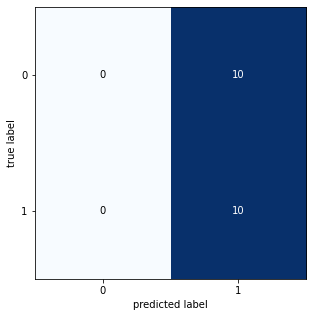

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5396419437340154
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.50      0.44      0.47         9

    accuracy                           0.55        20
   macro avg       0.54      0.54      0.54        20
weighted avg       0.55      0.55      0.55        20



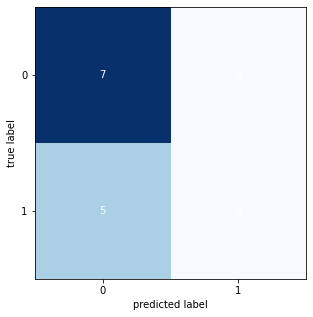

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



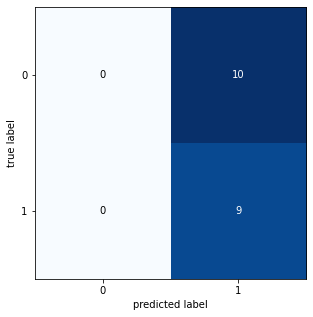

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



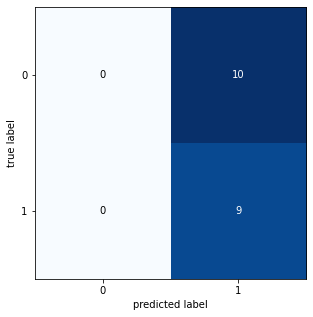

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



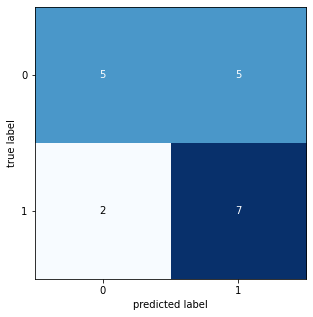

avg accuraccy Breast Cancer =  0.5257894736842105
avg F1_Score Breast Cancer =  0.4286566800633297
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.6274509803921569
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.0166671650004
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

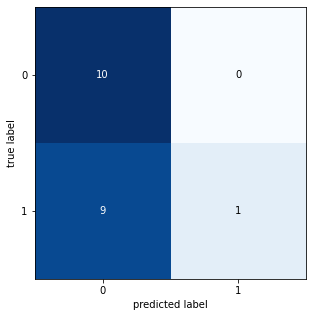

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5604395604395604
              precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.60      0.33      0.43         9

    accuracy                           0.60        20
   macro avg       0.60      0.58      0.56        20
weighted avg       0.60      0.60      0.57        20



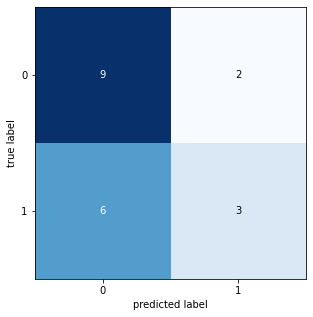

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.42105263157894735
F1_Score :  0.2962962962962963
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.44      0.89      0.59         9

    accuracy                           0.42        19
   macro avg       0.22      0.44      0.30        19
weighted avg       0.21      0.42      0.28        19



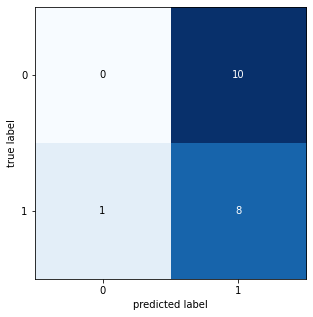

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


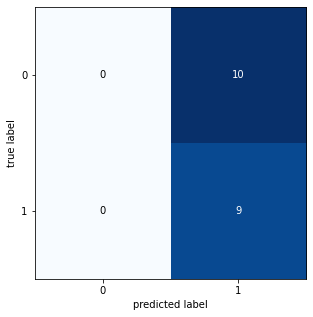

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



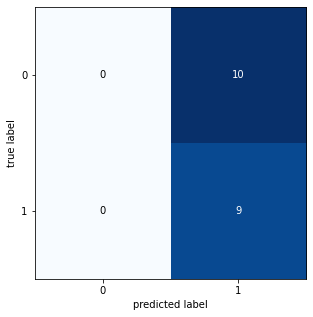

avg accuraccy Breast Cancer =  0.5036842105263158
avg F1_Score Breast Cancer =  0.3870659353417974
max accuraccy Breast Cancer =  0.6
max F1_Score Breast Cancer =  0.5604395604395604
min accuraccy Breast Cancer =  0.42105263157894735
min F1_Score Breast Cancer =  0.2962962962962963
Running Time:  39.60838051099563
gene : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


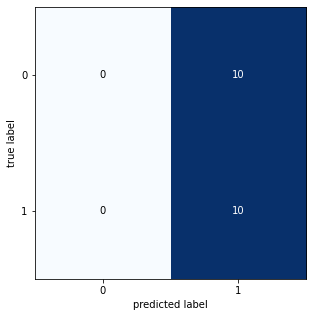

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



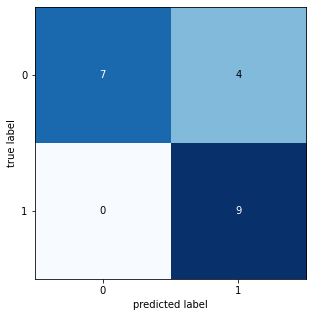

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



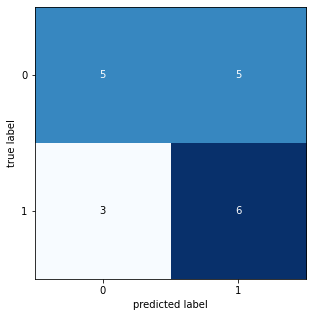

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



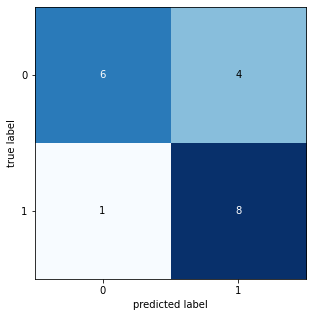

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8347826086956522
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.67      0.80         9

    accuracy                           0.84        19
   macro avg       0.88      0.83      0.83        19
weighted avg       0.88      0.84      0.84        19



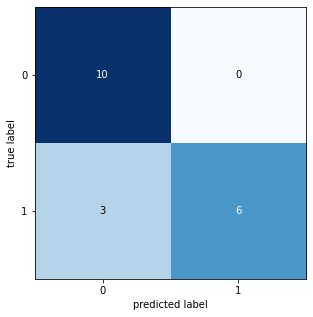

avg accuraccy Breast Cancer =  0.6915789473684211
avg F1_Score Breast Cancer =  0.6555534150419061
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8347826086956522
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.3333333333333333
Running Time:  39.32399248400179
gen terbaik : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
F-1 Score terbaik : 0.6555534150419061  || jumlah fitur : 54

Generation : 4
gene : [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


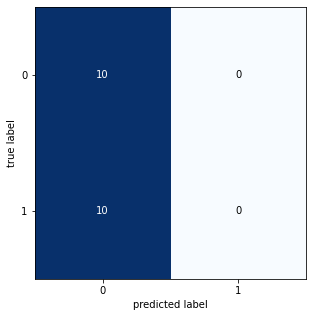

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5833333333333335
              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.53      0.89      0.67         9

    accuracy                           0.60        20
   macro avg       0.67      0.63      0.58        20
weighted avg       0.68      0.60      0.58        20



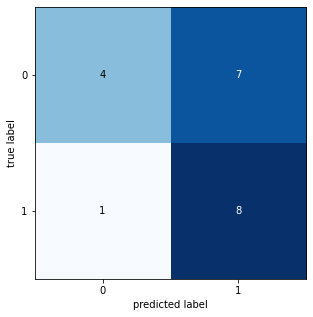

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



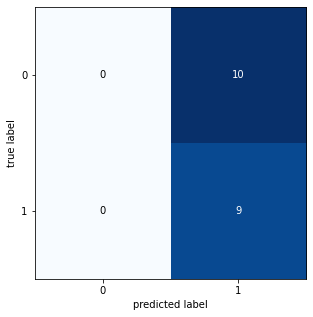

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



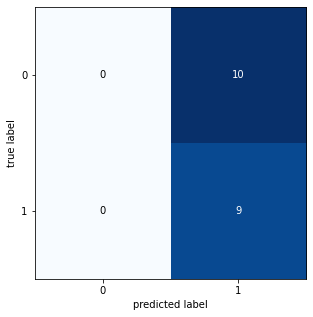

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



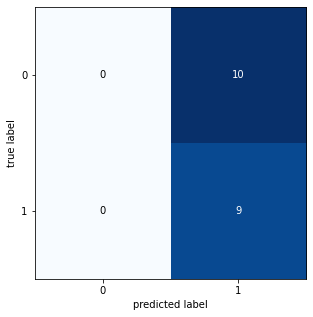

avg accuraccy Breast Cancer =  0.5042105263157894
avg F1_Score Breast Cancer =  0.3761904761904762
max accuraccy Breast Cancer =  0.6
max F1_Score Breast Cancer =  0.5833333333333335
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.21060243900138
gene : [0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


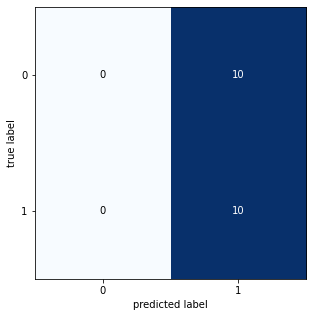

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



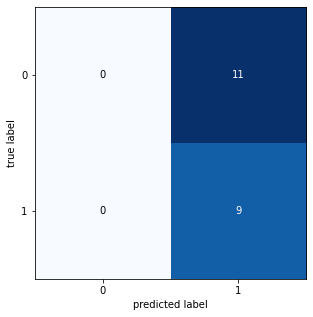

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



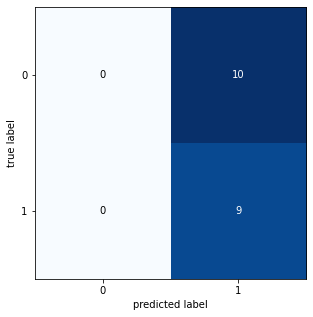

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



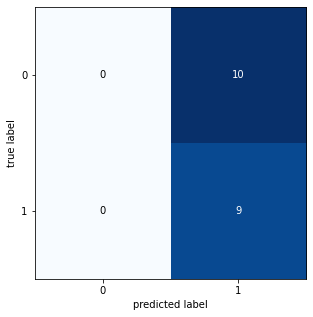

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



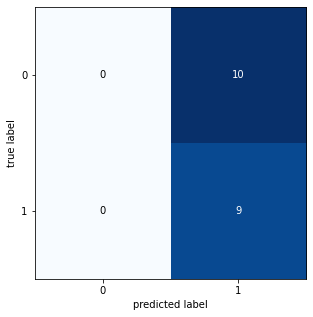

avg accuraccy Breast Cancer =  0.4742105263157894
avg F1_Score Breast Cancer =  0.3215927750410509
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.3333333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.72020933299791
gene : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

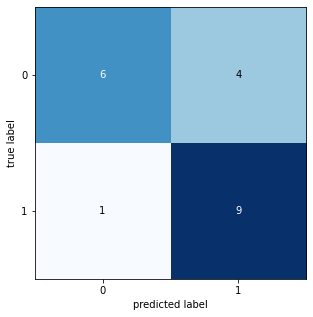

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



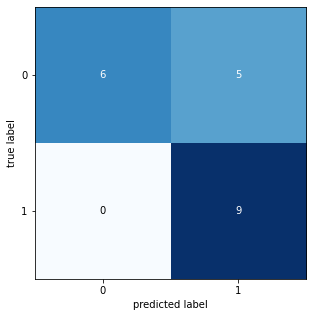

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


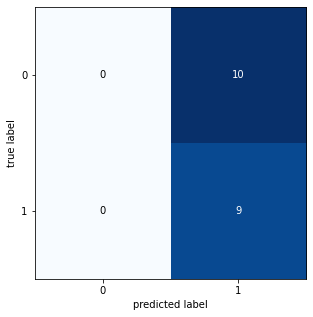

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



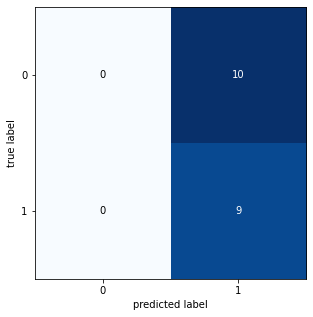

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



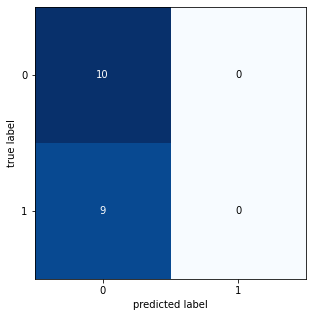

avg accuraccy Breast Cancer =  0.5947368421052631
avg F1_Score Breast Cancer =  0.4952351555314779
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966752
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.08018177800113
gene : [0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

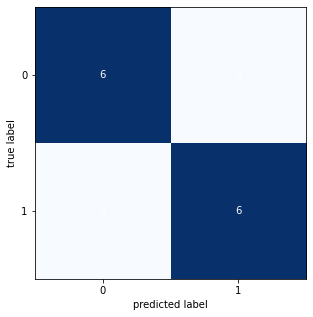

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


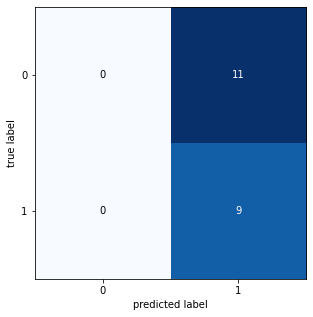

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



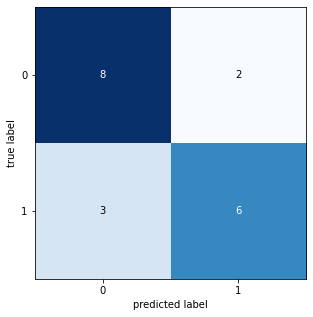

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



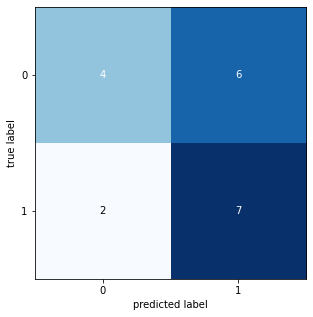

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



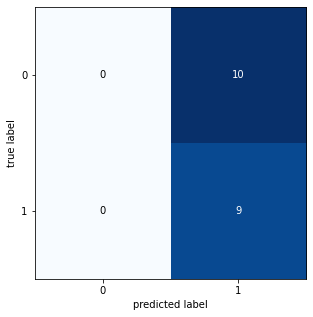

avg accuraccy Breast Cancer =  0.5678947368421052
avg F1_Score Breast Cancer =  0.5067697549239132
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.68520307700237
gene : [0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

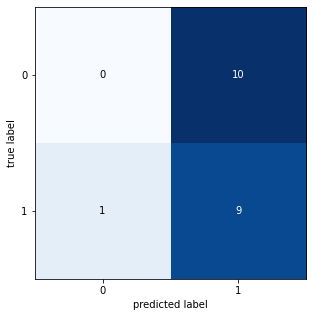

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


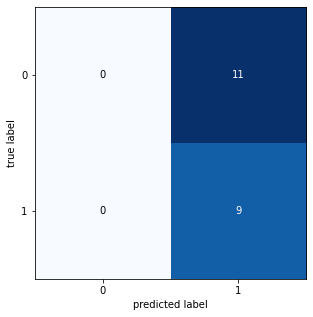

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



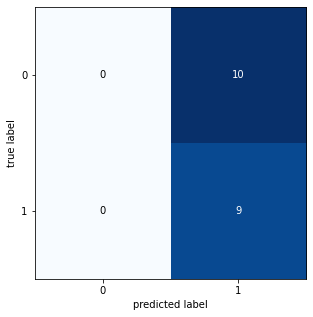

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692307
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.56      1.00      0.72         9

    accuracy                           0.63        19
   macro avg       0.78      0.65      0.59        19
weighted avg       0.79      0.63      0.58        19



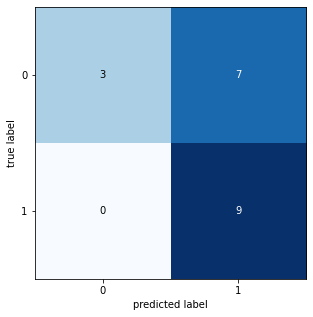

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



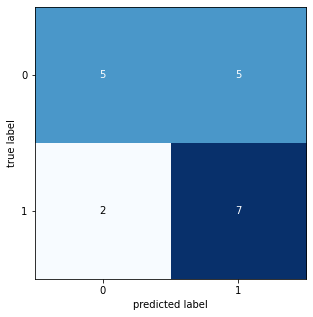

avg accuraccy Breast Cancer =  0.5273684210526316
avg F1_Score Breast Cancer =  0.4320676875524746
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.6274509803921569
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.927456294004514
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

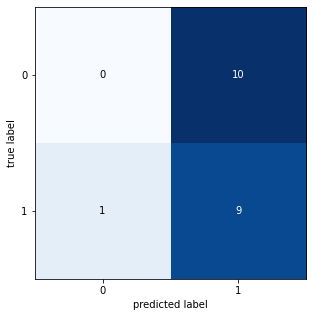

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



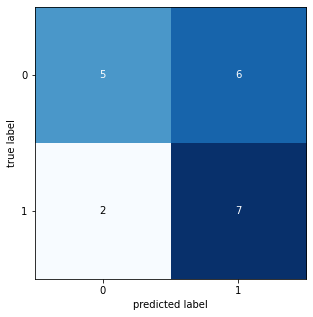

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



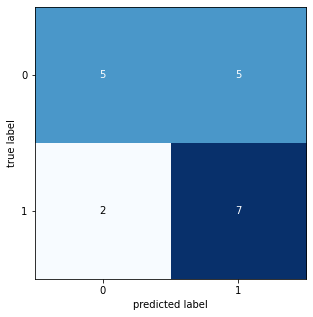

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



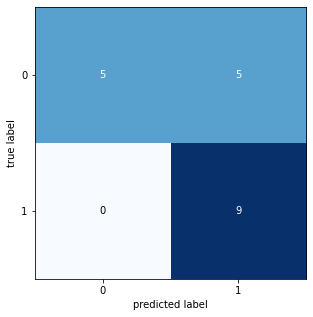

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.80      0.44      0.57         9

    accuracy                           0.68        19
   macro avg       0.72      0.67      0.66        19
weighted avg       0.72      0.68      0.67        19



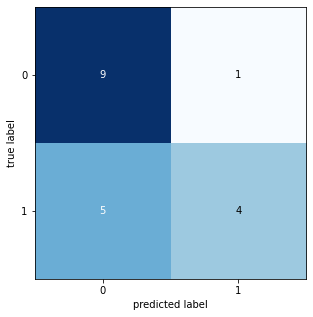

avg accuraccy Breast Cancer =  0.6205263157894737
avg F1_Score Breast Cancer =  0.5838214741623331
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7246376811594203
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.690542299998924
gene : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


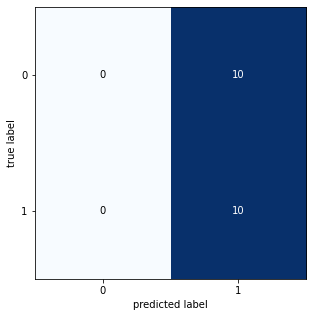

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



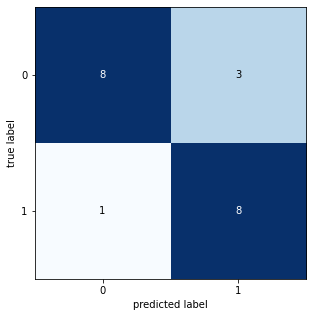

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



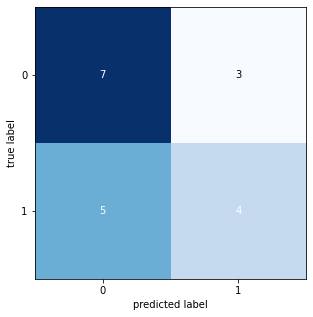

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



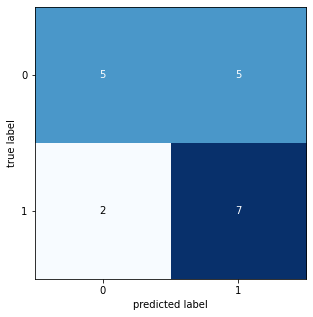

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



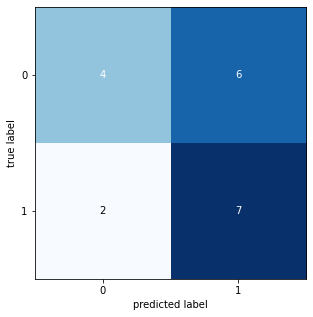

avg accuraccy Breast Cancer =  0.6178947368421053
avg F1_Score Breast Cancer =  0.5794295900178253
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.7999999999999999
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.3333333333333333
Running Time:  39.62484891899658
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


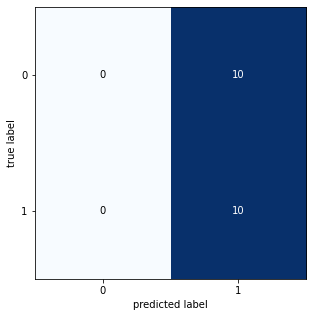

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



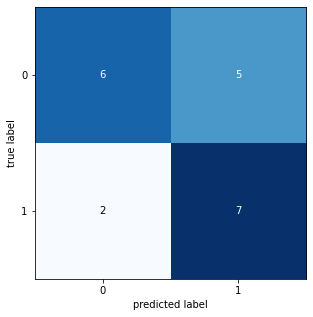

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.45714285714285713
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       1.00      0.11      0.20         9

    accuracy                           0.58        19
   macro avg       0.78      0.56      0.46        19
weighted avg       0.77      0.58      0.47        19



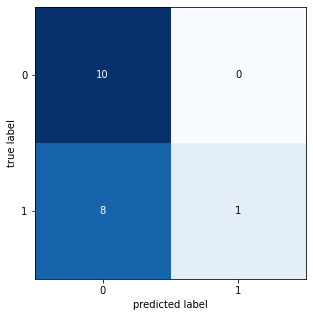

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



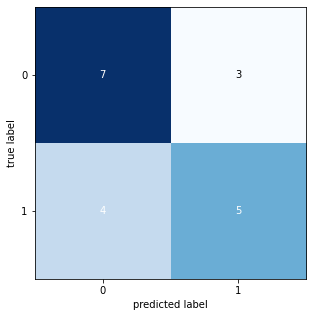

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



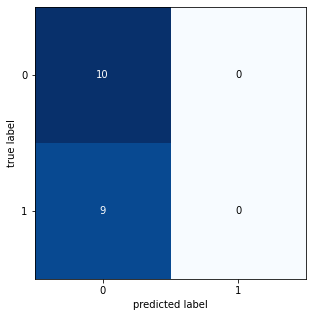

avg accuraccy Breast Cancer =  0.5773684210526315
avg F1_Score Breast Cancer =  0.4823755128185576
max accuraccy Breast Cancer =  0.65
max F1_Score Breast Cancer =  0.6491228070175439
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.3333333333333333
Running Time:  42.140539620006166
gene : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

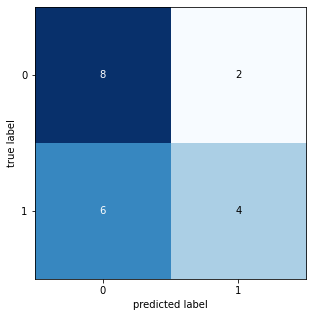

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.60      1.00      0.75         9

    accuracy                           0.70        20
   macro avg       0.80      0.73      0.69        20
weighted avg       0.82      0.70      0.68        20



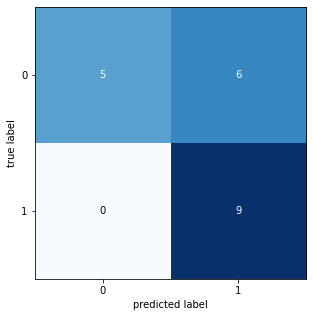

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


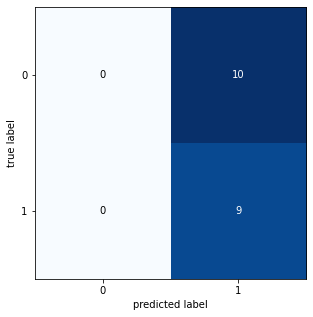

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



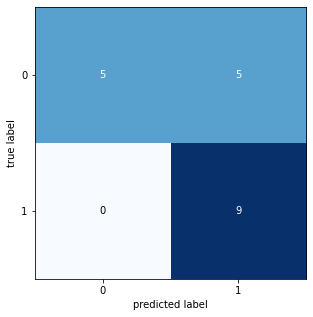

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



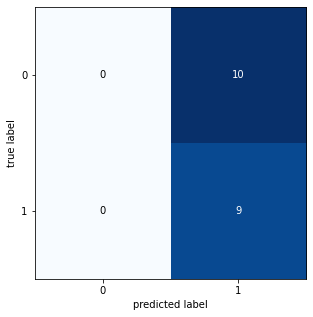

avg accuraccy Breast Cancer =  0.5968421052631578
avg F1_Score Breast Cancer =  0.5276656314699794
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7246376811594203
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.555045017994416
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


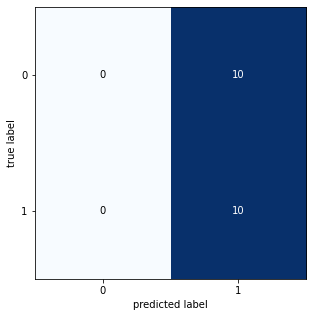

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



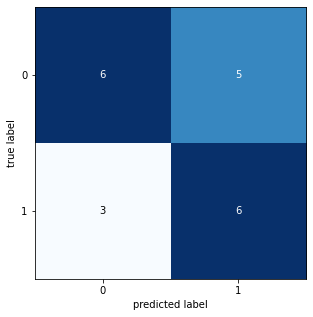

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



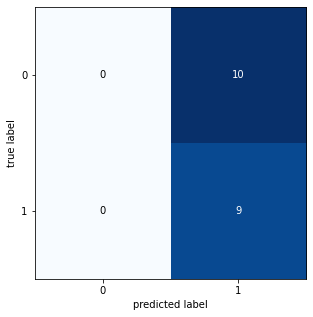

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



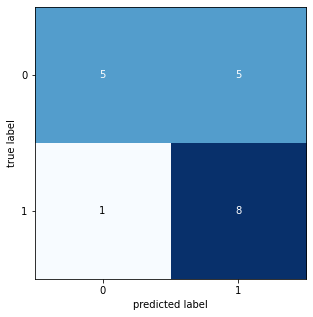

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



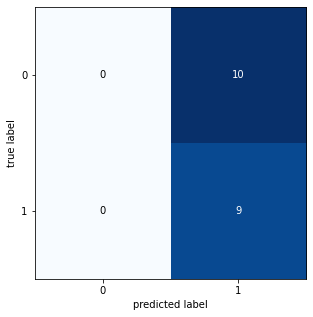

avg accuraccy Breast Cancer =  0.5463157894736843
avg F1_Score Breast Cancer =  0.450465367965368
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6761363636363638
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.90359721300047
gen terbaik : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.5838214741623331  || jumlah fitur : 53

Running Time:  2009.5683446679977


In [14]:
Breast_IG_GA = GeneticAlgorithm(Breast_IG, 3)

Generation : 0
gene : [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00

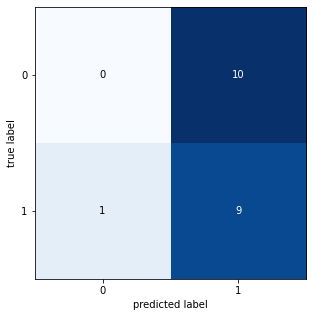

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.60      1.00      0.75         9

    accuracy                           0.70        20
   macro avg       0.80      0.73      0.69        20
weighted avg       0.82      0.70      0.68        20



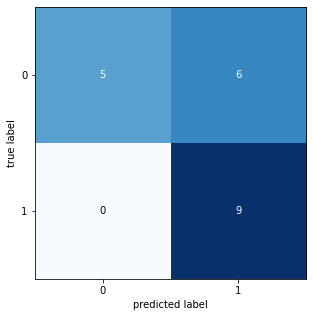

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



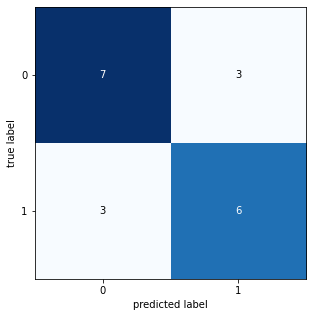

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


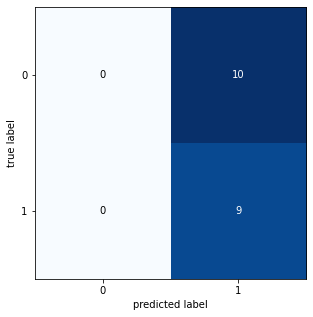

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



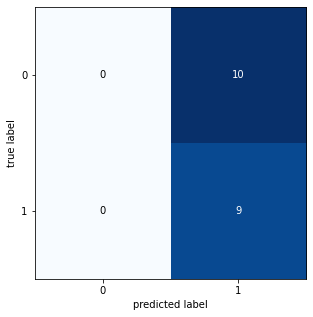

avg accuraccy Breast Cancer =  0.5563157894736842
avg F1_Score Breast Cancer =  0.4648070607553366
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.6875
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  42.12642924199463
gene : [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 

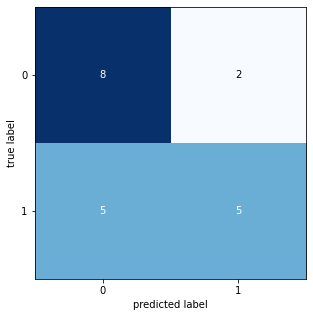

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



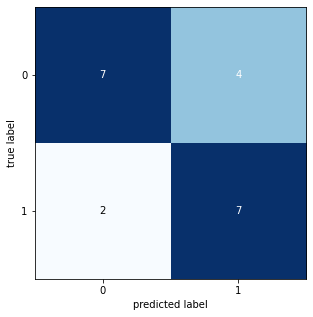

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



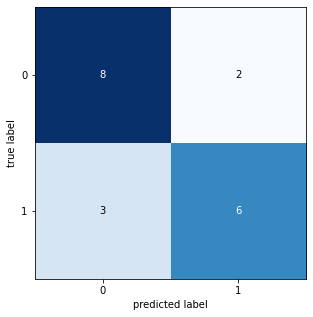

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



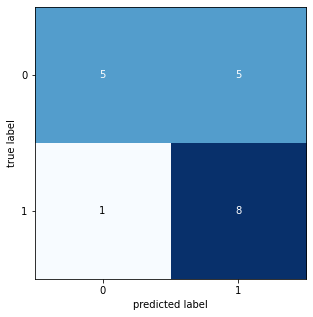

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


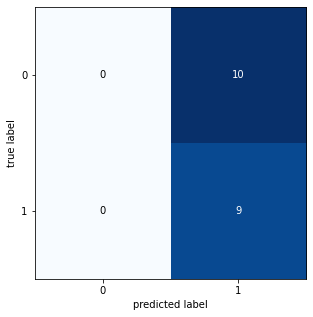

avg accuraccy Breast Cancer =  0.6489473684210527
avg F1_Score Breast Cancer =  0.6146804453006499
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  42.51844991299731
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


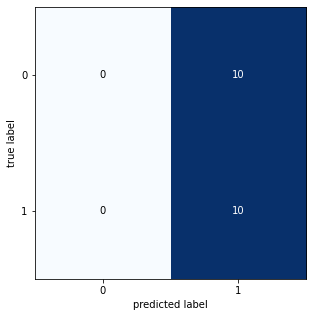

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



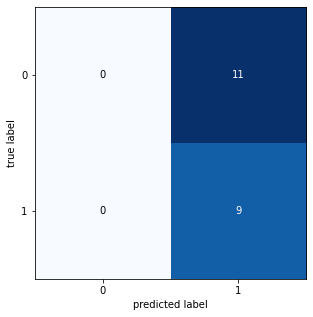

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



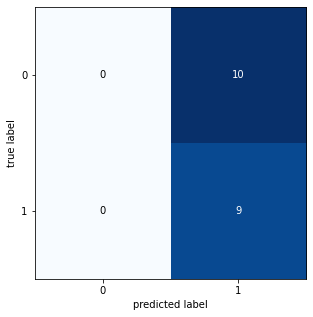

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



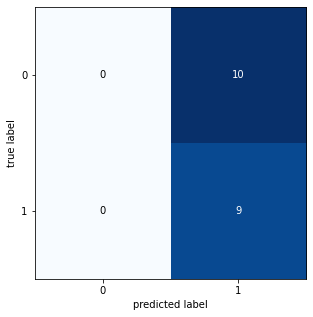

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



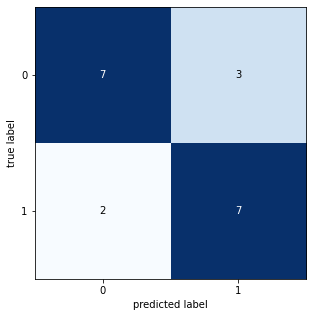

avg accuraccy Breast Cancer =  0.5268421052631578
avg F1_Score Breast Cancer =  0.4046754818079682
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.506891360004374
gene : [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


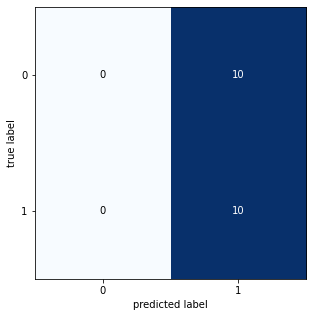

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



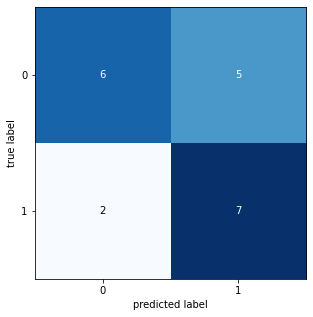

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



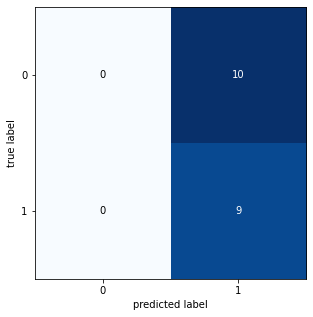

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



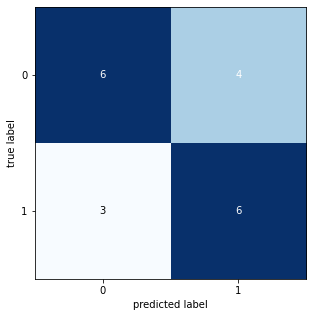

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



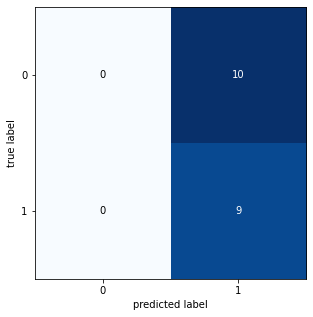

avg accuraccy Breast Cancer =  0.5457894736842105
avg F1_Score Breast Cancer =  0.4513784461152882
max accuraccy Breast Cancer =  0.65
max F1_Score Breast Cancer =  0.6491228070175439
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.792483854005695
gene : [0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


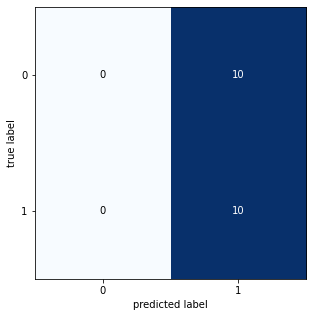

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



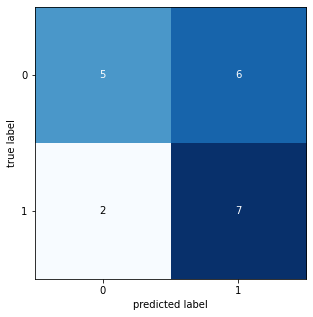

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.42105263157894735
F1_Score :  0.2962962962962963
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.44      0.89      0.59         9

    accuracy                           0.42        19
   macro avg       0.22      0.44      0.30        19
weighted avg       0.21      0.42      0.28        19



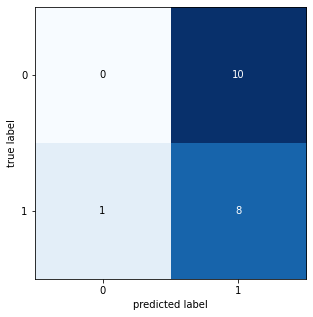

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



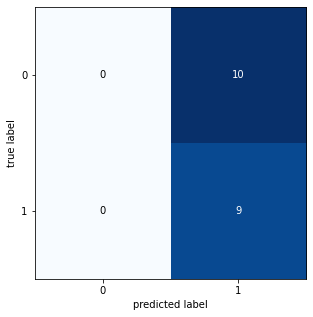

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



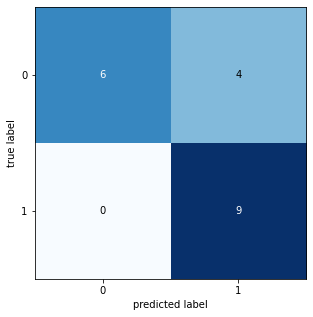

avg accuraccy Breast Cancer =  0.5568421052631579
avg F1_Score Breast Cancer =  0.4662217412217412
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.42105263157894735
min F1_Score Breast Cancer =  0.2962962962962963
Running Time:  38.83994577299745
gene : [1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

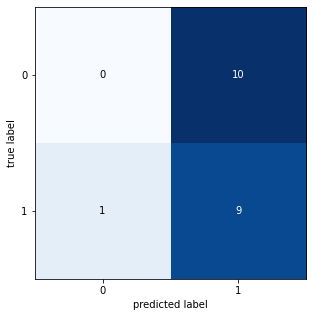

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


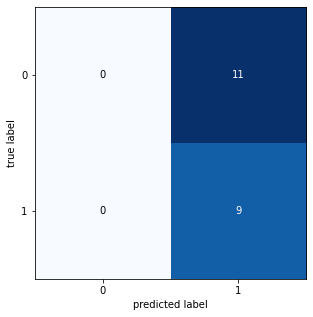

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



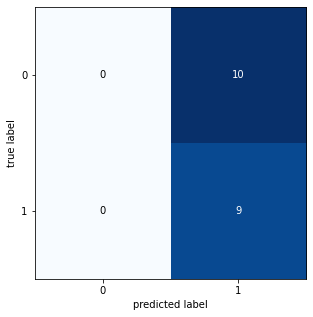

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



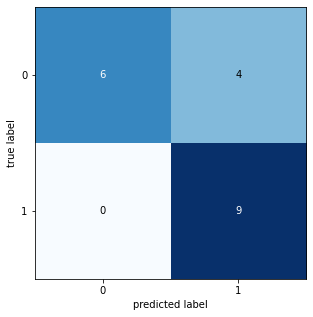

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



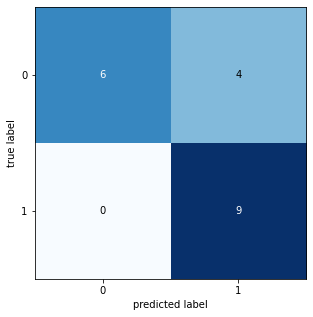

avg accuraccy Breast Cancer =  0.5905263157894737
avg F1_Score Breast Cancer =  0.5020600089565607
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.4352942139958
gene : [1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

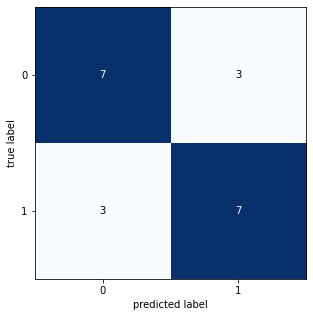

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



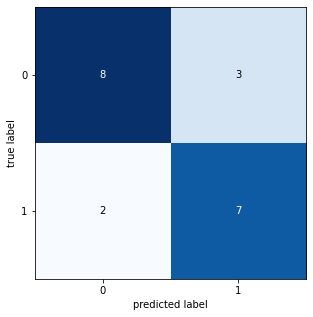

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


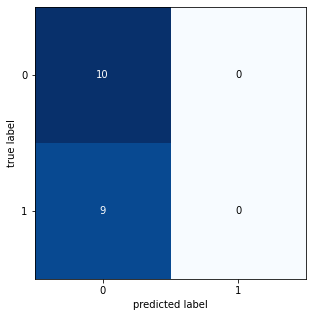

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



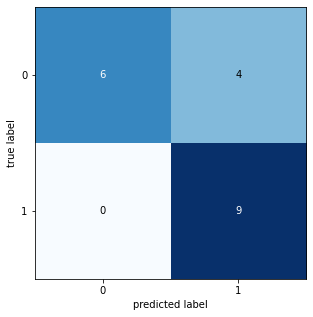

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



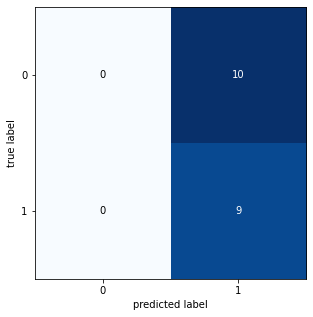

avg accuraccy Breast Cancer =  0.6478947368421053
avg F1_Score Breast Cancer =  0.5799441000620674
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.530768528995395
gene : [1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

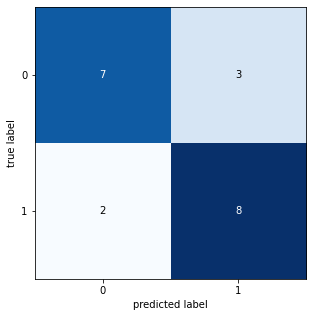

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


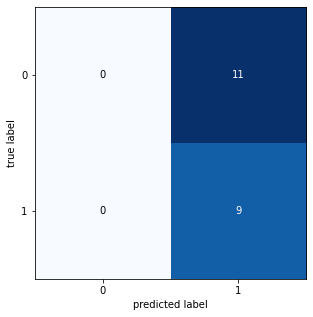

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



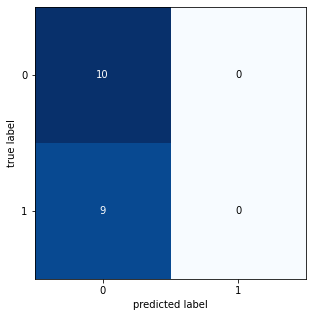

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



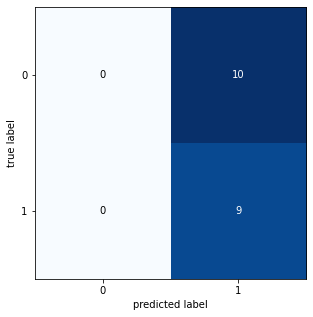

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



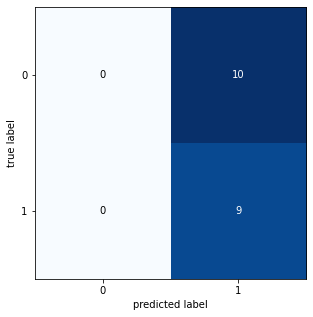

avg accuraccy Breast Cancer =  0.5347368421052632
avg F1_Score Breast Cancer =  0.4094805980468412
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.481751933999476
gene : [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

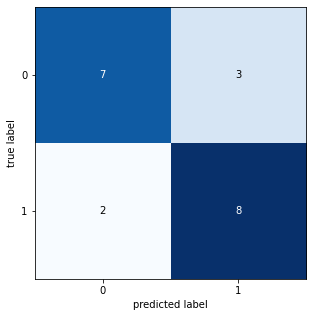

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



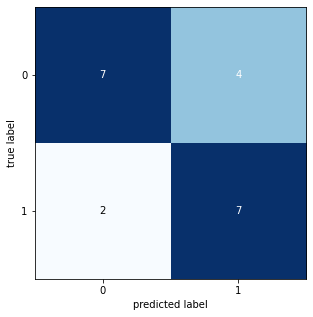

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



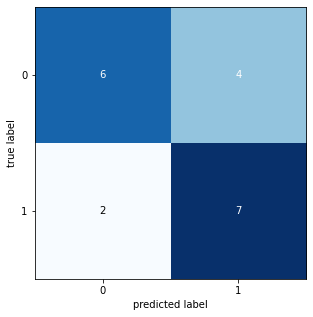

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5263157894736842
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.50      0.56      0.53         9

    accuracy                           0.53        19
   macro avg       0.53      0.53      0.53        19
weighted avg       0.53      0.53      0.53        19



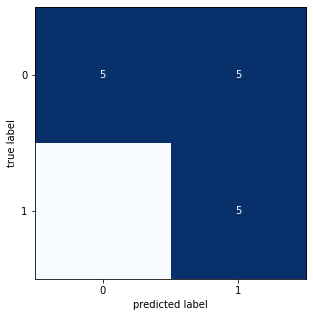

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


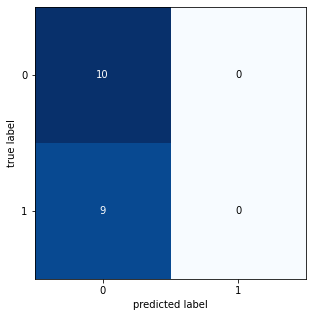

avg accuraccy Breast Cancer =  0.6373684210526316
avg F1_Score Breast Cancer =  0.6007700285195747
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.5263157894736842
min F1_Score Breast Cancer =  0.3448275862068966
Running Time:  43.37890531699668
gene : [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


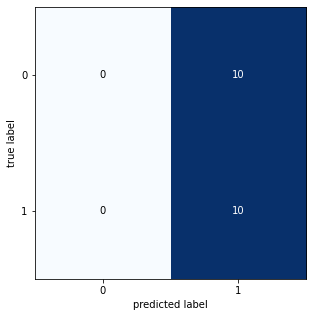

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



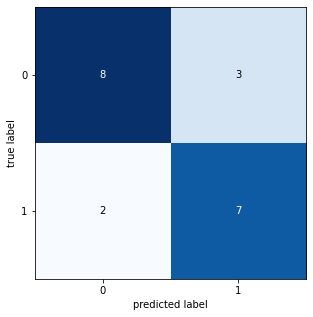

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



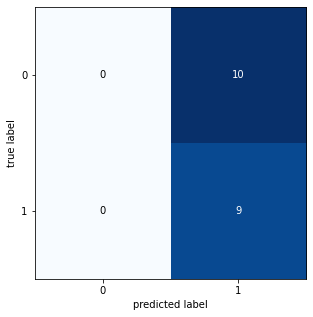

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



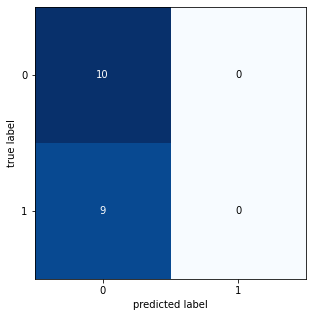

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



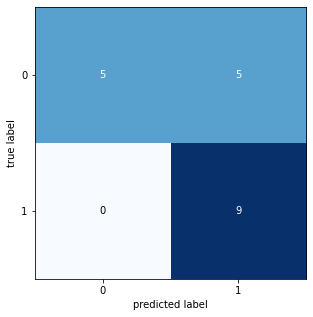

avg accuraccy Breast Cancer =  0.5973684210526315
avg F1_Score Breast Cancer =  0.4947201211424363
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  43.07992486299918
gen terbaik : [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.6146804453006499  || jumlah fitur : 52

Generation : 1
gene : [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 

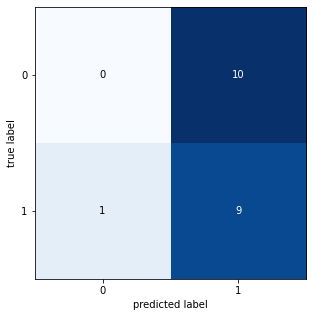

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


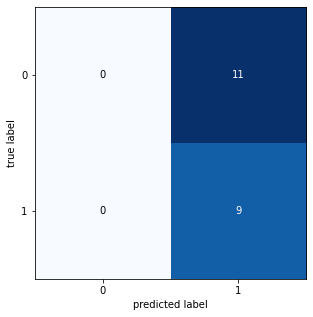

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



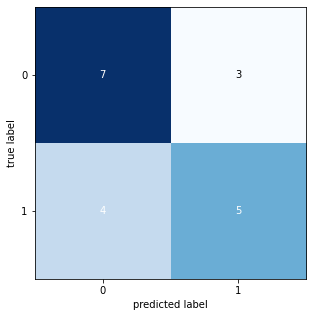

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



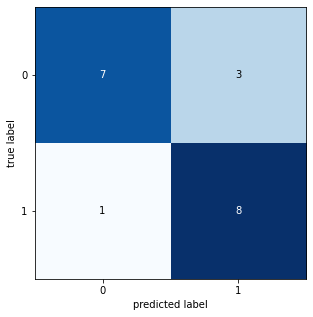

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



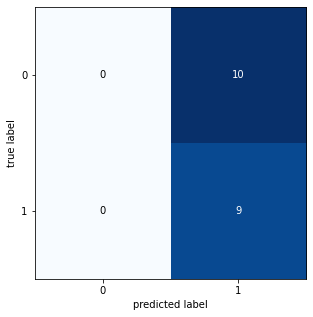

avg accuraccy Breast Cancer =  0.5589473684210526
avg F1_Score Breast Cancer =  0.4716916191764062
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.10411475100409
gene : [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

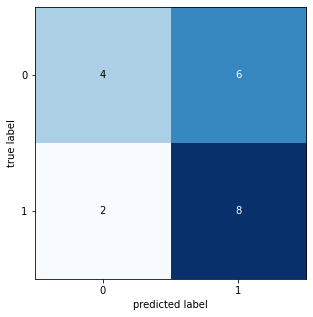

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


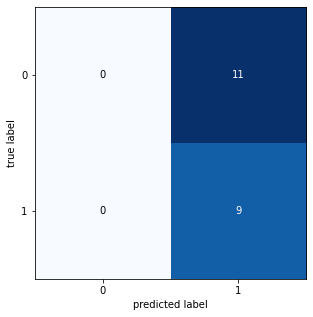

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



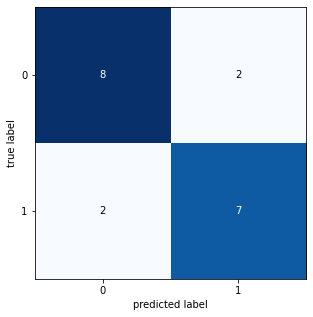

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



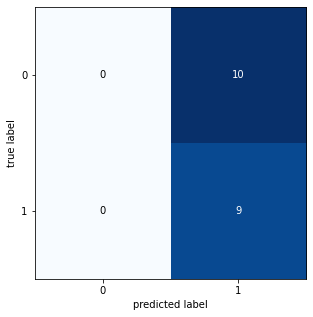

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



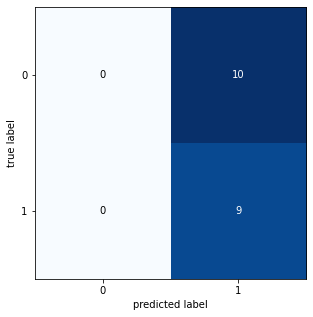

avg accuraccy Breast Cancer =  0.5573684210526316
avg F1_Score Breast Cancer =  0.46508483853311444
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.542812275998585
gene : [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

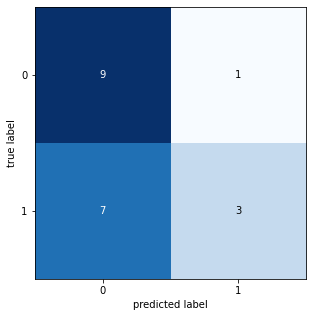

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


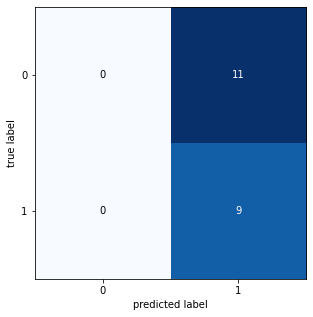

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



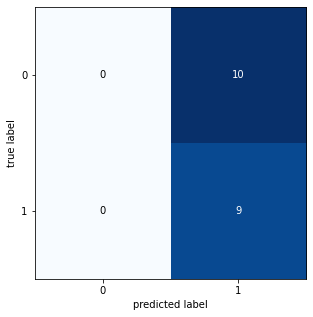

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



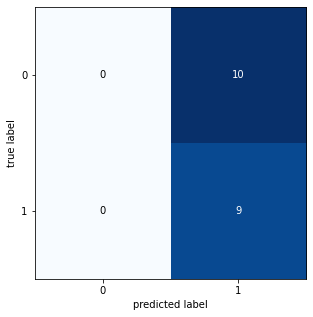

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



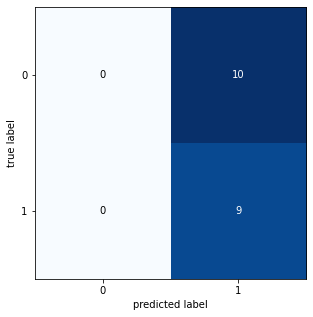

avg accuraccy Breast Cancer =  0.49421052631578943
avg F1_Score Breast Cancer =  0.3670140204622963
max accuraccy Breast Cancer =  0.6
max F1_Score Breast Cancer =  0.5604395604395604
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.3856157850023
gene : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


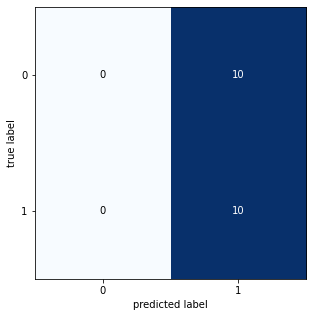

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



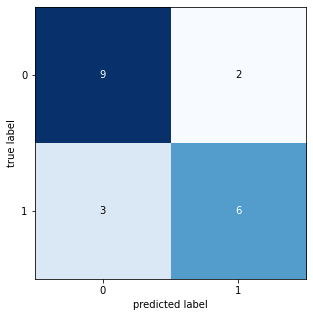

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



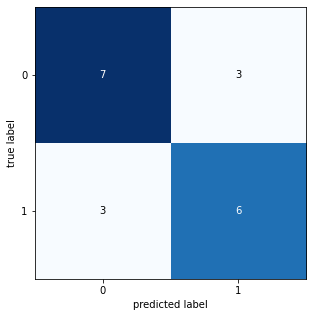

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



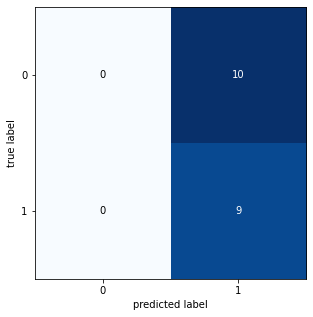

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



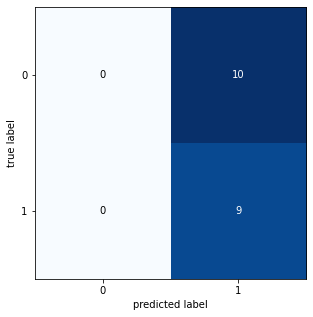

avg accuraccy Breast Cancer =  0.5763157894736842
avg F1_Score Breast Cancer =  0.48075386676409704
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966752
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.64239371599979
gene : [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


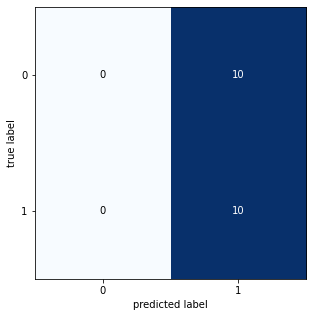

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



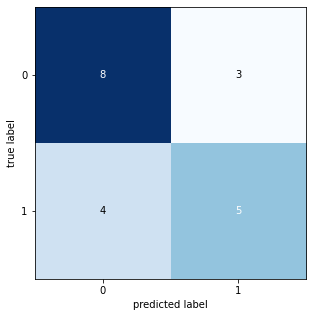

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



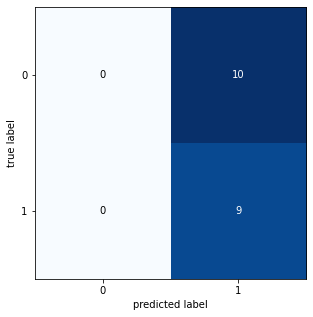

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



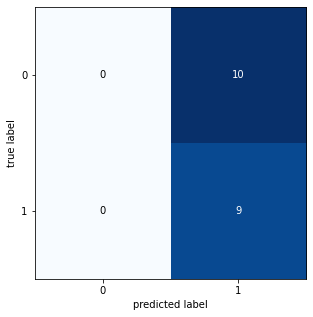

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



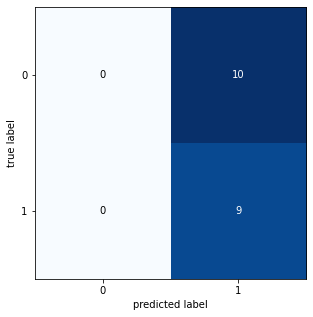

avg accuraccy Breast Cancer =  0.5142105263157895
avg F1_Score Breast Cancer =  0.38791255632687854
max accuraccy Breast Cancer =  0.65
max F1_Score Breast Cancer =  0.6419437340153453
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.19783073299914
gene : [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


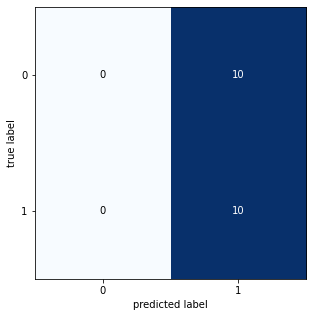

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



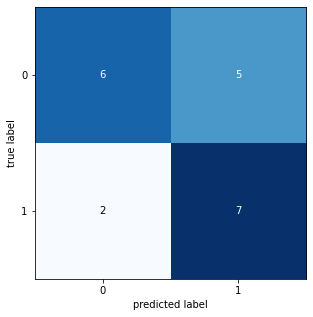

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



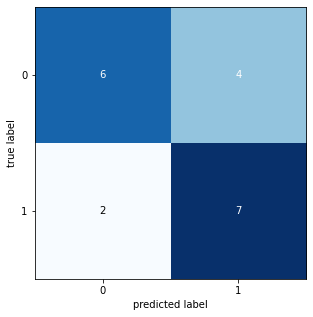

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692308
              precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.75      0.33      0.46         9

    accuracy                           0.63        19
   macro avg       0.68      0.62      0.59        19
weighted avg       0.67      0.63      0.60        19



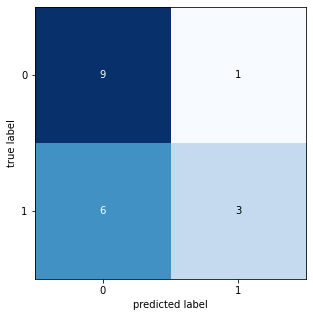

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



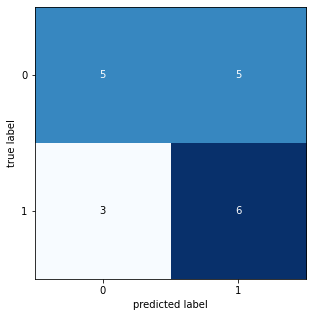

avg accuraccy Breast Cancer =  0.6089473684210526
avg F1_Score Breast Cancer =  0.5668672964462438
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.3333333333333333
Running Time:  40.62171547100297
gene : [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

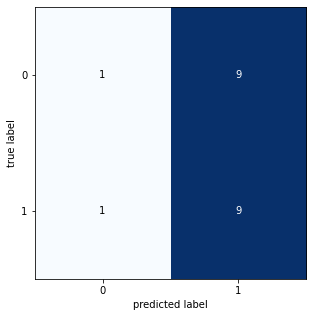

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


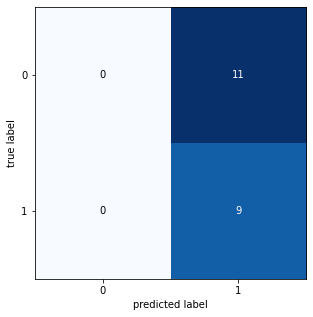

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



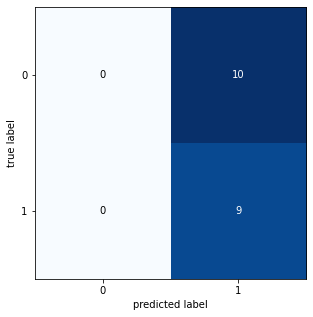

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



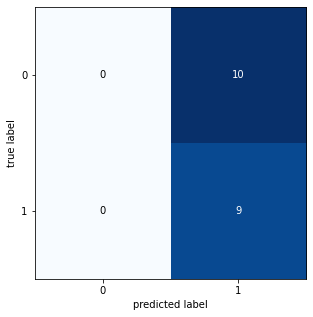

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



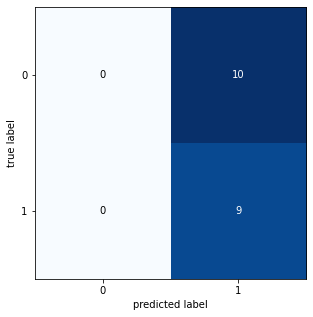

avg accuraccy Breast Cancer =  0.4742105263157894
avg F1_Score Breast Cancer =  0.3358784893267652
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.40476190476190477
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.77289072799613
gene : [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

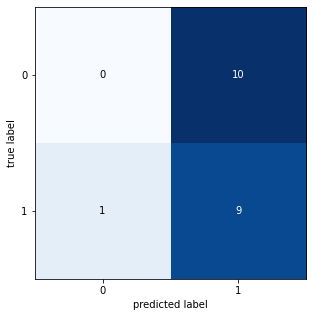

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.4
F1_Score :  0.2857142857142857
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.42      0.89      0.57         9

    accuracy                           0.40        20
   macro avg       0.21      0.44      0.29        20
weighted avg       0.19      0.40      0.26        20



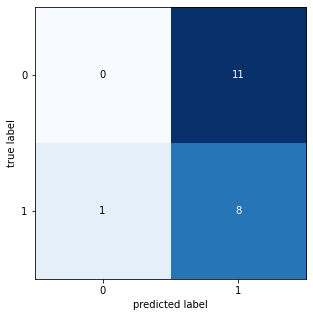

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



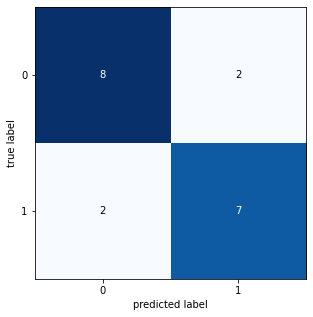

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



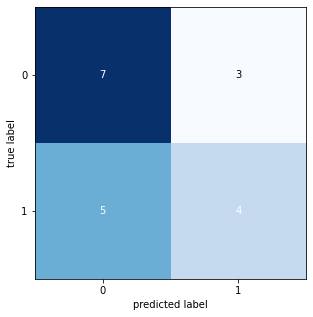

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


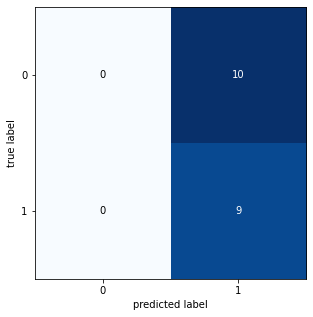

avg accuraccy Breast Cancer =  0.538421052631579
avg F1_Score Breast Cancer =  0.45491167835995433
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.4
min F1_Score Breast Cancer =  0.2857142857142857
Running Time:  39.518923212002846
gene : [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


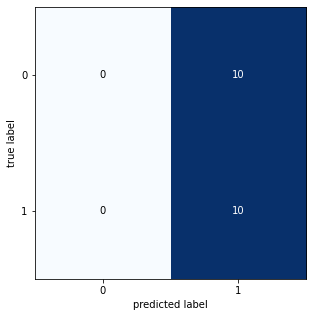

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



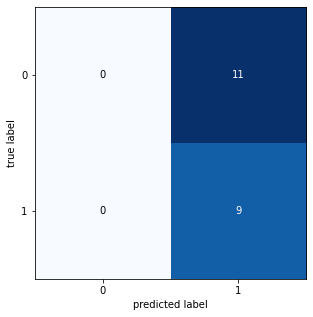

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



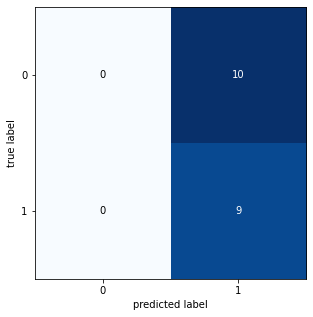

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



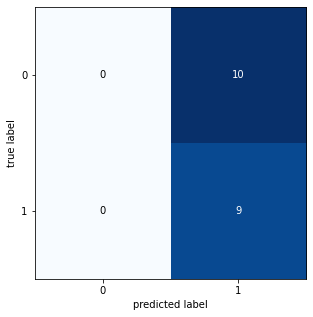

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



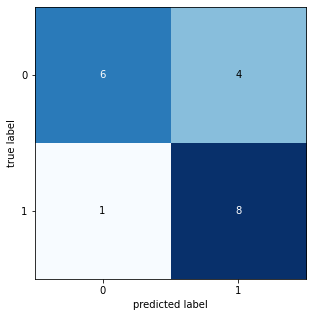

avg accuraccy Breast Cancer =  0.5268421052631578
avg F1_Score Breast Cancer =  0.4040857722399305
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.843597331993806
gene : [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

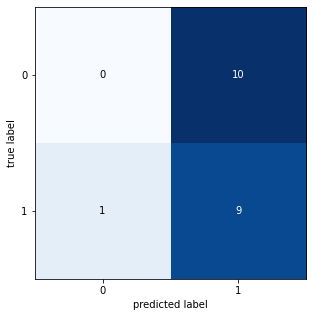

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


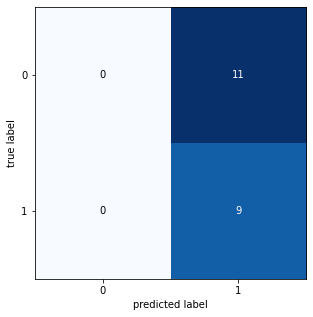

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.80      0.44      0.57         9

    accuracy                           0.68        19
   macro avg       0.72      0.67      0.66        19
weighted avg       0.72      0.68      0.67        19



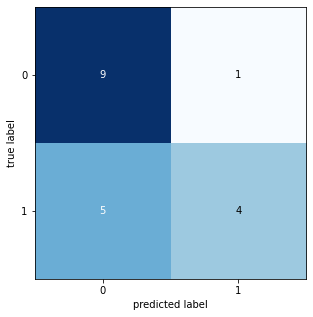

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



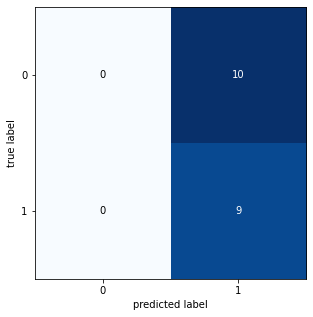

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



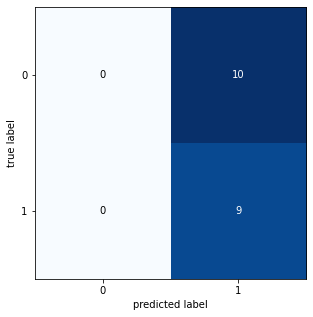

avg accuraccy Breast Cancer =  0.5063157894736843
avg F1_Score Breast Cancer =  0.38485221674876846
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6607142857142857
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.585021502003656
gen terbaik : [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.5668672964462438  || jumlah fitur : 48

Generation : 2
gene : [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


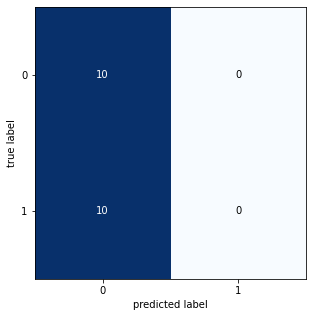

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



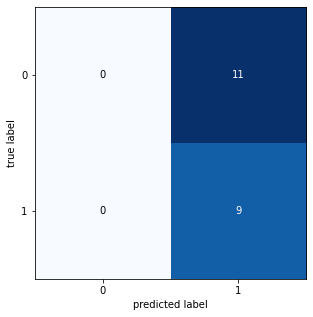

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



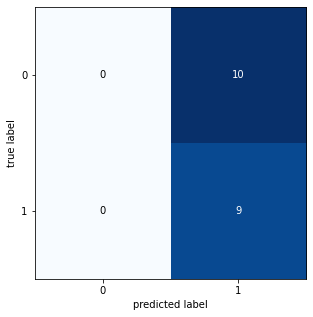

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



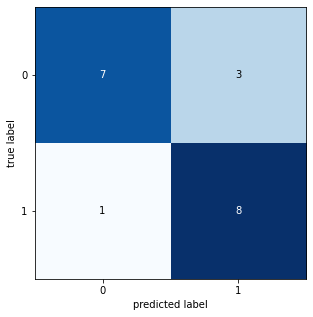

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.60      1.00      0.75         9

    accuracy                           0.68        19
   macro avg       0.80      0.70      0.66        19
weighted avg       0.81      0.68      0.66        19



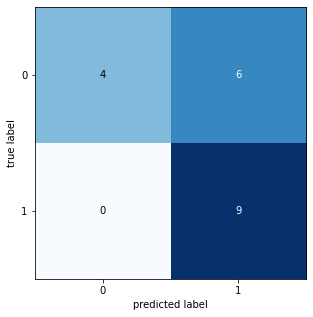

avg accuraccy Breast Cancer =  0.5794736842105263
avg F1_Score Breast Cancer =  0.48294198139025724
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.300886149998405
gene : [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

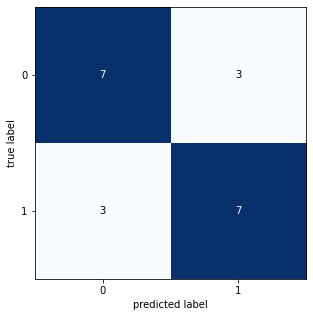

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.4791666666666667
              precision    recall  f1-score   support

           0       0.54      0.64      0.58        11
           1       0.43      0.33      0.38         9

    accuracy                           0.50        20
   macro avg       0.48      0.48      0.48        20
weighted avg       0.49      0.50      0.49        20



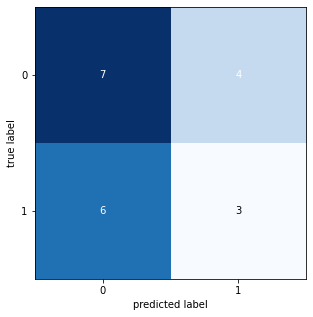

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


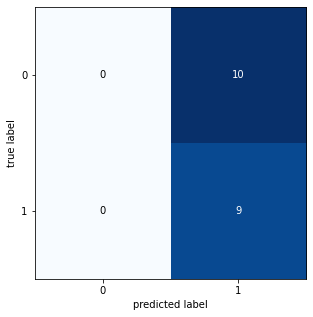

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



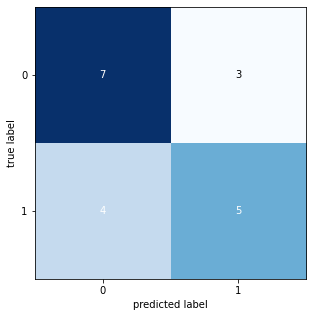

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



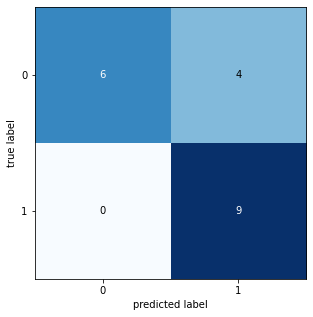

avg accuraccy Breast Cancer =  0.6189473684210526
avg F1_Score Breast Cancer =  0.5824274255156607
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.10122378500091
gene : [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

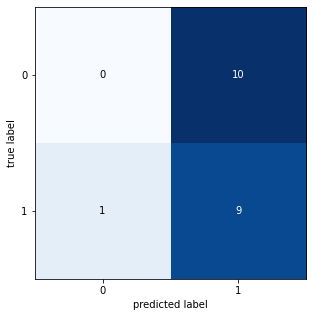

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


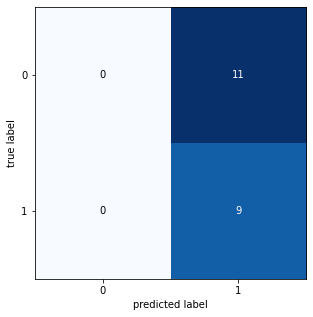

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



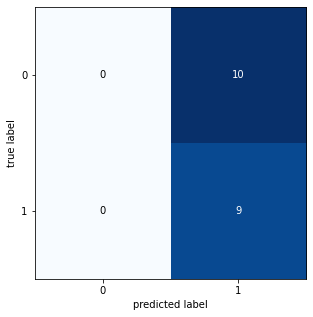

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.60      1.00      0.75         9

    accuracy                           0.68        19
   macro avg       0.80      0.70      0.66        19
weighted avg       0.81      0.68      0.66        19



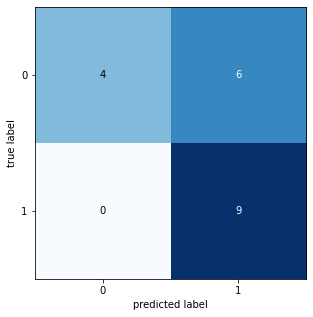

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



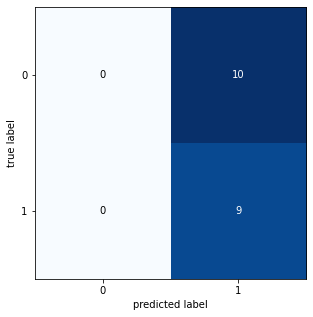

avg accuraccy Breast Cancer =  0.5063157894736843
avg F1_Score Breast Cancer =  0.38485221674876846
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6607142857142857
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.21672777200001
gene : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

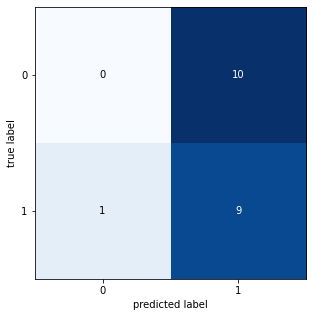

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



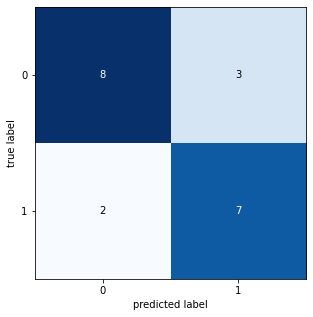

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


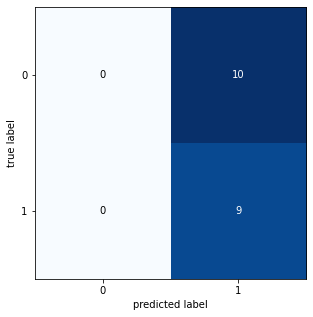

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



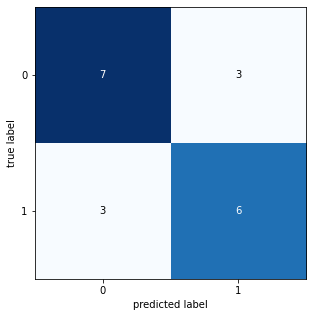

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



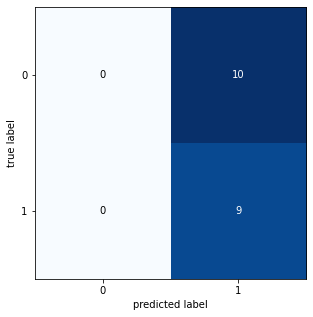

avg accuraccy Breast Cancer =  0.5663157894736842
avg F1_Score Breast Cancer =  0.4771817474721286
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.698734764999244
gene : [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

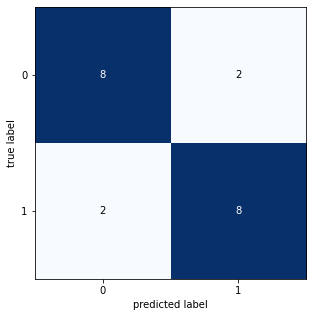

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.57      0.89      0.70         9

    accuracy                           0.65        20
   macro avg       0.70      0.67      0.64        20
weighted avg       0.72      0.65      0.64        20



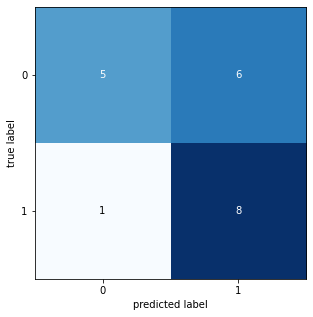

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


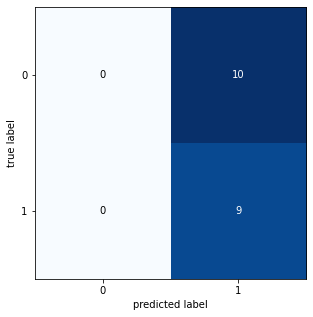

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



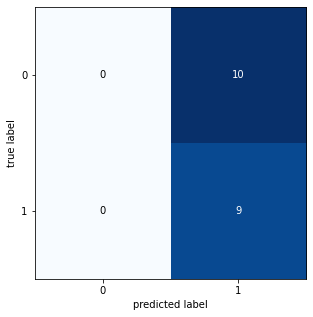

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



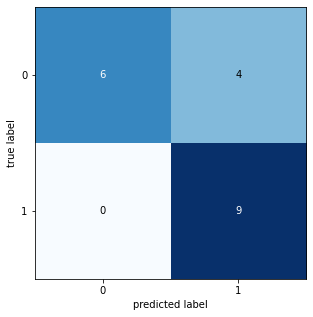

avg accuraccy Breast Cancer =  0.6373684210526316
avg F1_Score Breast Cancer =  0.5737783571926794
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.8000000000000002
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.598439772002166
gene : [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

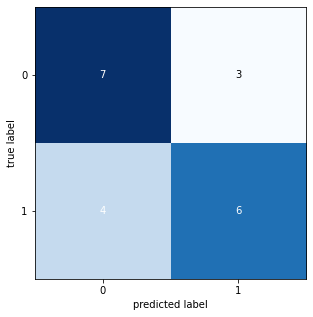

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



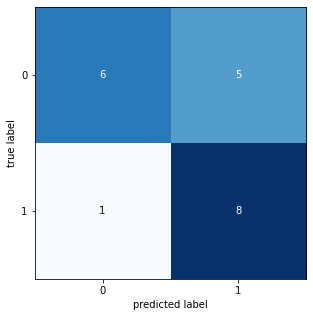

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


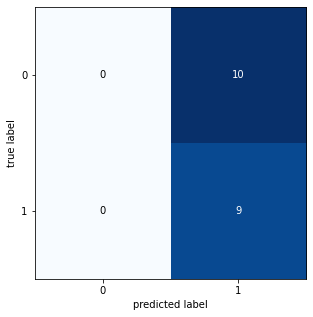

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



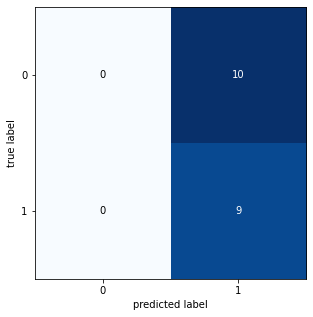

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692308
              precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.75      0.33      0.46         9

    accuracy                           0.63        19
   macro avg       0.68      0.62      0.59        19
weighted avg       0.67      0.63      0.60        19



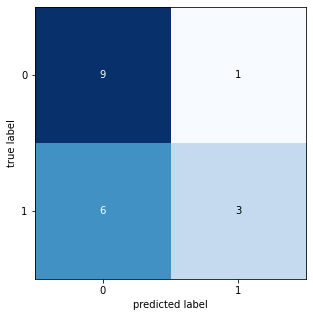

avg accuraccy Breast Cancer =  0.5857894736842105
avg F1_Score Breast Cancer =  0.5159437755227229
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.696969696969697
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.09158014100103
gene : [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

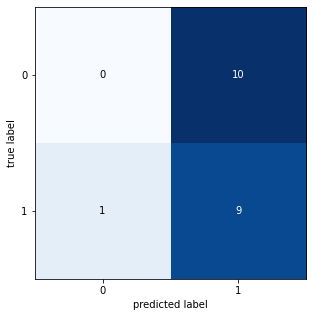

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.57      0.89      0.70         9

    accuracy                           0.65        20
   macro avg       0.70      0.67      0.64        20
weighted avg       0.72      0.65      0.64        20



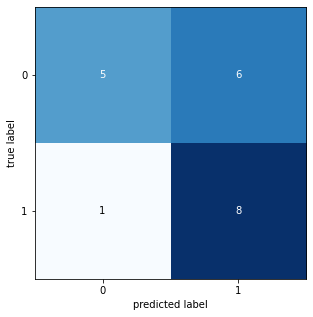

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



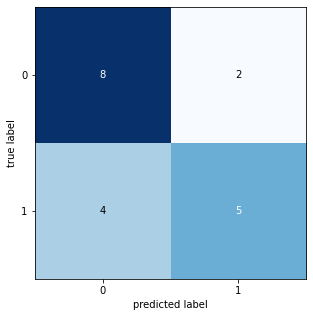

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



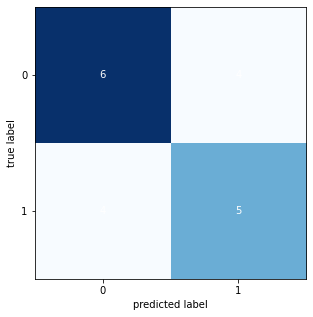

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


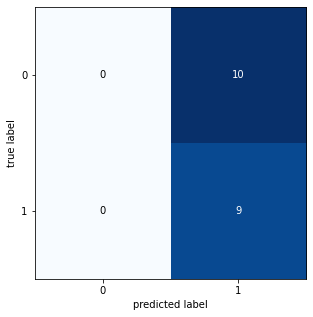

avg accuraccy Breast Cancer =  0.5673684210526316
avg F1_Score Breast Cancer =  0.505526254888853
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6761363636363636
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  42.24003697199805
gene : [0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

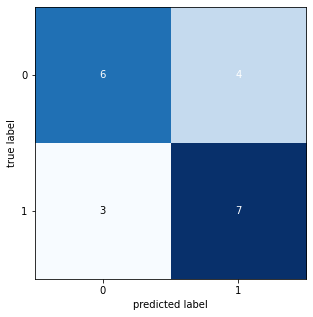

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5833333333333334
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.57      0.44      0.50         9

    accuracy                           0.60        20
   macro avg       0.59      0.59      0.58        20
weighted avg       0.60      0.60      0.59        20



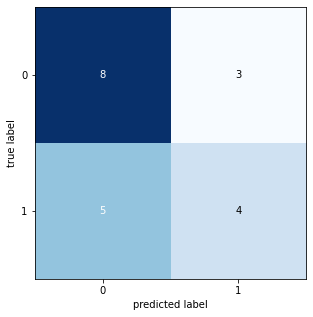

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


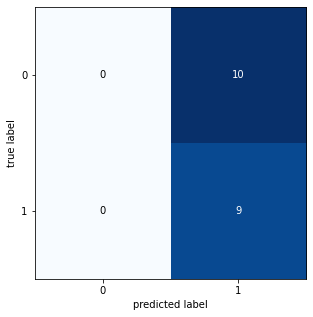

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



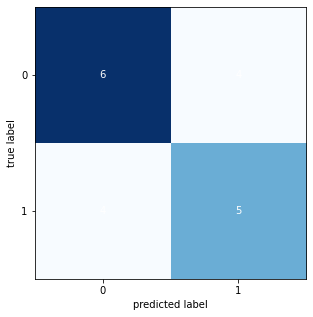

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



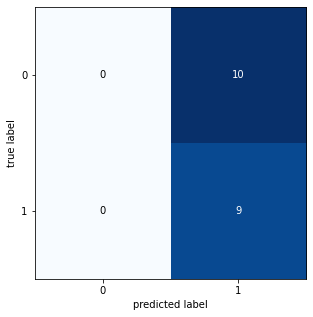

avg accuraccy Breast Cancer =  0.5552631578947368
avg F1_Score Breast Cancer =  0.49061821219715956
max accuraccy Breast Cancer =  0.65
max F1_Score Breast Cancer =  0.6491228070175439
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  43.494402401003754
gene : [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 

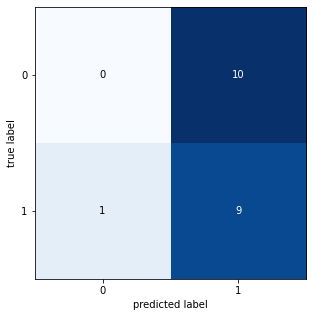

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



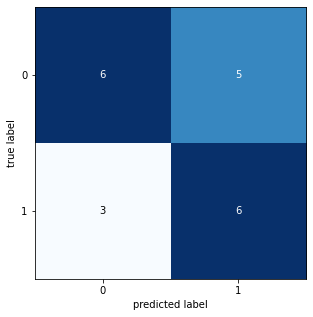

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


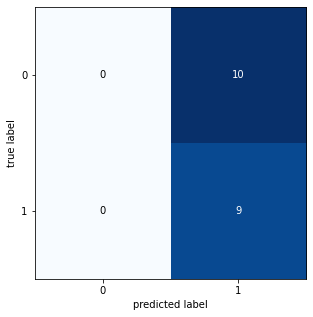

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5043478260869565
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.50      0.78      0.61         9

    accuracy                           0.53        19
   macro avg       0.55      0.54      0.50        19
weighted avg       0.55      0.53      0.50        19



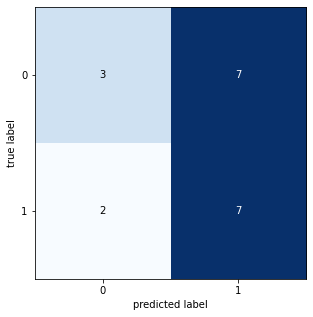

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5128205128205128
              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.67      0.22      0.33         9

    accuracy                           0.58        19
   macro avg       0.61      0.56      0.51        19
weighted avg       0.61      0.58      0.52        19



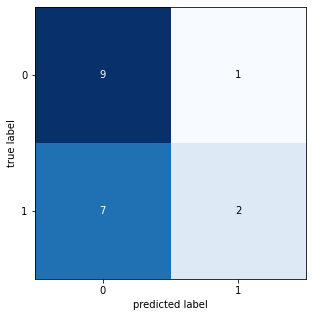

avg accuraccy Breast Cancer =  0.5257894736842105
avg F1_Score Breast Cancer =  0.4497883475844495
max accuraccy Breast Cancer =  0.6
max F1_Score Breast Cancer =  0.6
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.07631724100065
gene : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1

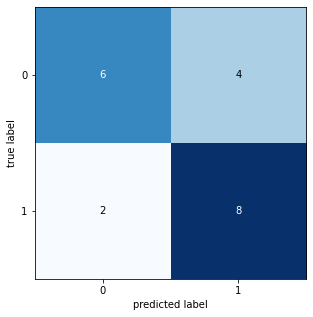

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



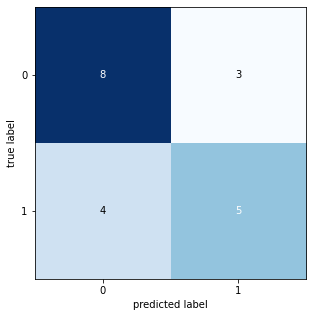

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


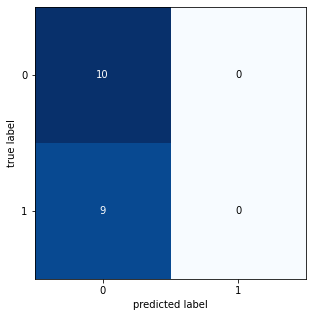

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



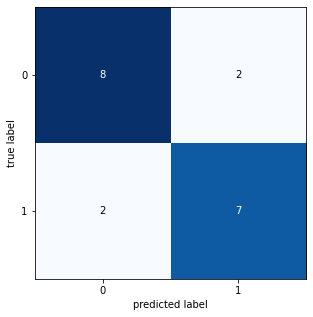

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



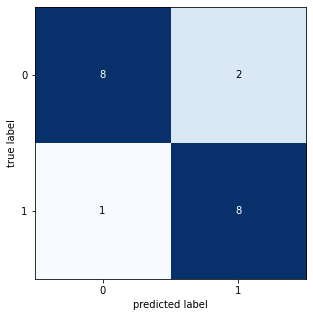

avg accuraccy Breast Cancer =  0.701578947368421
avg F1_Score Breast Cancer =  0.6629470338477444
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.5263157894736842
min F1_Score Breast Cancer =  0.3448275862068966
Running Time:  42.723310058005154
gen terbaik : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
F-1 Score terbaik : 0.6629470338477444  || jumlah fitur : 56

Generation : 3
gene : [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 

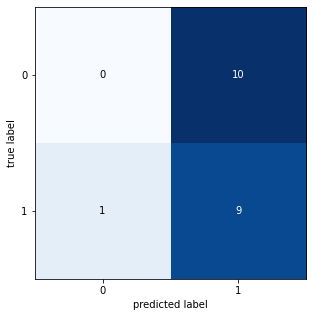

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5833333333333334
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.57      0.44      0.50         9

    accuracy                           0.60        20
   macro avg       0.59      0.59      0.58        20
weighted avg       0.60      0.60      0.59        20



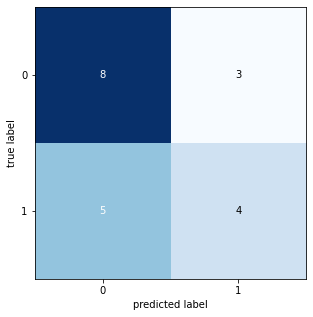

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



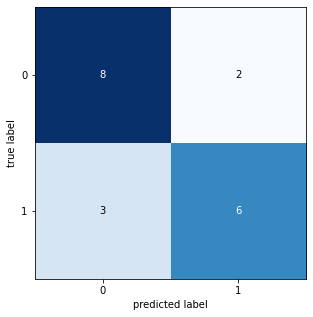

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



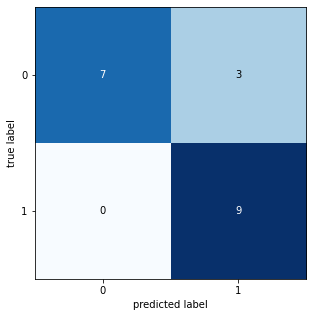

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



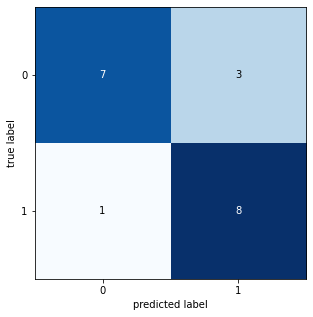

avg accuraccy Breast Cancer =  0.6836842105263157
avg F1_Score Breast Cancer =  0.6513593483370359
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.558066015000804
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


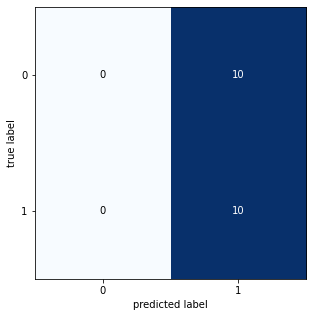

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



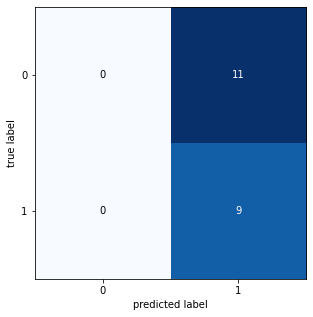

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



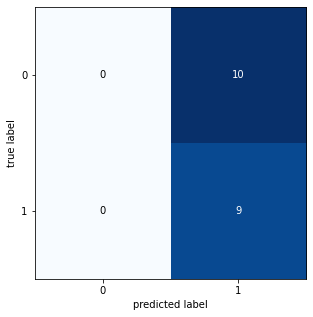

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



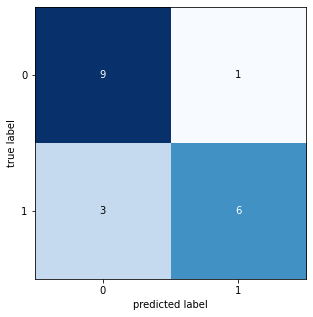

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



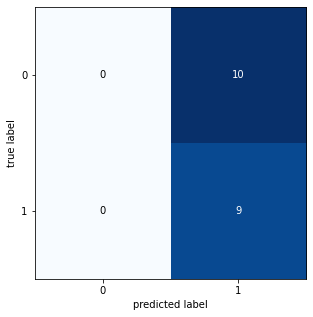

avg accuraccy Breast Cancer =  0.5373684210526315
avg F1_Score Breast Cancer =  0.41412524257351846
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7840909090909092
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  43.268019281000306
gene : [0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


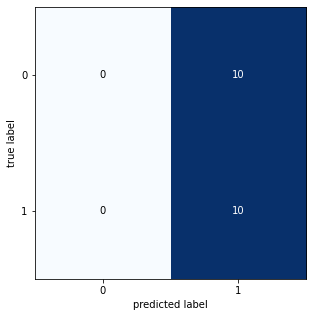

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



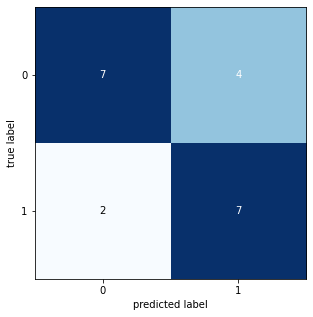

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



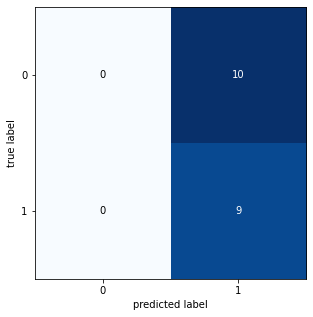

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



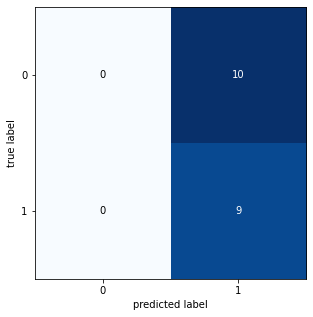

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



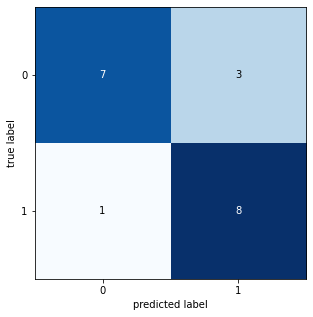

avg accuraccy Breast Cancer =  0.5873684210526315
avg F1_Score Breast Cancer =  0.493015873015873
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.20193504299823
gene : [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

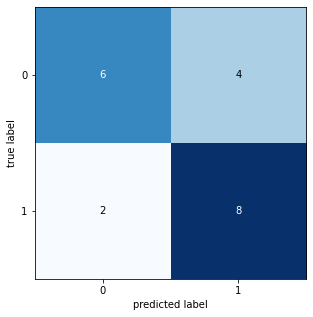

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


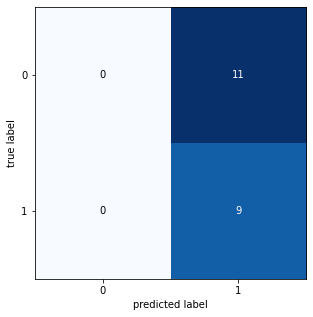

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



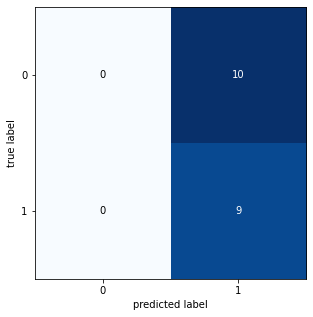

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5043478260869565
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.50      0.33      0.40         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.50        19
weighted avg       0.52      0.53      0.51        19



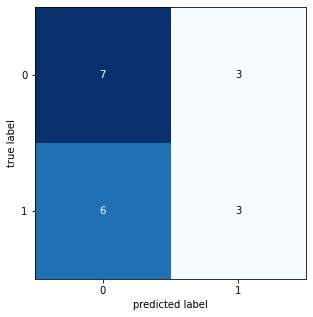

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



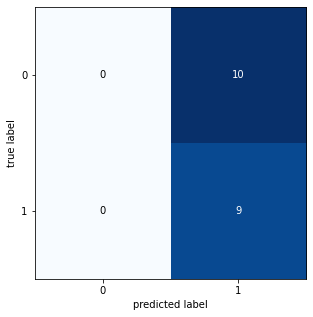

avg accuraccy Breast Cancer =  0.5247368421052632
avg F1_Score Breast Cancer =  0.4309038987000006
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.6969696969696968
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  42.8944969380027
gene : [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

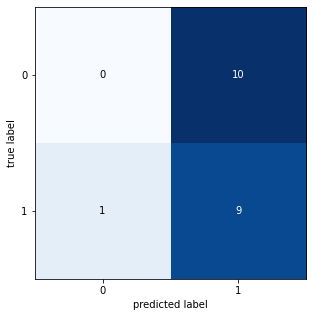

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



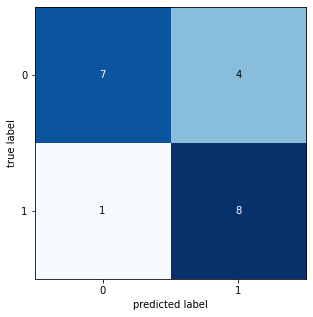

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


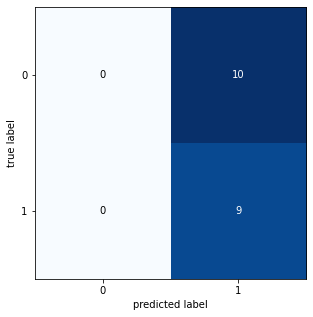

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



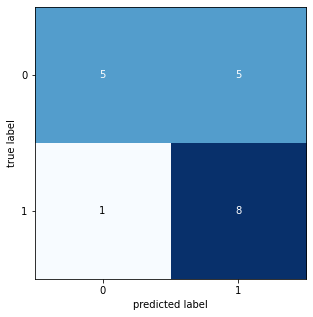

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



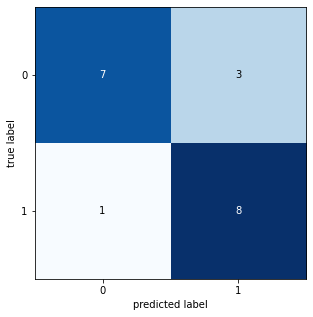

avg accuraccy Breast Cancer =  0.6294736842105262
avg F1_Score Breast Cancer =  0.5692344170247982
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.85652635899896
gene : [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

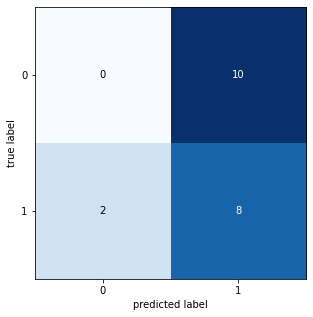

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



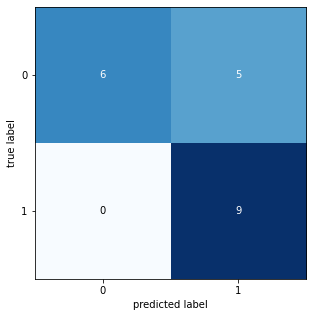

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



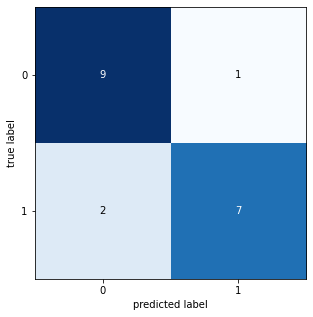

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


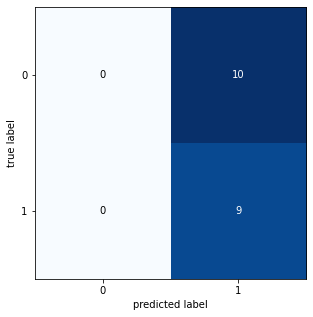

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



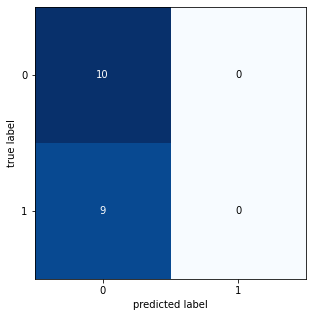

avg accuraccy Breast Cancer =  0.598421052631579
avg F1_Score Breast Cancer =  0.507310420420042
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.4
min F1_Score Breast Cancer =  0.2857142857142857
Running Time:  39.73545215999911
gene : [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1

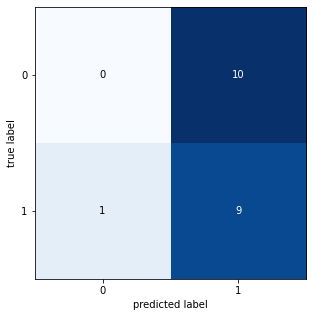

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


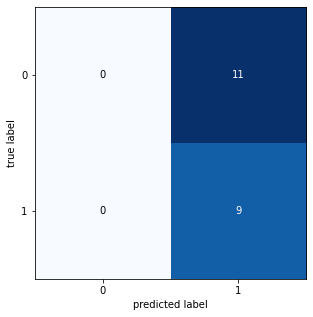

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



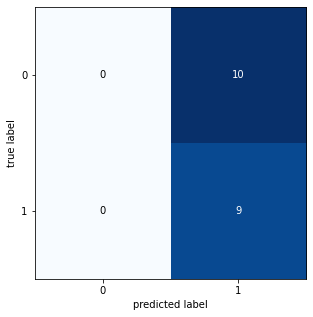

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



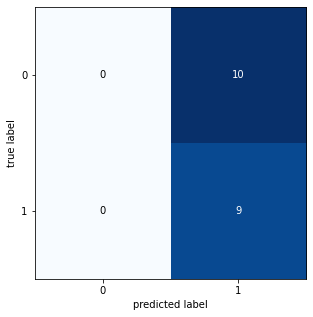

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.45714285714285713
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       1.00      0.11      0.20         9

    accuracy                           0.58        19
   macro avg       0.78      0.56      0.46        19
weighted avg       0.77      0.58      0.47        19



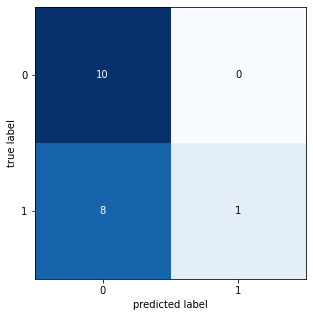

avg accuraccy Breast Cancer =  0.4852631578947369
avg F1_Score Breast Cancer =  0.34413793103448276
max accuraccy Breast Cancer =  0.5789473684210527
max F1_Score Breast Cancer =  0.45714285714285713
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.838846131002356
gene : [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


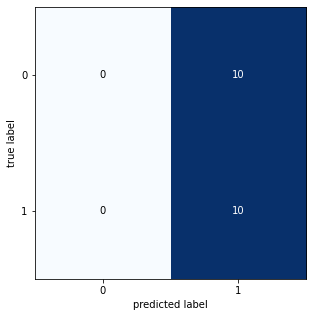

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



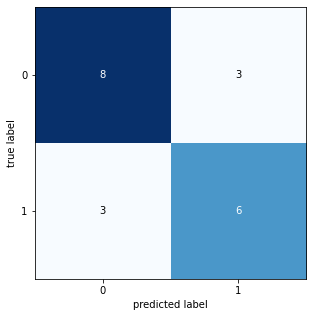

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



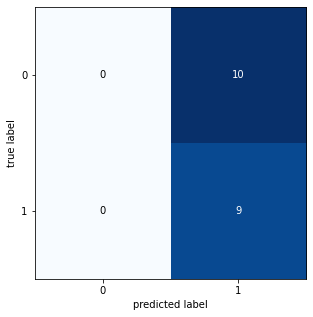

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



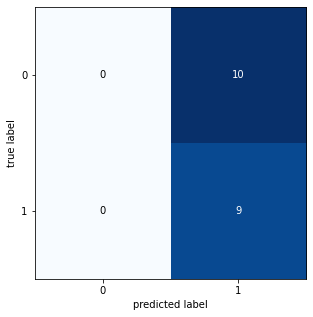

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



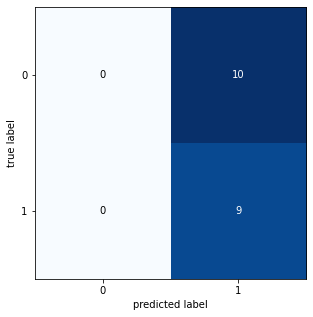

avg accuraccy Breast Cancer =  0.5242105263157895
avg F1_Score Breast Cancer =  0.3989177489177489
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.696969696969697
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  43.647522204999404
gene : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

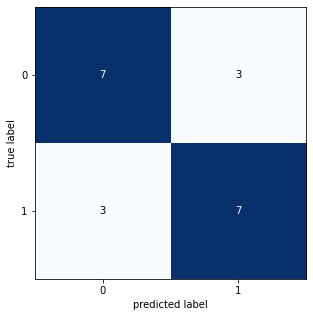

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



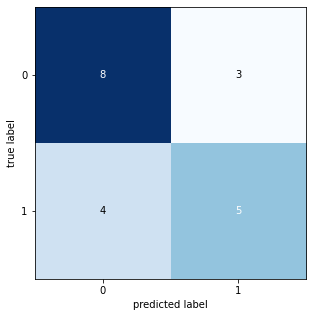

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



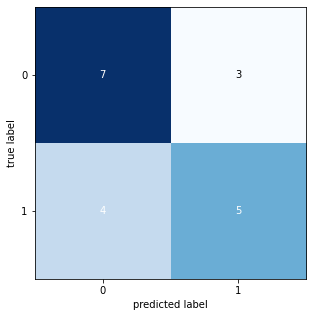

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



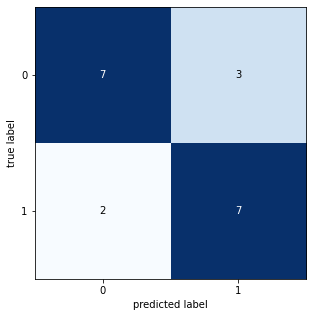

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



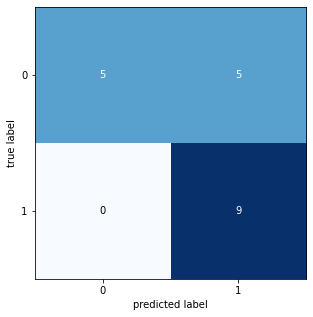

avg accuraccy Breast Cancer =  0.6910526315789474
avg F1_Score Breast Cancer =  0.686174900166016
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6274509803921569
Running Time:  39.535375740000745
gene : [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1

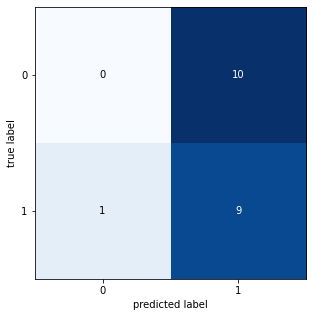

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



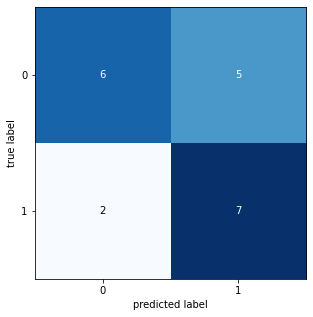

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



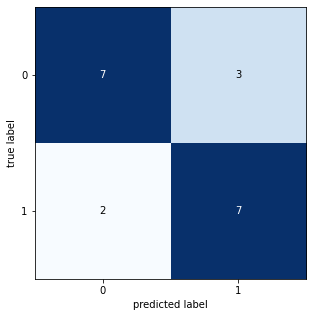

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5043478260869565
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.50      0.78      0.61         9

    accuracy                           0.53        19
   macro avg       0.55      0.54      0.50        19
weighted avg       0.55      0.53      0.50        19



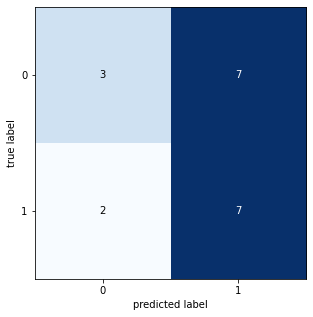

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


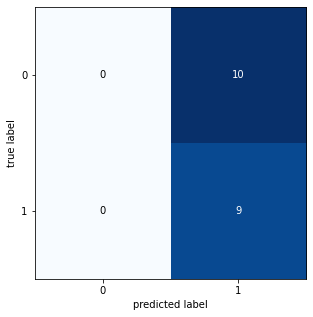

avg accuraccy Breast Cancer =  0.5673684210526316
avg F1_Score Breast Cancer =  0.5044172274764873
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.00861290600005
gen terbaik : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
F-1 Score terbaik : 0.686174900166016  || jumlah fitur : 56

Generation : 4
gene : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 

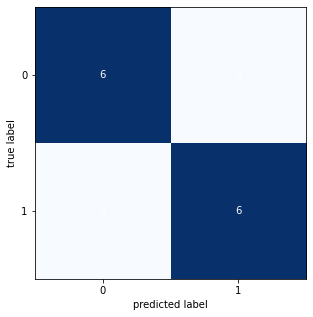

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


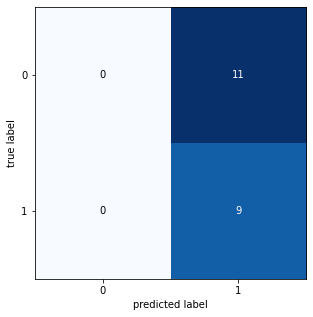

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



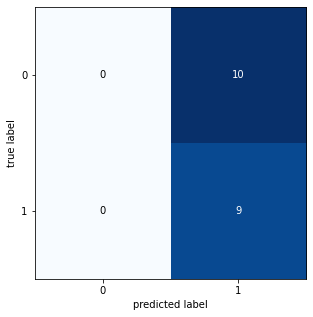

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



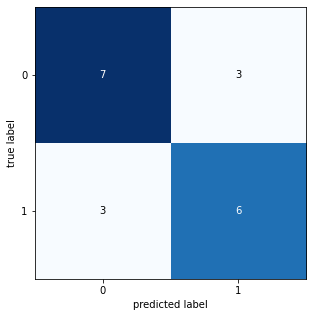

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



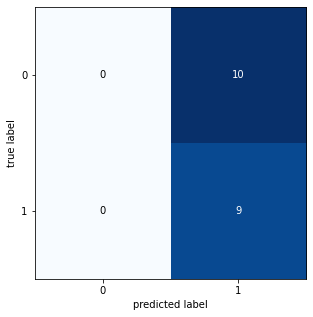

avg accuraccy Breast Cancer =  0.5363157894736842
avg F1_Score Breast Cancer =  0.44730706075533666
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.82967234899843
gene : [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

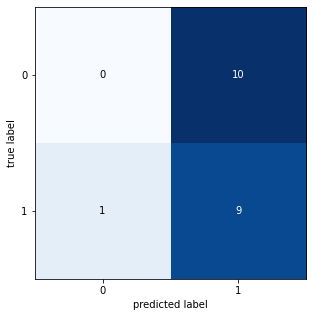

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



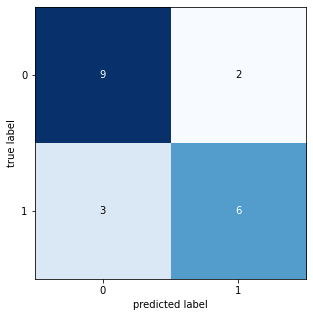

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


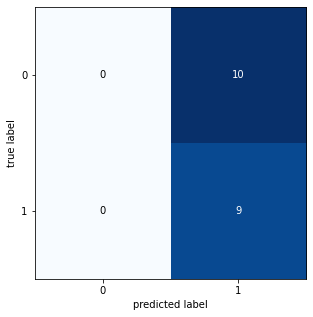

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



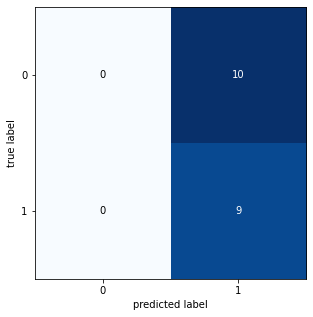

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



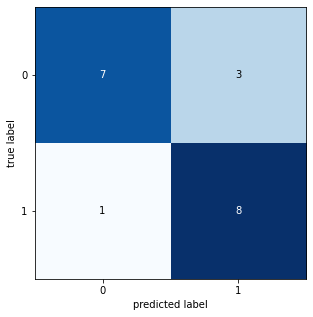

avg accuraccy Breast Cancer =  0.5873684210526315
avg F1_Score Breast Cancer =  0.49726727672578275
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.06569686200237
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

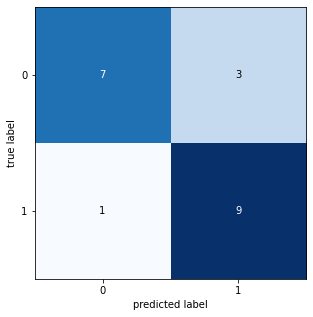

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


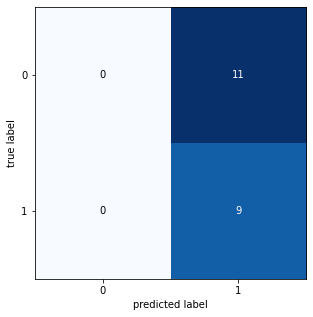

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



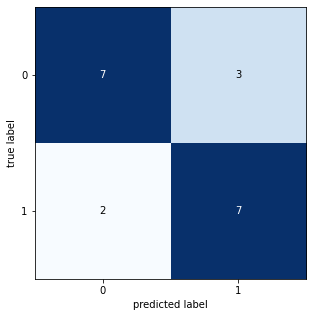

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



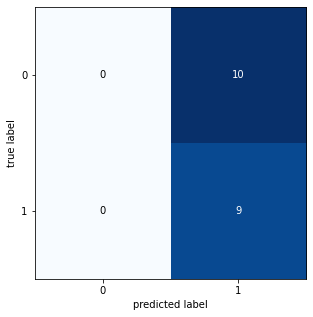

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



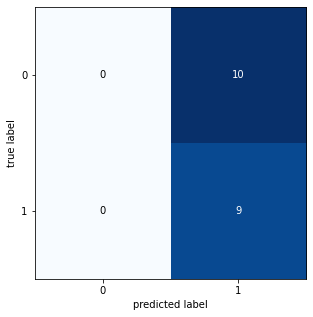

avg accuraccy Breast Cancer =  0.5868421052631579
avg F1_Score Breast Cancer =  0.4976047747372611
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.63892735300033
gene : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

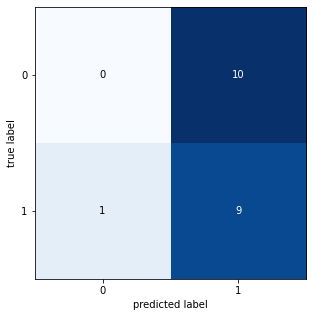

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


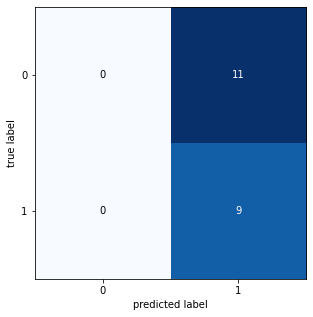

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



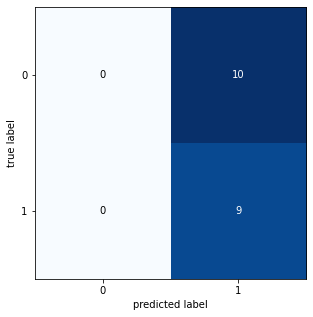

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



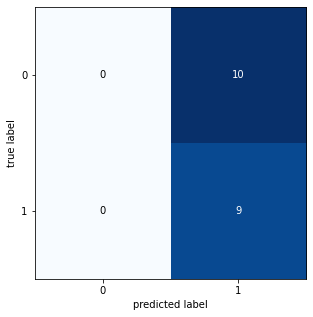

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



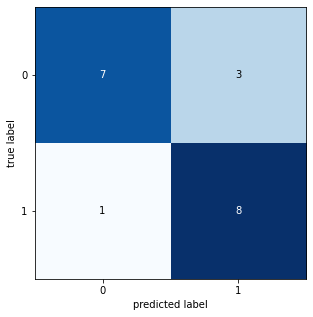

avg accuraccy Breast Cancer =  0.5273684210526316
avg F1_Score Breast Cancer =  0.41048713738368914
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  37.7868288729951
gene : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


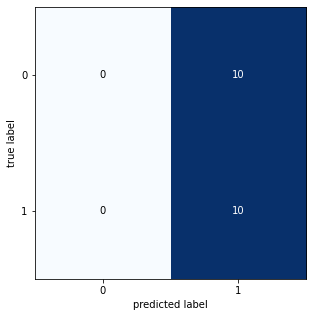

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



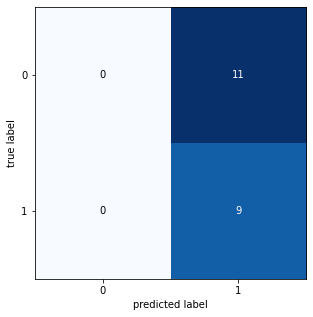

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



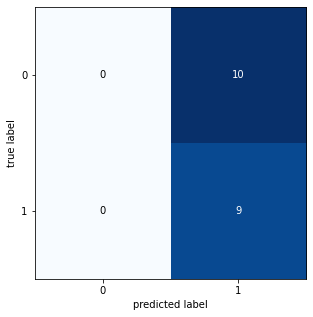

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



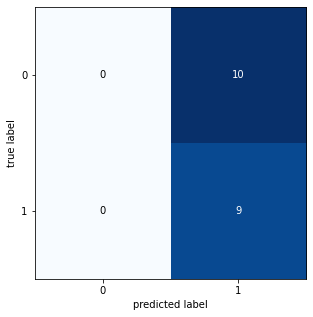

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



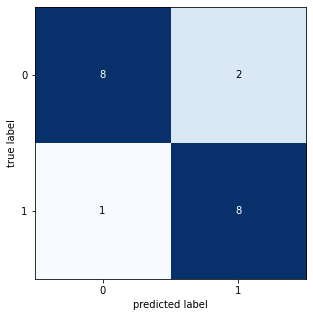

avg accuraccy Breast Cancer =  0.5478947368421052
avg F1_Score Breast Cancer =  0.4257281133869156
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  44.0386551019983
gene : [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

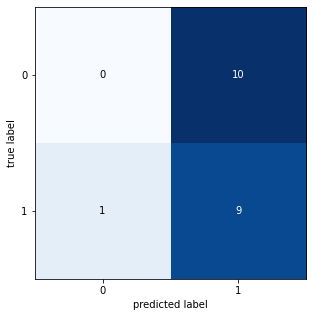

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.3548387096774194
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


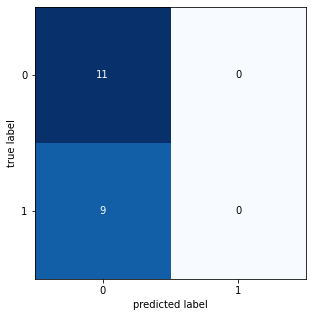

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



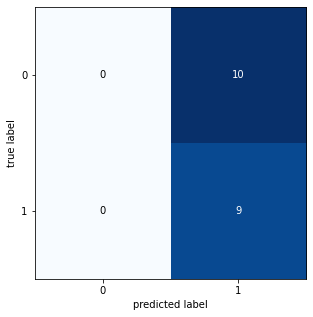

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



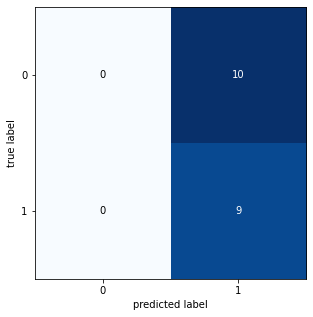

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



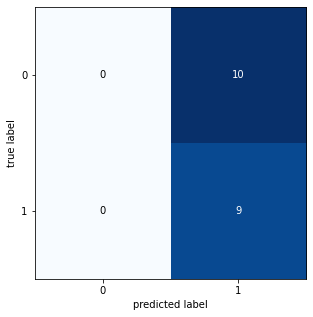

avg accuraccy Breast Cancer =  0.4842105263157895
avg F1_Score Breast Cancer =  0.3258938503098681
max accuraccy Breast Cancer =  0.55
max F1_Score Breast Cancer =  0.3548387096774194
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.187779685998976
gene : [0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

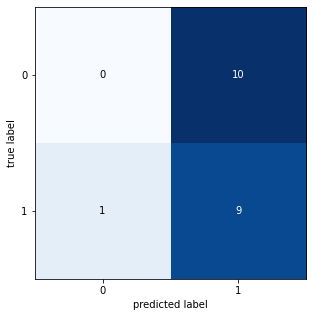

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


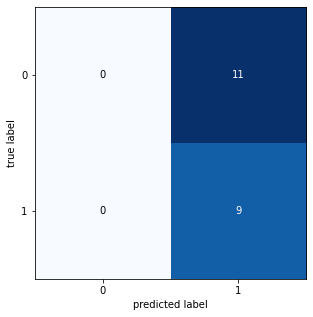

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



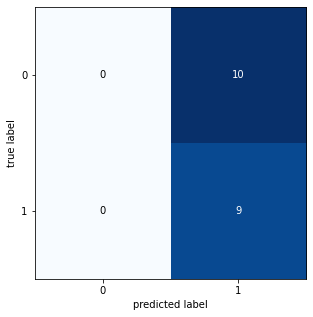

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



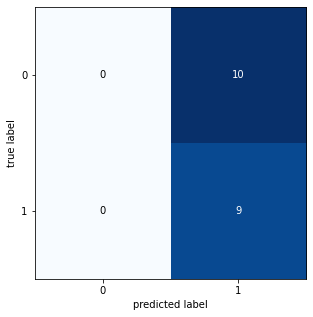

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



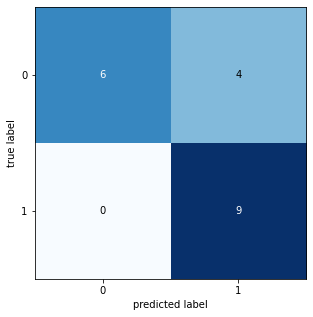

avg accuraccy Breast Cancer =  0.5273684210526316
avg F1_Score Breast Cancer =  0.40952754142409314
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.37049331700109
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

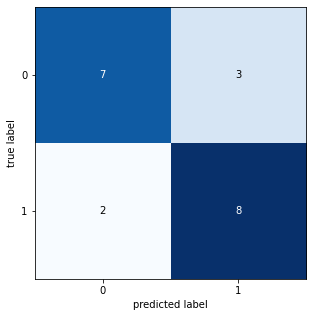

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


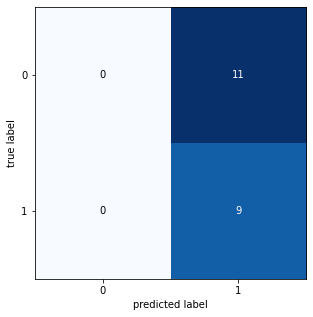

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



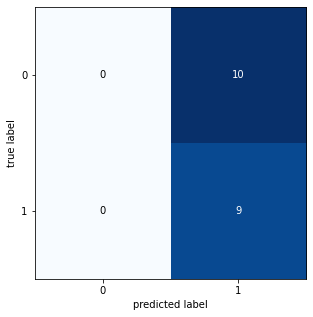

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



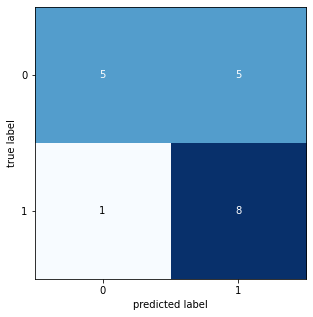

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



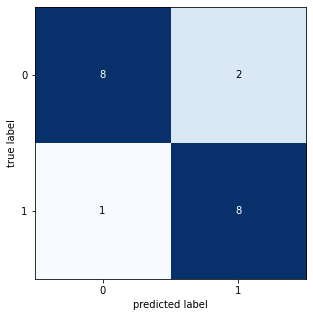

avg accuraccy Breast Cancer =  0.6399999999999999
avg F1_Score Breast Cancer =  0.5798776918785993
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.699975525996706
gene : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

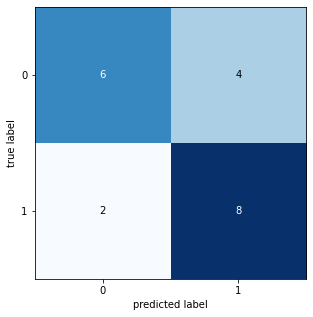

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


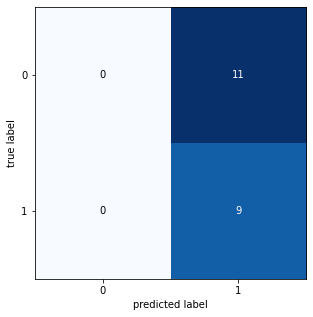

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



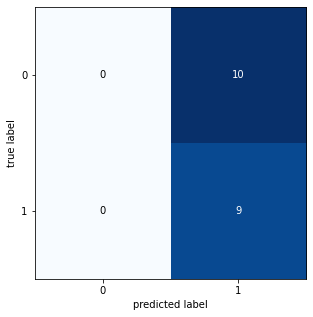

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



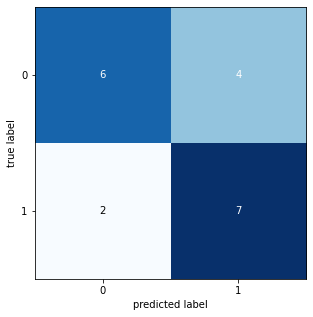

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



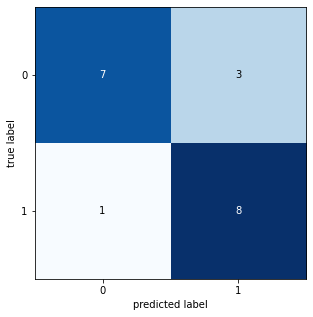

avg accuraccy Breast Cancer =  0.6194736842105263
avg F1_Score Breast Cancer =  0.5601930636413395
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.71507224599918
gene : [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


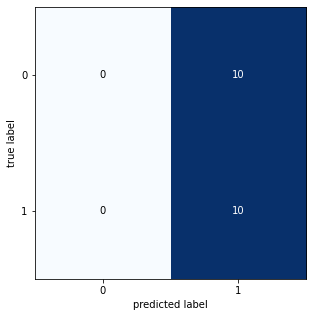

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



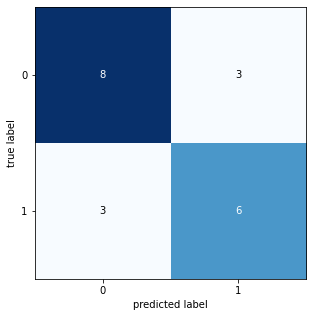

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



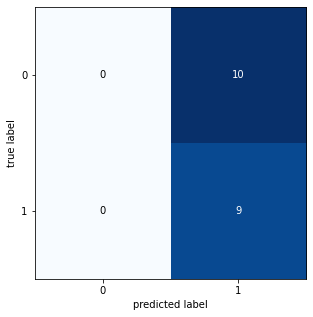

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



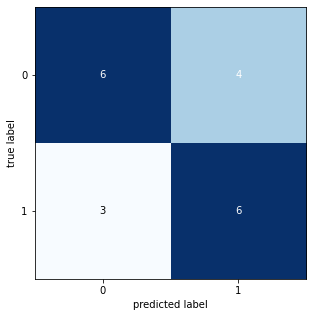

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



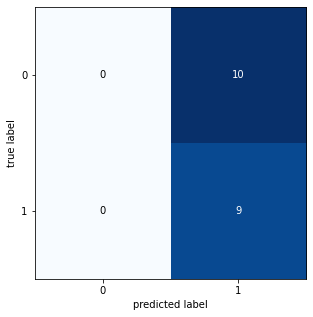

avg accuraccy Breast Cancer =  0.5557894736842105
avg F1_Score Breast Cancer =  0.4609478241057189
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.696969696969697
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.29578225500154
gen terbaik : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0]
F-1 Score terbaik : 0.5798776918785993  || jumlah fitur : 53

Running Time:  2051.8166298840006


In [15]:
Breast_IG_GA = GeneticAlgorithm(Breast_IG, 4)